# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

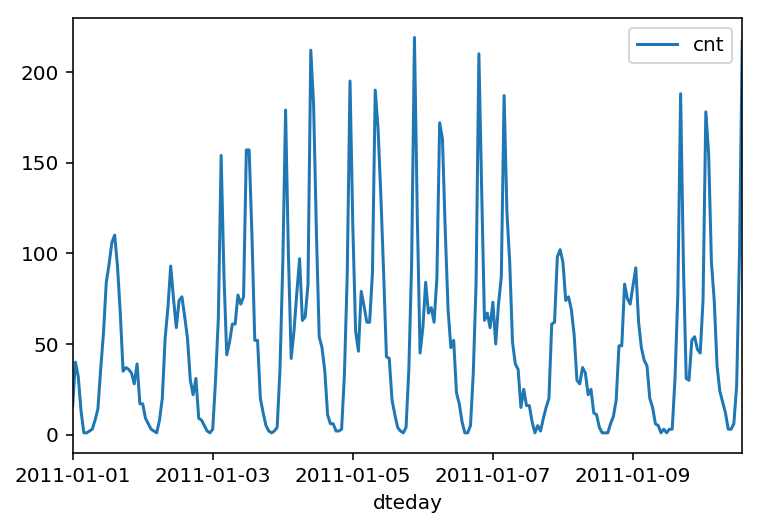

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [32]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))  # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):

            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###
            # weights_input_to_hidden: [[ 0.1 -0.2] [ 0.4  0.5]]
            # weights_hidden_to_output: [[ 0.3] [-0.1]]
            # hidden_inputs: (2,)
            # hidden_outputs: (2,)
            # final_inputs: (1,)
            # final_outputs: (1,)
            # error: [ 0.30001076]
            # output_error_term: (1,)
            # hidden_error: [ 0.09000323 -0.03000108]
            # hidden_error_term: (2, 2)
            # delta_weights_i_h: [[ 0.01124028 -0.00371992] [-0.00449611  0.00148797] [ 0.00224806 -0.00074398]]
            # delta_weights_h_o: [[ 0.01309434] [ 0.01228754]]
            # test: network.weights_hidden_to_output: [[ 0.30654717] [-0.09385623]]

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
            
            # TODO: Calculate the hidden layer's contribution to the error
            hidden_error = np.dot(self.weights_hidden_to_output, error)
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            output_error_term = error
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
            #print("weights_input_to_hidden:", self.weights_input_to_hidden, "weights_hidden_to_output:", self.weights_hidden_to_output)
            #print("hidden_inputs:", hidden_inputs.shape, "hidden_outputs:", hidden_outputs.shape, "final_inputs:", final_inputs.shape, "final_outputs:", final_outputs.shape, "error:", error, "output_error_term:", output_error_term.shape, "hidden_error:", hidden_error, "hidden_error_term:", hidden_error_term.shape)
            #break

            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:,None]
            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:,None]

        print("delta_weights_h_o:", delta_weights_h_o, "delta_weights_i_h:", delta_weights_i_h)
        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += delta_weights_h_o * self.lr # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden  += delta_weights_i_h * self.lr # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

In [19]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [33]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

delta_weights_h_o: [[ 0.14550657]
 [ 0.13654123]] delta_weights_i_h: [[ 0.01124028 -0.00371992]
 [-0.00449611  0.00148797]
 [ 0.00224806 -0.00074398]]



----------------------------------------------------------------------
Ran 5 tests in 0.006s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. Normally a good choice to start at is 0.1; however, if you effectively divide the learning rate by n_records, try starting out with a learning rate of 1. In either case, if the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [39]:
import sys

### Set the hyperparameters here ###
iterations = 500
learning_rate = 0.02
hidden_nodes = 3
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

delta_weights_h_o: [[-16.08959536]
 [-14.4363226 ]
 [-15.62833065]] delta_weights_i_h: [[ -2.72459408e-01   3.27021309e-01   2.04061764e-01]
 [  3.12021437e-01  -3.41858091e-01  -2.27655764e-01]
 [ -5.96972741e+00   7.28802897e+00   4.73828094e+00]
 [  8.61827991e+00  -1.03263905e+01  -6.54702155e+00]
 [ -1.99723508e+00   2.48397395e+00   1.53649374e+00]
 [  3.02026957e+00  -3.61424378e+00  -2.35541752e+00]
 [ -1.01073367e-01   2.41572821e-01   1.97047242e-01]
 [  5.91518820e-01  -6.80646081e-01  -4.71165275e-01]
 [  3.52654531e-01  -4.38558627e-01  -2.91416144e-01]
 [  1.04661746e+00  -1.24204091e+00  -8.45339699e-01]
 [  1.66062671e+00  -1.91252238e+00  -1.23872611e+00]
 [  1.15612538e+00  -1.33731238e+00  -8.36885889e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  9.59878561e-01  -1.17516362e+00  -7.65253954e-01]
 [  1.51289896e+00  -1.81228214e+00  -1.18434972e+00]
 [  2.42478127e-01  -2.76807367e-01  -1.76191014e-01]
 [ -8.41030982e-02   1.22423767e-01   6.89218570e

Progress: 0.4% ... Training loss: 0.770 ... Validation loss: 1.371delta_weights_h_o: [[ -3.58447109]
 [ 11.02402223]
 [  5.15838713]] delta_weights_i_h: [[ -3.69055332e+00   2.52917957e+00   1.18411379e+00]
 [ -1.35145030e-01   1.42328724e-01   7.80313310e-02]
 [ -5.87623177e+00   4.30332201e+00   2.06957014e+00]
 [  6.92801428e+00  -5.32656770e+00  -2.39468974e+00]
 [ -2.79532111e+00   2.08434424e+00   9.85106100e-01]
 [  6.21607458e-01  -4.48677408e-01  -2.20543762e-01]
 [ -1.15571791e+00   6.16046655e-01   3.40488044e-01]
 [ -8.60398468e-01   6.51527673e-01   3.77578983e-01]
 [ -3.49992482e-01   1.76430778e-01   5.16752315e-02]
 [ -1.01668827e+00   5.45751571e-01   2.91431496e-01]
 [ -6.02772100e-01   4.17107123e-01   1.97451411e-01]
 [ -1.25041033e-01   3.24690048e-02   6.03155905e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.74656638e-02  -1.78270047e-02  -3.99726268e-02]
 [  4.48737979e-01  -3.11224628e-01  -1.19189424e-01]
 [  1.05007685e-01  -7.33160921e-02  

Progress: 1.0% ... Training loss: 0.747 ... Validation loss: 1.049delta_weights_h_o: [[-18.77230818]
 [-20.0766669 ]
 [-19.40752595]] delta_weights_i_h: [[  4.28232589e-01  -5.11060388e-01  -1.56717003e-01]
 [ -1.74319657e-01   1.86473376e-01   6.59154421e-02]
 [  1.63796982e+00  -1.79179619e+00  -7.52491480e-01]
 [ -8.02164149e-02   1.36326658e-01   3.40377752e-01]
 [  2.29751847e+00  -1.93790415e+00  -6.47311422e-01]
 [  1.93077229e+00  -2.06359874e+00  -9.48128449e-01]
 [  1.78454723e+00  -1.99716002e+00  -8.52909176e-01]
 [  4.22050867e+00  -4.45475006e+00  -1.96117564e+00]
 [  6.10865578e-01  -7.16508051e-01  -3.24614158e-01]
 [  7.47372437e+00  -8.02765775e+00  -3.52753554e+00]
 [  9.85246075e-01  -1.15687517e+00  -5.43516409e-01]
 [  8.77233209e-02  -4.74839542e-02  -1.57754766e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  8.24391832e-01  -8.74443299e-01  -3.95781122e-01]
 [  5.61717479e-01  -6.45552110e-01  -2.77760348e-01]
 [  1.30458730e+00  -1.36122689e+00  

Progress: 1.6% ... Training loss: 0.988 ... Validation loss: 2.147delta_weights_h_o: [[ 36.20024468]
 [ 27.50386556]
 [ 27.74084228]] delta_weights_i_h: [[ -1.10089242e+01   4.38536045e+00  -7.32824461e-01]
 [ -4.19979408e-01   1.84848939e-01  -3.78313141e-02]
 [ -5.95256187e-01   9.81314728e-01  -2.22400157e-02]
 [ -1.65533578e+00   6.53326373e-01  -2.05884305e-01]
 [  1.22730423e+00  -5.42650828e-01   1.37546886e-01]
 [ -4.45863315e+00   1.56765357e+00  -3.18086570e-01]
 [ -7.62410655e+00   2.84413735e+00  -4.97623101e-01]
 [ -4.50934030e+00   2.01734490e+00  -3.27667679e-01]
 [ -3.88121167e+00   1.32421526e+00  -2.78527726e-01]
 [ -1.28637401e+01   4.81161521e+00  -8.58607765e-01]
 [ -7.29799665e+00   2.86725531e+00  -5.42012875e-01]
 [ -3.11554952e-01   7.44805635e-02  -2.12844356e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.92435356e+00   6.57603240e-01  -1.37071758e-01]
 [ -9.63809281e-01   3.33538927e-01  -6.96938153e-02]
 [ -2.77797159e+00   1.00275367e+00  

Progress: 2.2% ... Training loss: 0.617 ... Validation loss: 1.102delta_weights_h_o: [[-3.36369529]
 [ 3.82288736]
 [ 0.85589119]] delta_weights_i_h: [[  2.23339787e-01   1.45896583e+00   6.13458794e-01]
 [  5.07226864e-01  -5.69615896e-01  -1.75540415e-01]
 [  1.10369506e+00   4.89319446e-01   2.40605578e-01]
 [  5.89184022e-01  -2.03683176e+00  -5.51096490e-01]
 [  8.04528123e-01  -1.04405309e+00  -4.74771269e-01]
 [  7.54384623e-01  -5.65056887e-01  -1.36995519e-01]
 [  1.65988011e+00  -1.18660422e+00  -2.98611836e-01]
 [  1.17101989e+00  -1.73176130e-01   3.03279470e-02]
 [ -8.80357591e-01   1.18006705e+00   4.42708334e-01]
 [  2.73882308e+00  -9.30740042e-01  -1.12981505e-01]
 [  4.14052263e-01   2.72594455e-02   5.84640416e-02]
 [ -4.47948310e-01   1.58710410e-01   9.19463905e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.38335667e-01  -2.02446969e-01  -5.57837195e-02]
 [ -1.80111627e-01   4.77692038e-02   4.77734319e-02]
 [  6.87718544e-01  -5.21293887e-01  -1.

Progress: 2.8% ... Training loss: 0.586 ... Validation loss: 1.092delta_weights_h_o: [[ 5.79848796]
 [ 0.50010141]
 [ 1.44432564]] delta_weights_i_h: [[ -2.76165749e-01   7.68968029e-01   2.32485525e-01]
 [  7.69780901e-02   1.87281146e-02   1.38981827e-02]
 [  2.82120367e+00  -1.38432507e+00  -5.92642288e-01]
 [ -4.46506924e+00   5.23293475e+00   1.34355185e+00]
 [  2.33062653e+00  -2.27821765e+00  -4.21017166e-01]
 [ -7.30600239e-02  -5.64426615e-01  -3.93834779e-02]
 [ -9.20854941e-01   7.22514464e-01   1.93086608e-01]
 [  1.16107643e+00  -9.46797349e-01  -2.29578688e-01]
 [ -1.41008962e+00   1.53713621e+00   3.55763999e-01]
 [ -6.92652828e-01   2.36503366e-01   1.40957487e-01]
 [ -1.06131128e+00   1.08865918e+00   2.59323113e-01]
 [  5.11035955e-01  -5.76735828e-01  -1.20392159e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -3.75010164e-01   2.10018048e-01   8.97665217e-02]
 [ -5.46195044e-02  -9.20227698e-02   2.42717429e-02]
 [  2.43715715e-01  -6.05523281e-01  -1.

Progress: 3.4% ... Training loss: 0.532 ... Validation loss: 0.906delta_weights_h_o: [[-1.14192527]
 [-2.50405261]
 [-2.29881165]] delta_weights_i_h: [[ -5.16325132e-02   4.93526625e-02   5.94453615e-02]
 [  5.48795001e-01  -4.72186895e-01  -1.20869338e-01]
 [ -2.07069794e-01   4.74248819e-01   1.41658037e-01]
 [ -8.97657071e+00   8.38447783e+00   1.90651515e+00]
 [  2.81737542e+00  -2.59049699e+00  -5.67476411e-01]
 [  8.77440821e-01  -7.94974491e-01  -1.27204826e-01]
 [  1.02457117e+00  -1.19859075e+00  -2.92152773e-01]
 [ -1.90930700e-01   1.35884578e-01   7.34757363e-02]
 [  1.12781861e-01  -1.28180598e-01  -1.93060431e-02]
 [  9.92325001e-01  -1.04885431e+00  -1.86935146e-01]
 [  2.78738511e-01  -2.22895422e-01  -1.57414388e-02]
 [  5.52799645e-01  -7.14111535e-01  -1.62511321e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -6.51872655e-02   3.00375456e-02   2.83401910e-02]
 [  5.43158343e-01  -4.86880621e-01  -1.07723623e-01]
 [  6.28414210e-01  -6.25758631e-01  -1.

Progress: 4.0% ... Training loss: 0.522 ... Validation loss: 0.896delta_weights_h_o: [[ 6.31307875]
 [ 9.18425752]
 [ 7.48902651]] delta_weights_i_h: [[  2.44325549e-01   3.71644609e-01   1.31541749e-01]
 [  1.04123092e+00  -8.75215405e-01  -1.49568372e-01]
 [ -2.69246095e+00   3.06841961e+00   5.20939648e-01]
 [ -2.23274905e+00   9.54324745e-01   1.55665016e-01]
 [  2.07968538e+00  -1.34073134e+00  -2.49880556e-01]
 [  5.14354480e-01  -6.61468449e-01  -5.86364636e-02]
 [ -2.51303504e+00   2.48345267e+00   5.20957102e-01]
 [ -6.99550502e-01   8.97716578e-01   1.87414124e-01]
 [ -1.64215708e+00   1.26495061e+00   2.38973777e-01]
 [ -2.26993006e+00   2.44104050e+00   5.57483874e-01]
 [ -1.79523505e+00   1.29114487e+00   2.61643565e-01]
 [ -2.75223028e-01   2.52466034e-01   6.95811007e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -5.66700288e-02  -1.13233185e-01   6.35620844e-03]
 [  4.52154476e-01  -3.62439607e-01  -5.13503098e-02]
 [  6.68322621e-01  -5.69351803e-01  -8.

Progress: 4.6% ... Training loss: 0.470 ... Validation loss: 0.771delta_weights_h_o: [[ -2.50919113]
 [ 10.37708538]
 [  4.68694185]] delta_weights_i_h: [[ -1.11799778e+00   2.42537556e+00   7.28330383e-01]
 [  5.38046331e-01  -5.03345093e-01  -1.08677357e-01]
 [ -3.08784099e+00   4.28989357e+00   1.10787701e+00]
 [  5.99252523e+00  -6.15077420e+00  -1.48893113e+00]
 [ -8.06617622e+00   8.39972343e+00   2.04938205e+00]
 [ -6.22833230e-02   6.15415891e-02   3.90045224e-02]
 [ -1.97439320e-01   6.91956240e-01   1.77894519e-01]
 [ -2.02969186e+00   2.76106015e+00   6.22017908e-01]
 [  8.31194707e-01  -4.02360960e-01  -3.58432434e-02]
 [ -3.20665607e+00   4.18802536e+00   9.86802449e-01]
 [  5.88235616e-01  -8.90554885e-02   4.82622903e-02]
 [  1.16020065e+00  -9.86772855e-01  -2.31991033e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  9.65551002e-02  -7.18923333e-02  -8.50442684e-03]
 [ -2.04416478e-01   1.42972433e-01   4.16416022e-02]
 [ -8.88471401e-01   8.76945834e-01  

Progress: 5.2% ... Training loss: 0.691 ... Validation loss: 0.831delta_weights_h_o: [[-18.48517141]
 [-18.01093638]
 [-16.15695378]] delta_weights_i_h: [[  5.38215127e+00  -6.94629979e+00  -2.06359363e+00]
 [  1.11027864e-01  -1.54813132e-02   1.22833278e-03]
 [  1.07190770e+00  -2.28997586e+00  -8.95168803e-01]
 [ -6.50549955e+00   1.02377841e+01   3.58248079e+00]
 [  6.62750546e+00  -1.01653288e+01  -3.10090079e+00]
 [  4.93173851e+00  -6.36479669e+00  -2.02023313e+00]
 [  2.15480475e+00  -2.97645345e+00  -1.04006126e+00]
 [  4.42198719e+00  -5.60133785e+00  -1.75764267e+00]
 [  1.70921781e+00  -2.46936080e+00  -8.80446761e-01]
 [  1.03540347e+01  -1.34524452e+01  -4.42358171e+00]
 [  1.53046181e+00  -2.32871821e+00  -7.15983312e-01]
 [  1.33325179e+00  -1.63078535e+00  -5.58818793e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.38685985e+00  -2.01440541e+00  -5.64287142e-01]
 [  1.49604061e+00  -1.50833161e+00  -5.46734972e-01]
 [  1.79928150e+00  -2.69577149e+00  

Progress: 5.8% ... Training loss: 0.603 ... Validation loss: 0.843delta_weights_h_o: [[ 23.29793052]
 [ 23.31928149]
 [ 18.19873321]] delta_weights_i_h: [[ -1.45095480e+01   1.27590515e+01   1.64493272e+00]
 [ -7.65238079e-01   4.90163365e-01   9.17407637e-02]
 [ -6.51337000e+00   1.00176317e+01   1.01713745e+00]
 [  4.75889473e+00  -5.66535874e+00  -6.92648795e-01]
 [ -5.46291699e+00   5.15085221e+00   7.53504028e-01]
 [ -6.14878806e+00   3.85647204e+00   6.40868169e-01]
 [ -4.34879524e+00   3.64392300e+00   5.16163485e-01]
 [ -9.66341791e+00   8.82799889e+00   1.11111923e+00]
 [ -2.56429161e+00   2.13765752e+00   3.54635473e-01]
 [ -1.74923443e+01   1.44840539e+01   2.04522666e+00]
 [ -2.32365270e+00   1.74203149e+00   2.66962939e-01]
 [ -2.90929579e+00   2.23996601e+00   3.10596754e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.36179802e+00   5.26616687e-01   1.28772192e-01]
 [ -2.36774679e+00   1.42415575e+00   2.42828546e-01]
 [ -2.57382136e+00   2.18254287e+00  

Progress: 6.4% ... Training loss: 0.532 ... Validation loss: 0.701delta_weights_h_o: [[-18.14871447]
 [-18.01425535]
 [-14.92149265]] delta_weights_i_h: [[  8.42589601e+00  -1.10513656e+01  -2.61764048e+00]
 [  2.07302770e-02  -4.15165708e-02  -7.50713714e-03]
 [  3.65661518e+00  -8.81049908e+00  -1.87673691e+00]
 [  3.78398983e+00  -2.48364930e+00  -6.85700827e-01]
 [ -2.58382083e+00   3.40852078e+00   7.50341438e-01]
 [  2.75711863e+00  -2.46448268e+00  -6.98362115e-01]
 [  3.54189612e+00  -3.74518251e+00  -1.09269221e+00]
 [  6.66475347e+00  -9.94292015e+00  -2.15613752e+00]
 [  2.24111453e+00  -2.94085040e+00  -7.82342465e-01]
 [  8.75556837e+00  -1.13329735e+01  -2.70375993e+00]
 [  4.43410650e+00  -5.24444843e+00  -1.41573977e+00]
 [  2.01520787e+00  -2.51601384e+00  -6.10034614e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.27666212e+00  -8.61173689e-01  -3.03611236e-01]
 [  1.85312667e-01  -1.07645967e-01  -1.25765030e-02]
 [  1.29514384e+00  -1.49566303e+00  

Progress: 7.0% ... Training loss: 0.433 ... Validation loss: 0.686delta_weights_h_o: [[  9.831926  ]
 [ 13.19147608]
 [  9.77074644]] delta_weights_i_h: [[ -5.45969112e+00   7.78382403e+00   1.09797637e+00]
 [ -1.81961005e-01   3.14247122e-01   4.86819730e-02]
 [ -1.30927002e+00   5.25932522e+00   5.07586626e-01]
 [ -5.39873436e+00   4.70494537e+00   7.53354041e-01]
 [  1.60416361e+00   1.00196518e+00  -1.15064420e-03]
 [ -2.40224451e+00   1.45535248e+00   3.24604035e-01]
 [ -2.38741662e+00   2.90970164e+00   4.67181624e-01]
 [ -4.32093752e+00   5.98368761e+00   7.88995272e-01]
 [ -7.93874449e-01   5.13018351e-01   1.13175899e-01]
 [ -6.57966818e+00   8.36464253e+00   1.19851857e+00]
 [ -1.46944940e+00   7.44704770e-01   1.75442340e-01]
 [ -1.85535551e+00   1.75241279e+00   3.19995918e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -6.16383075e-01   2.26765199e-01   7.84749472e-02]
 [ -1.32172971e+00   9.29860793e-01   1.84095338e-01]
 [ -5.65323340e-01   4.64363079e-01  

Progress: 7.6% ... Training loss: 0.388 ... Validation loss: 0.633delta_weights_h_o: [[-2.15992413]
 [ 4.71192363]
 [ 1.53801623]] delta_weights_i_h: [[  4.27059493e-01   2.69267185e+00   5.45405479e-01]
 [  1.70851878e-01  -2.82159018e-01  -4.46000693e-02]
 [  3.36168180e+00  -3.59966010e-01  -1.20055955e-01]
 [  3.24916745e+00  -5.57969067e+00  -1.07148721e+00]
 [ -2.61125615e+00   2.41188253e+00   5.54748156e-01]
 [ -1.48860081e+00   1.39115972e+00   3.10839407e-01]
 [  1.41530967e+00  -1.19313768e+00  -2.36419200e-01]
 [  5.00923485e-01   2.08857055e+00   4.09089255e-01]
 [  1.21355063e+00  -8.27931957e-01  -1.37476232e-01]
 [  2.28537391e+00   1.57961712e-01   3.80844794e-02]
 [ -1.30635726e+00   2.11753111e+00   4.47311341e-01]
 [  6.62166323e-01  -8.16832198e-01  -1.39362590e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -6.60297329e-01   4.94619733e-01   1.22159398e-01]
 [ -2.44745919e-01   9.00324995e-02   3.31829785e-02]
 [ -9.02550385e-01   1.05683420e+00   2.

Progress: 8.2% ... Training loss: 0.354 ... Validation loss: 0.566delta_weights_h_o: [[-6.03463824]
 [ 1.20970837]
 [-1.42351332]] delta_weights_i_h: [[ 3.99257746 -1.59086888 -0.37052742]
 [ 0.67628819 -1.0490714  -0.26390511]
 [ 0.0443341   0.8153376   0.26656404]
 [-1.5240084   2.45287849  0.68622312]
 [-3.11416461  3.75427217  0.74925721]
 [ 1.00384027 -0.66424702 -0.20957282]
 [ 0.7843699  -0.09636714  0.04371096]
 [ 2.1348787  -1.25750432 -0.3601366 ]
 [ 1.07226984 -0.55262445 -0.04997457]
 [ 2.86592228 -0.40307326 -0.20606128]
 [ 1.41379981 -1.25428832 -0.17428548]
 [ 0.71563662 -0.91338135 -0.19562627]
 [ 0.          0.          0.        ]
 [ 0.53788852 -0.35889379 -0.11681873]
 [ 0.23945662 -0.15232028 -0.05982043]
 [ 0.97599018 -0.31877828 -0.11663957]
 [ 0.26844197 -0.30065718 -0.03472613]
 [-0.58939367  0.74434018  0.23163085]
 [ 0.39620115 -0.28620123 -0.04323357]
 [ 1.53240495 -1.42728249 -0.34916028]
 [-0.3938931   1.07858144  0.19742146]
 [ 1.99452347 -1.53209177 -0.28

Progress: 9.0% ... Training loss: 0.411 ... Validation loss: 0.578delta_weights_h_o: [[-13.97279452]
 [-13.33100489]
 [-10.79833034]] delta_weights_i_h: [[  5.89622545e+00  -6.67678384e+00  -1.47706801e+00]
 [  3.86478689e-01  -4.98255154e-01  -1.46856122e-01]
 [  7.27863809e+00  -1.11208065e+01  -3.12431776e+00]
 [ -1.79241091e+00   4.78633663e+00   1.41945170e+00]
 [ -2.01715158e+00   1.78166678e+00   5.22900751e-01]
 [  1.88134139e+00  -2.39893697e+00  -6.00618107e-01]
 [  4.71747734e+00  -5.77163060e+00  -1.60086123e+00]
 [  4.27416471e+00  -5.78687114e+00  -1.48014057e+00]
 [  2.55786419e+00  -2.20671100e+00  -6.05875486e-01]
 [  9.71867463e+00  -1.22919099e+01  -3.24550836e+00]
 [  1.87222891e+00  -2.14640581e+00  -5.62843304e-01]
 [  1.83994408e+00  -1.72583399e+00  -4.79143725e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.24805865e-01  -2.77991104e-01  -1.05157346e-01]
 [  1.81145464e+00  -2.60853822e+00  -6.39548691e-01]
 [ -5.43403471e-02   2.59288703e-01  

Progress: 9.6% ... Training loss: 0.560 ... Validation loss: 0.734delta_weights_h_o: [[ 26.28016468]
 [ 20.59663245]
 [ 16.44308092]] delta_weights_i_h: [[ -1.35452210e+01   1.43054378e+01   2.15882077e+00]
 [ -8.15486056e-01   7.63024635e-01   1.10479151e-01]
 [ -8.95516704e+00   1.28367639e+01   1.35139414e+00]
 [  1.01878523e+01  -1.37421588e+01  -1.62729617e+00]
 [ -1.37047659e+01   1.08790966e+01   1.78280858e+00]
 [ -4.53880854e+00   2.43282328e+00   6.77282310e-01]
 [ -1.00014888e+01   9.82574423e+00   1.67874100e+00]
 [ -7.56964374e+00   5.74655452e+00   8.83602311e-01]
 [ -3.28382132e+00   3.62279924e+00   6.91947115e-01]
 [ -2.25229879e+01   2.02137450e+01   3.45503666e+00]
 [ -1.65466600e+00   7.83034490e-01   2.66167003e-01]
 [ -1.21610847e+00   6.31141783e-01   2.10369067e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.78388221e+00   6.99838923e-01   2.59562506e-01]
 [ -1.33648358e+00   1.04323829e+00   1.91550244e-01]
 [ -2.46070076e+00   2.00691788e+00  

Progress: 10.2% ... Training loss: 0.372 ... Validation loss: 0.590delta_weights_h_o: [[-8.69237236]
 [-4.16919823]
 [-4.16828114]] delta_weights_i_h: [[  4.22982342e+00  -3.02358478e+00  -6.99158086e-01]
 [  4.41835741e-01  -6.54826205e-01  -1.58338020e-01]
 [ -5.64346803e-01  -1.57336411e+00   2.40546783e-01]
 [ -3.08691458e+00   4.47030714e+00   9.17370826e-01]
 [  2.81463842e+00  -4.57892142e+00  -8.40568033e-01]
 [  2.66421044e+00  -2.32627928e+00  -7.44154796e-01]
 [  1.60730546e+00  -6.23853644e-01  -1.47949631e-01]
 [  2.85957742e+00  -3.64010446e+00  -7.26011203e-01]
 [  3.53025932e-02   4.05377406e-02   2.73682983e-02]
 [  4.95219590e+00  -4.28616591e+00  -9.42753163e-01]
 [  1.32626776e+00  -1.26190603e+00  -3.78909144e-01]
 [  8.87932246e-01  -1.00162770e+00  -2.69085025e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  9.50810484e-01  -3.95038977e-01  -2.26055877e-01]
 [  1.15786375e+00  -9.59936360e-01  -3.12126180e-01]
 [  5.72054187e-01  -9.55361424e-01  -1

Progress: 10.8% ... Training loss: 0.355 ... Validation loss: 0.604delta_weights_h_o: [[ 2.29511575]
 [ 5.57878542]
 [ 4.05517084]] delta_weights_i_h: [[ -1.89135773e+00   4.37692233e+00   8.19779736e-01]
 [ -1.77891160e-01   2.07026073e-01   4.22874478e-02]
 [  2.63679830e+00   5.44563026e-01  -1.16472684e-01]
 [  4.94190432e+00  -5.70810148e+00  -1.08485608e+00]
 [ -3.78278673e+00   3.52297690e+00   7.90551220e-01]
 [ -8.28821977e-01   3.42890493e-01   1.20734134e-01]
 [ -1.13326186e+00   1.58822811e+00   2.86894067e-01]
 [  6.63204003e-01   1.19433925e+00   1.98443681e-01]
 [ -1.92069955e+00   2.54551763e+00   5.98538339e-01]
 [ -3.59311214e+00   5.10534681e+00   1.04382177e+00]
 [  6.25371541e-01   2.03802498e-01   6.34569482e-02]
 [ -2.51838783e-01   3.61826162e-01   9.73315008e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -5.53849100e-01   2.69167813e-01   8.02948346e-02]
 [ -3.43744444e-02  -3.46427739e-02   1.17892983e-02]
 [ -4.46886367e-01   1.55608544e-01   7

Progress: 11.4% ... Training loss: 0.324 ... Validation loss: 0.510delta_weights_h_o: [[-8.82294414]
 [ 1.36077438]
 [-3.86998868]] delta_weights_i_h: [[ 2.99872226  0.23402896 -0.08654586]
 [ 0.1084721  -0.08216347 -0.02902263]
 [-0.76802526  1.62313055  0.61818169]
 [ 0.42938063 -0.09626766 -0.06566113]
 [ 2.53545676 -4.28682038 -1.09480458]
 [ 2.52498735 -2.28650849 -0.61091364]
 [ 2.5656616  -1.97317674 -0.54230351]
 [ 0.68284492  1.13314237  0.29586312]
 [ 1.9514452  -2.08724914 -0.53259763]
 [ 4.32591291 -1.08004508 -0.43863163]
 [ 1.33600894 -1.45392044 -0.3154876 ]
 [ 2.06301723 -2.6798265  -0.63583244]
 [ 0.          0.          0.        ]
 [ 1.02002107 -0.76395666 -0.21856789]
 [ 0.43060097 -0.2312303  -0.06985546]
 [ 0.9832155  -1.12736146 -0.26036539]
 [ 0.84613357 -0.95996043 -0.2358475 ]
 [ 1.99218356 -2.14673755 -0.56838695]
 [-0.65449695  1.59172723  0.32634686]
 [ 0.00478603 -0.2241617   0.06437643]
 [ 0.15518891  1.13957363  0.22180402]
 [ 1.53967838 -1.18717904 -0.2

Progress: 12.0% ... Training loss: 0.297 ... Validation loss: 0.490delta_weights_h_o: [[-0.48764477]
 [ 2.37228231]
 [ 1.39289357]] delta_weights_i_h: [[  1.05879801e+00   7.62092406e-01   1.93315105e-01]
 [  4.59018999e-01  -5.13046385e-01  -7.00591994e-02]
 [  2.59648661e+00  -2.49518933e+00  -4.70584574e-01]
 [ -5.28666333e+00   7.12872869e+00   1.32366788e+00]
 [  3.50284066e+00  -4.94869926e+00  -8.84274065e-01]
 [  1.07811070e+00  -1.26096323e+00  -2.02432059e-01]
 [ -5.96928867e-01   1.18765481e+00   3.23792565e-01]
 [  2.49168645e-01   2.63875148e-01   7.84247833e-02]
 [ -6.85543593e-01   9.92774439e-01   2.07857521e-01]
 [  1.81971799e+00  -1.45876465e+00  -1.35926963e-01]
 [ -1.72395274e+00   2.64925748e+00   5.14371178e-01]
 [ -5.09583676e-02  -7.15166594e-03   2.91985943e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  5.42501368e-01  -4.77705783e-01  -9.37595277e-02]
 [  6.75851502e-01  -9.83811847e-01  -1.64735317e-01]
 [ -1.42115702e+00   1.77433639e+00   3

Progress: 12.6% ... Training loss: 0.304 ... Validation loss: 0.464delta_weights_h_o: [[-1.1475543 ]
 [ 1.90132535]
 [ 0.20208507]] delta_weights_i_h: [[ -1.03439098e+00   2.58435392e+00   8.19878406e-01]
 [ -2.41288605e-02  -4.00395831e-01  -2.01676754e-03]
 [  1.48629158e+00  -1.96897757e+00   3.98030106e-02]
 [ -5.35265293e+00   4.59583631e+00   1.06710984e+00]
 [  1.45704424e+00  -2.16080009e+00  -2.55989984e-01]
 [  4.59228378e-01  -4.73563235e-01   2.40783425e-02]
 [  1.00386688e+00  -9.33354593e-01  -2.12911082e-01]
 [  4.94434857e-01  -3.69567565e-01   2.69629755e-01]
 [ -5.71897044e-02   2.25479632e-01   6.64743524e-02]
 [  2.15694427e+00  -1.32279561e+00   1.71533415e-02]
 [ -7.04941770e-01   7.03040162e-01   2.22715442e-01]
 [  4.48337904e-01  -9.31250317e-01  -9.25974150e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -6.95823395e-01   7.39397060e-01   2.34617682e-01]
 [  4.78786682e-01  -9.25814430e-01  -1.04884741e-01]
 [  1.55059244e-01   3.94528824e-01   5

Progress: 13.2% ... Training loss: 0.374 ... Validation loss: 0.559delta_weights_h_o: [[ 18.35916214]
 [ 13.89133328]
 [  9.99425408]] delta_weights_i_h: [[ -8.07794747e+00   9.16735787e+00   1.32346306e+00]
 [ -7.83158098e-01   8.80432070e-01   1.47312981e-01]
 [ -8.86033617e+00   1.23530726e+01   1.46026731e+00]
 [  7.23003129e+00  -7.41017066e+00  -1.07242184e+00]
 [  6.94544317e-01  -1.05705853e+00  -1.57851167e-01]
 [ -2.98122347e+00   1.16398057e+00   5.28168953e-01]
 [ -4.37791317e+00   4.73412516e+00   7.99878230e-01]
 [ -7.27234108e+00   7.93277034e+00   1.11937206e+00]
 [ -3.76905823e+00   3.83161278e+00   8.77057581e-01]
 [ -1.42696508e+01   1.36247021e+01   2.37860840e+00]
 [ -3.53797746e+00   3.63683642e+00   7.97165926e-01]
 [ -5.92907677e-01   4.00950378e-01   1.48702503e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.16285637e+00   6.80545390e-01   2.00151967e-01]
 [ -1.07215748e+00   2.81403958e-01   1.95974092e-01]
 [  2.18867501e-01  -3.41872068e-01 

Progress: 13.8% ... Training loss: 0.859 ... Validation loss: 0.816delta_weights_h_o: [[-24.88978195]
 [-38.48720179]
 [-23.84623487]] delta_weights_i_h: [[  8.76377024 -20.77652787  -5.1816669 ]
 [  0.68433731  -0.72398202  -0.33641996]
 [  4.54380859 -28.75422241  -5.02600851]
 [  0.87197785   3.76377377   0.62931838]
 [ -0.87080361   1.56265931   0.14969332]
 [  5.88491908  -6.96064642  -3.00145607]
 [  6.04128277 -15.2248847   -4.00060495]
 [  6.79287967 -17.93476474  -4.23654357]
 [  2.5120029   -3.99063102  -1.2549368 ]
 [ 13.13960405 -30.66023157  -8.10117719]
 [  5.39739258  -9.5033514   -3.0347118 ]
 [  2.69408779  -3.94734392  -1.35765239]
 [  0.           0.           0.        ]
 [  2.20907127  -2.67125223  -1.23254425]
 [  1.63558957  -2.12298443  -0.81634713]
 [  2.0528809   -2.732989    -0.99863989]
 [  0.97536174  -2.31163033  -0.62144667]
 [  2.05898315  -5.85543131  -1.65109774]
 [  3.16045698  -8.01346077  -2.00934429]
 [  2.89578021  -6.26924797  -1.73060723]
 [  2.

Progress: 14.6% ... Training loss: 0.328 ... Validation loss: 0.537delta_weights_h_o: [[-4.14813257]
 [ 6.60256783]
 [-0.01353188]] delta_weights_i_h: [[  1.88245305e+00   2.68443271e+00   3.23055174e-01]
 [ -4.64514111e-01   5.15258978e-01   9.67053437e-02]
 [ -7.52288314e-01   5.85080020e+00   1.02659045e+00]
 [ -5.94229239e-01  -1.03427602e+00  -6.14119292e-02]
 [  5.07539458e-01  -1.40674306e+00  -3.04185878e-01]
 [  1.00224069e+00  -9.35314494e-01  -1.90425340e-01]
 [  1.54109302e+00   9.43323267e-01  -8.02685061e-02]
 [  7.63832046e-01   2.37290001e+00   4.22253360e-01]
 [  5.14763157e-01  -4.94387408e-01  -1.27133783e-01]
 [  3.15099707e+00   5.04242853e-01  -1.13539952e-01]
 [ -1.26519898e-01   2.21513354e+00   2.75934401e-01]
 [  7.97451745e-01  -8.32855024e-01  -1.37968719e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.70798475e-01  -1.17387132e-01  -4.19289034e-02]
 [  4.13450412e-01  -2.73493343e-01  -3.29971235e-02]
 [  8.73869162e-01  -1.07683150e+00  -2

Progress: 15.2% ... Training loss: 0.325 ... Validation loss: 0.526delta_weights_h_o: [[ 4.78146987]
 [ 6.03180405]
 [ 3.8963734 ]] delta_weights_i_h: [[  1.48485303e+00   8.45402525e-01  -3.51270306e-02]
 [  1.11991453e-01  -2.37197806e-01  -1.74250702e-02]
 [  2.51326672e+00   1.37750286e+00  -2.10647849e-01]
 [  3.20893651e+00  -6.50220943e+00  -5.23738654e-01]
 [  1.36736167e+00  -6.11429641e-01  -2.75886182e-01]
 [ -7.11994194e-01   1.64837260e-01   1.42933371e-01]
 [ -2.45378737e+00   3.14770957e+00   5.25570980e-01]
 [  3.97769749e-01   9.77841435e-01   1.00737433e-01]
 [ -1.24681490e+00   1.24840251e+00   3.19467903e-01]
 [ -5.04483056e+00   6.99064068e+00   1.04152788e+00]
 [  7.93087711e-01  -1.15627972e+00   5.80210691e-02]
 [  2.36916141e-01  -2.95570180e-01  -1.08392656e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  6.32301659e-02  -8.00371496e-02  -1.22267421e-03]
 [ -4.33689092e-01   1.24831879e-01   8.98352801e-02]
 [ -4.14994506e-01   4.50879930e-01   6

Progress: 15.8% ... Training loss: 0.293 ... Validation loss: 0.474delta_weights_h_o: [[  5.40357896]
 [ 12.13199714]
 [  4.5557667 ]] delta_weights_i_h: [[ -3.83986719e+00   8.65195751e+00   1.03556041e+00]
 [  3.92393795e-01  -3.89654489e-01  -9.04368813e-02]
 [ -5.97334345e+00   1.20858723e+01   1.59832643e+00]
 [  3.03164455e+00  -4.27471508e+00  -5.16573769e-01]
 [  3.69507360e-01  -1.20692322e+00  -8.02704789e-02]
 [ -8.44142393e-01   1.11654896e+00   2.26801555e-01]
 [ -1.00020139e+00   1.75657534e+00   2.05715710e-01]
 [ -4.54528623e+00   8.36447626e+00   1.13186032e+00]
 [ -3.82669948e-01   5.85856102e-01   1.44677526e-01]
 [ -5.80198194e+00   1.03787234e+01   1.43575427e+00]
 [ -9.87682735e-01   1.59083119e+00   2.55197794e-01]
 [  1.73647132e-02  -1.46097930e-01   1.81030464e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.38479822e-01  -5.92220508e-02   7.53832589e-03]
 [ -3.69621109e-02   4.16614584e-02   1.48280934e-02]
 [  4.66054224e-02   3.00076825e-01 

Progress: 16.4% ... Training loss: 0.319 ... Validation loss: 0.490delta_weights_h_o: [[-9.16919259]
 [-7.92177029]
 [-6.74651223]] delta_weights_i_h: [[  6.09576505e+00  -8.72657074e+00  -1.48965727e+00]
 [  1.51304590e-01  -1.38712389e-01  -4.13563224e-02]
 [  3.80026398e+00  -7.20383330e+00  -9.19176055e-01]
 [  2.36124077e+00  -4.45204967e+00  -1.37214231e+00]
 [ -1.13742380e+00   2.06903809e+00   6.92623880e-01]
 [  7.84862645e-01  -3.34267321e-01  -3.16422338e-02]
 [  3.55409974e+00  -4.65030093e+00  -1.12104834e+00]
 [  2.99237300e+00  -4.38660627e+00  -6.02336456e-01]
 [  2.26972872e+00  -3.46565979e+00  -8.74468518e-01]
 [  5.91107788e+00  -6.49546518e+00  -1.25401506e+00]
 [  3.19878677e+00  -5.34316995e+00  -1.22898519e+00]
 [  4.91199446e-01  -9.98199171e-01  -1.46495302e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.61045256e-01  -1.45930152e-01  -2.54897683e-02]
 [  3.10382602e-01  -1.49915356e-01  -4.26409198e-03]
 [  3.83664800e-01  -7.38313338e-02  -1

Progress: 17.0% ... Training loss: 0.322 ... Validation loss: 0.547delta_weights_h_o: [[ 10.23302233]
 [ 10.51540841]
 [  6.57265068]] delta_weights_i_h: [[ -5.05043421e+00   8.75775528e+00   9.42103374e-01]
 [  3.32842608e-01  -5.85764834e-01  -6.99741296e-02]
 [ -6.74807341e+00   1.03693799e+01   1.19443167e+00]
 [ -1.57674870e+00  -2.02201695e+00   2.54750908e-01]
 [  5.18453871e+00  -3.92022878e+00  -8.66661054e-01]
 [ -5.36734756e-01   1.60867108e-01   1.28735112e-01]
 [ -4.64370994e+00   5.27620740e+00   9.13410666e-01]
 [ -5.35138549e+00   7.21418958e+00   9.52567831e-01]
 [ -8.64260520e-01   3.75137883e-01   1.29878441e-01]
 [ -7.91112210e+00   9.47640220e+00   1.35428178e+00]
 [ -2.87740904e+00   3.10865258e+00   6.48303725e-01]
 [ -6.07559569e-01   4.41347189e-01   1.22006547e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -2.30667764e-01  -1.79224801e-02   5.87234868e-02]
 [ -2.29219189e-01   9.17071335e-02   5.70326639e-02]
 [ -4.36102301e-01   2.63732869e-01 

Progress: 17.6% ... Training loss: 0.290 ... Validation loss: 0.474delta_weights_h_o: [[-5.71363528]
 [ 3.56217289]
 [-1.02405311]] delta_weights_i_h: [[  1.68385781e+00   1.59131319e+00   2.56384011e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.07980401e+00  -9.80810944e-01   2.26041220e-01]
 [  2.49294591e+00  -4.03564545e+00  -1.15624382e+00]
 [ -2.87424836e+00   3.87309302e+00   6.17521087e-01]
 [  7.05948714e-01  -3.80568292e-01  -1.01094669e-01]
 [  1.94674893e+00   1.71649372e-01  -2.37916020e-01]
 [  2.14083121e+00  -2.15880811e+00  -2.82871021e-01]
 [ -4.31072093e-01   1.27562452e+00   2.40200040e-01]
 [  1.08570364e+00   2.62694601e+00   4.00685150e-01]
 [  2.44347921e+00  -2.56649781e+00  -5.79546289e-01]
 [  8.33273906e-01  -1.15255070e+00  -2.02820530e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  8.87130224e-02   3.56464223e-01   2.72666333e-02]
 [  9.08610329e-02  -1.93809072e-02  -2.08469146e-02]
 [  1.03433110e+00  -1.14681620e+00  -2

Progress: 18.2% ... Training loss: 0.274 ... Validation loss: 0.466delta_weights_h_o: [[-1.91886553]
 [ 4.93429842]
 [ 1.31327634]] delta_weights_i_h: [[  8.63627391e-01   2.91765344e+00   6.19256748e-01]
 [  2.03844321e-01  -1.32069829e-01  -2.73904845e-02]
 [  8.96121547e-01  -4.17329053e-01   6.47641965e-03]
 [ -1.03026230e+00   8.66288422e-01  -4.84335750e-02]
 [  1.52528631e+00  -4.47234722e+00  -3.98456256e-01]
 [ -1.13573377e-01   7.67032250e-01   2.25244406e-01]
 [ -7.38563474e-01   3.00339257e+00   5.82752695e-01]
 [  1.76714924e+00  -1.43281639e+00  -1.74042351e-01]
 [  7.02092368e-01  -5.43692996e-01  -1.83969539e-01]
 [  8.12615781e-01   1.91217022e+00   4.26294698e-01]
 [  1.14398114e+00  -6.23577402e-01  -1.25669681e-01]
 [ -3.39492168e-01   5.05322610e-01   1.49360194e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.99853186e-01  -1.32843820e-01   9.64124093e-03]
 [ -1.89325895e-01  -6.33708870e-02   6.72441200e-02]
 [ -4.20983088e-02   7.99995476e-01   1

Progress: 18.8% ... Training loss: 0.364 ... Validation loss: 0.506delta_weights_h_o: [[ 14.28532628]
 [ 14.84151103]
 [  6.1815368 ]] delta_weights_i_h: [[ -1.15254212e+01   1.63479189e+01   2.00217571e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.16568957e+01   1.94631591e+01   2.29334812e+00]
 [  5.65087099e+00  -6.91470365e+00  -9.17367254e-01]
 [ -1.27396019e+00   9.70905616e-01  -4.19726195e-02]
 [ -1.50706905e+00   7.49368877e-01   1.38665178e-01]
 [ -5.30365707e+00   7.04522104e+00   1.22911364e+00]
 [ -8.42396380e+00   1.15265164e+01   1.33954407e+00]
 [ -3.82153979e-01  -3.40119342e-02   2.59147495e-02]
 [ -1.52116531e+01   1.93946874e+01   2.74028430e+00]
 [ -8.50119927e-01   3.83110277e-01   9.82634215e-02]
 [  4.44929089e-01  -4.90703243e-01  -1.05310093e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  9.31080282e-02  -1.61456529e-01  -7.53197535e-02]
 [ -1.76325603e+00   1.25423477e+00   2.87946038e-01]
 [  3.38964882e-01  -4.02411444e-01 

Progress: 19.4% ... Training loss: 0.328 ... Validation loss: 0.534delta_weights_h_o: [[-10.42461549]
 [  3.11034524]
 [ -4.63494278]] delta_weights_i_h: [[  1.79291663e+00   3.70304836e+00   4.61771035e-01]
 [ -2.78598731e-02   1.71255780e-02   3.46837457e-03]
 [ -2.45580225e+00   4.95658760e+00   1.67635678e+00]
 [  5.36479212e+00  -9.61648548e+00  -2.62948696e+00]
 [ -2.59499646e+00   3.03759907e+00   7.98817558e-01]
 [  2.87942652e+00  -1.81606254e+00  -9.68486707e-01]
 [  8.63201865e-01   9.60677732e-01  -3.95030220e-02]
 [  2.42314405e+00  -1.12843908e+00  -3.70978545e-01]
 [  1.79853549e+00  -1.50743879e+00  -6.69532032e-01]
 [  4.24502823e+00   1.45376637e-01  -7.53398104e-01]
 [  1.99534289e+00  -1.46513516e+00  -6.89512163e-01]
 [  1.72393681e+00  -2.17150415e+00  -6.05590040e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  5.45726547e-01  -6.26305589e-01  -1.87672946e-01]
 [  1.45744389e+00  -1.12073603e+00  -5.20630110e-01]
 [  1.02157938e+00  -1.15749532e-01 

Progress: 20.0% ... Training loss: 0.266 ... Validation loss: 0.431delta_weights_h_o: [[ 0.24337841]
 [ 2.6865906 ]
 [ 0.10953842]] delta_weights_i_h: [[  4.83925755e-01   1.19550889e+00   2.30942194e-01]
 [  1.22946107e-01  -7.36300401e-02  -2.71229560e-02]
 [ -1.96494842e-01   3.03891875e-01   7.60317771e-02]
 [  3.29698178e+00  -5.17829558e+00  -1.16343017e+00]
 [  4.35941769e-01  -2.27783962e+00  -5.13188598e-02]
 [  8.29842436e-02  -6.19435649e-01  -8.05385742e-02]
 [  8.44040264e-01   1.02325010e-01   9.45411315e-02]
 [ -5.12346203e-01  -3.90296513e-01   5.37168157e-03]
 [ -9.59434777e-02   1.35323121e+00   1.31607415e-01]
 [  2.90418068e-01   8.84136408e-02   1.14867227e-01]
 [ -4.94381379e-01   9.91720564e-01   1.52748383e-01]
 [  5.22698137e-01  -6.34310150e-01  -1.16633956e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -3.24803183e-01   4.33291754e-01   9.12120402e-02]
 [ -7.73800717e-02  -2.32954098e-01  -4.21372505e-02]
 [  4.00979790e-01  -6.32536057e-01  -9

Progress: 20.6% ... Training loss: 0.281 ... Validation loss: 0.446delta_weights_h_o: [[-3.69936481]
 [-8.20162905]
 [-4.21365605]] delta_weights_i_h: [[  4.26766941e+00  -7.96244032e+00  -1.43456226e+00]
 [ -1.22584406e-01   2.55433411e-02   3.59781434e-02]
 [  2.19525275e+00  -5.78366774e+00  -4.81358160e-01]
 [ -2.80322807e+00   5.07540444e+00   8.06776804e-01]
 [  2.61275459e+00  -5.49979804e+00  -9.26903741e-01]
 [  1.23202123e+00  -2.64157708e+00  -5.12683375e-01]
 [  1.78206357e+00  -4.32987647e+00  -7.30103107e-01]
 [  1.26231540e+00  -3.01781427e+00  -2.30897697e-01]
 [  7.04475418e-01  -2.01535842e+00  -3.16102333e-01]
 [  4.03093613e+00  -8.45133230e+00  -1.33196293e+00]
 [  8.61525988e-01  -3.16411009e+00  -4.47845534e-01]
 [ -9.99608316e-02  -2.84822896e-01   5.15367094e-02]
 [  1.88374325e-01  -1.04360962e-01  -6.15147611e-02]
 [ -3.49247013e-01   2.55963470e-01   7.93865502e-02]
 [  7.40807402e-01  -1.24955119e+00  -3.20266768e-01]
 [  9.52198105e-01  -1.79009778e+00  -3

Progress: 21.2% ... Training loss: 0.270 ... Validation loss: 0.441delta_weights_h_o: [[-0.63813032]
 [ 1.65502457]
 [ 0.6134063 ]] delta_weights_i_h: [[ -9.38754738e-02   1.37471780e+00   3.55058632e-01]
 [  6.11280184e-02  -3.68594737e-02  -1.05435409e-02]
 [ -2.73328665e-01   7.34070964e-01   2.32496310e-01]
 [ -3.71985927e+00   3.91566311e+00   9.84177406e-01]
 [  9.91200912e-01  -2.56134703e+00  -4.12334577e-01]
 [  3.52997129e-01  -5.00307729e-01  -7.69490892e-02]
 [  2.12888602e-01   1.16707859e+00   2.70035269e-01]
 [ -2.15068490e-02  -1.86250414e-01   7.31505508e-02]
 [  4.68629291e-01  -6.53929729e-01  -1.03460941e-01]
 [  2.44400908e+00  -2.27860253e+00  -3.84412436e-01]
 [ -1.25391273e+00   1.79489795e+00   4.59306985e-01]
 [ -1.77088186e-01   3.10295301e-01   8.78812409e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.01725543e-01  -2.13330205e-01  -4.29884208e-02]
 [  1.93400416e-01  -4.45976392e-01  -4.41581703e-02]
 [  3.70319090e-01  -2.60944424e-01  -7

Progress: 21.8% ... Training loss: 0.261 ... Validation loss: 0.417delta_weights_h_o: [[ 1.81463345]
 [ 1.14867386]
 [ 0.54040258]] delta_weights_i_h: [[ 0.45028979 -0.13529675  0.03655766]
 [ 0.26041722 -0.93175648 -0.15322235]
 [ 1.21650166 -1.65383399 -0.11484358]
 [-2.90149864  3.6123596   0.99624954]
 [ 4.61456909 -3.92261707 -1.19716317]
 [-0.68256631  0.32770428  0.01194256]
 [ 0.8272698  -2.29303789 -0.1962303 ]
 [-0.55468528  1.60880596  0.28271414]
 [-0.22067169  0.06438445  0.11219129]
 [ 1.00840604 -1.45296197 -0.26325277]
 [-0.85794002  0.89470765  0.25251688]
 [-0.78111949  0.26611111  0.22135358]
 [ 0.          0.          0.        ]
 [-0.3314387   0.26598967  0.06125372]
 [ 0.09794202 -0.08013795 -0.07465136]
 [ 0.09768558 -0.04874684 -0.08037145]
 [ 0.46511702 -0.81190528 -0.1091766 ]
 [-0.02389578 -1.25822204 -0.02234825]
 [ 0.59465114 -0.84154587 -0.11337594]
 [-0.68072867  1.01610819  0.18125659]
 [-0.33469308  1.27160574  0.19002346]
 [ 0.31827595 -0.4961512  -0.0

Progress: 22.6% ... Training loss: 0.262 ... Validation loss: 0.435delta_weights_h_o: [[ 2.93033885]
 [ 1.62935004]
 [ 1.36956059]] delta_weights_i_h: [[ -1.03815887e+00   2.39437352e+00   2.82764562e-01]
 [ -1.20352072e-01   4.12807239e-01   5.45527884e-02]
 [ -2.14248037e-01   2.16984369e+00  -8.13396122e-02]
 [ -4.17256526e-01  -9.76341777e-01   3.64084882e-01]
 [  2.11837921e+00  -1.65258182e+00  -5.14893501e-01]
 [ -1.76961294e-01  -2.05616909e-01   1.27958253e-01]
 [  5.63865317e-01  -5.56695511e-01  -1.73199676e-01]
 [ -1.11935345e+00   1.32873848e+00   2.98148743e-01]
 [ -1.36346113e+00   1.65894140e+00   3.54446066e-01]
 [ -2.23692976e+00   3.20129390e+00   5.84324179e-01]
 [ -1.38990686e-02  -4.87701501e-01   2.19158574e-02]
 [  1.54918258e-01  -4.88224931e-01   1.11335046e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.24122288e-01  -2.69803175e-02  -1.77235071e-03]
 [  1.98424632e-02  -4.91452288e-01   3.18713411e-02]
 [ -3.11179708e-01   3.58057017e-01   1

Progress: 23.2% ... Training loss: 0.293 ... Validation loss: 0.468delta_weights_h_o: [[-4.15730813]
 [-5.69276624]
 [-2.43067166]] delta_weights_i_h: [[  4.61267213e+00  -6.89459061e+00  -1.15055670e+00]
 [ -6.76023745e-03   1.77512664e-03   2.30996417e-03]
 [  1.98630448e+00  -5.44303365e+00  -5.84495192e-01]
 [ -4.71844413e+00   9.14689906e+00   1.36866360e+00]
 [  2.05500887e+00  -3.93077226e+00  -1.13430511e+00]
 [ -1.91342130e-01  -3.26382023e-01   7.97953110e-02]
 [  2.78542156e+00  -4.08225425e+00  -7.03815568e-01]
 [  9.21542573e-01  -1.54205170e+00  -1.04609928e-01]
 [  1.28461954e+00  -2.19376642e+00  -3.94326886e-01]
 [  3.63638911e+00  -4.30252930e+00  -7.31950839e-01]
 [  1.00186881e+00  -3.06938623e+00  -3.57914858e-01]
 [  1.61983639e-01  -7.72538873e-01  -3.30913727e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.75184128e-01  -3.33888768e-01  -4.98737943e-02]
 [ -4.52163038e-01   2.82429912e-01   1.50610166e-01]
 [  2.51020165e-01  -2.57788089e-01  -6

Progress: 23.8% ... Training loss: 0.343 ... Validation loss: 0.519delta_weights_h_o: [[ 10.05877685]
 [  6.97868576]
 [  5.61947657]] delta_weights_i_h: [[ -6.52882331e+00   8.65237073e+00   1.39239582e+00]
 [ -8.74129454e-01   8.93265852e-01   2.05018637e-01]
 [ -4.41240223e+00   1.03992554e+01   1.23658588e+00]
 [  2.63077061e+00  -6.55318731e+00  -5.70768626e-01]
 [ -3.91228352e-01   1.27459078e+00   2.73745045e-02]
 [ -1.06664815e+00  -3.87729421e-01   6.40995137e-02]
 [ -3.45060744e+00   4.87652567e+00   8.18789364e-01]
 [ -3.32523178e+00   5.02598372e+00   7.89230926e-01]
 [ -2.22211300e+00   2.30705688e+00   5.47681588e-01]
 [ -5.86293103e+00   8.30895001e+00   1.24902311e+00]
 [ -3.09612022e+00   3.25206616e+00   7.77415421e-01]
 [ -1.10554912e+00   2.60820685e-01   1.93362858e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.41035085e-01  -6.10901343e-01  -1.12469363e-01]
 [ -7.64505798e-01   2.57387671e-01   1.44790212e-01]
 [ -5.56721073e-01   1.78990538e-01 

Progress: 24.4% ... Training loss: 0.279 ... Validation loss: 0.459delta_weights_h_o: [[-8.75531811]
 [-4.73120985]
 [-5.71482053]] delta_weights_i_h: [[  4.47189860e+00  -8.37472927e+00  -1.39279370e+00]
 [ -1.27601480e-02  -1.07185741e-01   7.26897536e-02]
 [  1.17180985e+00  -6.34535332e+00  -3.76268912e-01]
 [  5.23320133e+00  -5.87631739e+00  -2.18589413e+00]
 [  2.49851272e-01  -4.29442823e-01   9.32829115e-02]
 [  3.34877762e-01   2.50413964e-01  -6.64398949e-02]
 [  5.05827891e+00  -7.63221176e+00  -1.76280112e+00]
 [  1.26544039e+00  -3.59258888e+00  -3.32430179e-01]
 [  1.42453960e+00  -7.56761644e-01  -4.41818019e-01]
 [  6.71467089e+00  -9.86475933e+00  -2.00462869e+00]
 [  3.71247285e-01  -7.89703374e-02  -1.83415213e-01]
 [  9.97218479e-01  -1.78741866e+00  -4.15445314e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -7.66616394e-02   3.22905262e-01   3.73583097e-02]
 [  3.42907584e-01   1.05731226e-02  -7.71909734e-02]
 [  3.15505688e-01  -7.49912833e-02  -6

Progress: 25.0% ... Training loss: 0.254 ... Validation loss: 0.410delta_weights_h_o: [[ 5.47413139]
 [ 1.89143869]
 [ 3.17839325]] delta_weights_i_h: [[ -1.67113450e+00   3.05183670e+00   4.65225668e-01]
 [ -5.78079075e-01   2.04460031e-01   5.08504074e-02]
 [ -6.17136426e-01   8.73361001e-01   1.39858089e-01]
 [ -8.51147614e-01  -7.44051464e-01   6.07619112e-01]
 [ -2.23014539e-01   1.67177557e+00   3.35088711e-02]
 [ -1.27844665e+00   1.19774432e+00   2.81841733e-01]
 [ -2.63942335e+00   4.34823376e+00   9.78307951e-01]
 [  2.83246197e-01  -1.29690388e+00  -1.67946234e-01]
 [ -9.12002366e-01   1.13791882e+00   2.70192523e-01]
 [ -2.51493444e+00   5.02449748e+00   8.15718438e-01]
 [ -1.51395461e+00   4.21943961e-01   3.27096829e-01]
 [ -5.17737114e-01  -5.94484207e-02   2.19580706e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -9.35590697e-02   3.66514402e-01   1.13138443e-02]
 [ -1.80063543e-01   1.36071492e-01   4.10675756e-02]
 [ -6.51653499e-01   3.69385844e-01   1

Progress: 25.6% ... Training loss: 0.296 ... Validation loss: 0.450delta_weights_h_o: [[-8.30187979]
 [-5.13780209]
 [-4.860735  ]] delta_weights_i_h: [[  3.95917652e+00  -6.19557538e+00  -9.97740265e-01]
 [  7.53041400e-01  -1.08333016e+00  -2.56019022e-01]
 [  2.34156464e+00  -9.25130814e+00  -8.03261937e-01]
 [ -2.70925406e-02   2.30992220e+00   5.86777355e-02]
 [ -1.23334414e+00   1.74442390e+00   7.27695490e-01]
 [  1.60496178e+00  -1.89564160e+00  -5.44484518e-01]
 [  1.85751532e+00  -1.60357087e+00  -5.53780782e-01]
 [  2.90823412e+00  -6.36455186e+00  -8.28055439e-01]
 [  1.38475164e+00  -1.59356875e+00  -5.30680171e-01]
 [  5.60774497e+00  -8.86822523e+00  -1.72676385e+00]
 [  1.71874334e+00  -1.66973820e+00  -5.33531697e-01]
 [  4.28974547e-01  -9.19369653e-01  -1.96705362e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.09723128e-02  -1.57687099e-01   3.67986102e-03]
 [  4.41228847e-01  -3.83248494e-01  -1.65861601e-01]
 [  9.98716011e-01  -6.35277416e-01  -2

Progress: 26.2% ... Training loss: 0.314 ... Validation loss: 0.479delta_weights_h_o: [[ 12.37112841]
 [  6.63051607]
 [  6.54737174]] delta_weights_i_h: [[ -5.76480327e+00   7.99489614e+00   1.39515458e+00]
 [ -1.88880336e-01   7.22889276e-02   4.12047727e-02]
 [ -3.58889719e+00   7.45373433e+00   9.89627342e-01]
 [  1.17893868e+00  -2.70590934e+00  -4.10257359e-01]
 [  2.10067418e+00  -1.03879537e+00  -3.21632333e-01]
 [ -1.62996441e+00   2.08740230e-01   3.18212320e-01]
 [ -3.56781768e+00   5.01630888e+00   9.98450717e-01]
 [ -3.50123571e+00   3.66026422e+00   7.48348027e-01]
 [ -2.38536656e+00   2.78984664e+00   7.29444962e-01]
 [ -7.95325655e+00   9.64234089e+00   2.03957410e+00]
 [ -3.39580305e+00   2.41503866e+00   8.46719189e-01]
 [  2.64675249e-01  -3.82219564e-01  -9.18372628e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -6.62366616e-01   3.42881825e-01   1.68421762e-01]
 [ -8.14760908e-01  -1.07471212e-01   1.63887353e-01]
 [ -8.43874890e-02  -2.19359215e-01 

Progress: 26.8% ... Training loss: 0.249 ... Validation loss: 0.408delta_weights_h_o: [[-0.21376846]
 [ 2.3051881 ]
 [ 0.5385569 ]] delta_weights_i_h: [[  4.00348045e-01   1.44383636e+00   9.19656580e-02]
 [ -3.24363733e-01   7.70956688e-01   9.68314873e-02]
 [ -2.41373770e+00   4.61443761e+00   1.01917370e+00]
 [ -1.60070101e+00   4.53765333e-01   1.51875568e-01]
 [ -2.11294965e+00   2.93632218e+00   5.95810290e-01]
 [  4.86805281e-01   5.70564718e-01   1.21941877e-02]
 [ -4.17842904e-01   7.20324120e-01   1.81551563e-01]
 [ -1.07693440e+00   3.16325116e+00   5.39976160e-01]
 [  1.29968078e+00  -2.81931957e+00  -5.03098328e-01]
 [  5.58744464e-01   1.79083689e+00   1.89336193e-01]
 [ -7.78298879e-01   5.19520675e-01   1.69327689e-01]
 [  5.11263173e-01  -6.75537128e-01  -1.28040299e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.06898052e-01  -1.37631933e-01  -5.20601035e-02]
 [  2.72534073e-01   4.01071843e-01   2.25740193e-02]
 [  1.19019221e-01  -1.79296496e-02  -1

Progress: 27.4% ... Training loss: 0.332 ... Validation loss: 0.412delta_weights_h_o: [[ -8.15155188]
 [-12.36252854]
 [ -5.93298353]] delta_weights_i_h: [[  5.67976541e+00  -1.56710060e+01  -2.30787090e+00]
 [  6.38592682e-01  -1.22440200e+00  -2.41595662e-01]
 [  8.08484913e+00  -2.03252633e+01  -3.12404641e+00]
 [ -5.98419652e-01   3.38390495e+00  -9.51754723e-02]
 [ -1.94766889e+00   1.54834988e+00   4.14338436e-01]
 [ -3.04621238e-01   1.05077185e-01   1.28120071e-01]
 [  1.83323124e+00  -3.15784575e+00  -7.18608800e-01]
 [  5.44915472e+00  -1.24733865e+01  -1.88748496e+00]
 [  8.51102159e-01  -3.03911230e+00  -5.25888423e-01]
 [  5.56933523e+00  -1.21254314e+01  -1.91981507e+00]
 [  1.61695599e+00  -5.58737899e+00  -9.16031200e-01]
 [  6.42575666e-01  -8.52456920e-01  -1.68015848e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.75665082e-03  -5.61730880e-01  -4.21802593e-02]
 [ -7.45904582e-02   9.38068122e-02   3.70651442e-02]
 [ -2.00108550e-01   4.92968875e-01 

Progress: 28.0% ... Training loss: 0.263 ... Validation loss: 0.400delta_weights_h_o: [[-0.11248303]
 [-2.34496582]
 [-0.2718868 ]] delta_weights_i_h: [[  2.01699542e+00  -6.94013349e+00  -7.11662671e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.78909584e+00  -9.07111865e+00  -1.38350960e+00]
 [ -1.66760179e+00   5.28841895e+00   6.22825097e-01]
 [ -1.22825755e+00   2.93636992e+00   7.19957755e-01]
 [ -5.16838268e-01  -4.11553806e-01   8.81049757e-02]
 [  3.24888944e-01  -1.16282555e+00  -1.60770730e-01]
 [  1.50133904e+00  -5.69006745e+00  -6.17990313e-01]
 [ -6.16397296e-01   1.10886238e+00   4.74017431e-01]
 [  1.88698522e+00  -5.65418571e+00  -4.79576554e-01]
 [ -2.70645922e-03  -1.66655895e+00  -2.01312184e-01]
 [ -1.19128634e+00   1.16516024e+00   4.64250102e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -2.06134037e-01   6.53329498e-02   4.95824926e-02]
 [ -1.09688401e-01  -4.27208767e-01  -2.66752156e-02]
 [ -1.38100830e-01   2.32311610e-01   1

Progress: 28.6% ... Training loss: 0.269 ... Validation loss: 0.452delta_weights_h_o: [[ 4.46639364]
 [ 6.31458675]
 [ 2.92857263]] delta_weights_i_h: [[ -2.49829209e+00   7.36038534e+00   1.02211116e+00]
 [ -3.08554391e-01   5.68221242e-01   9.57907255e-02]
 [ -1.91278355e+00   8.04018455e+00   1.01532566e+00]
 [  1.10347847e+00  -3.79666814e+00  -7.04212049e-01]
 [ -1.01246329e+00  -7.68943150e-01   1.05079588e-01]
 [ -2.88116312e-01  -9.59823325e-02   8.05087668e-02]
 [ -1.70898403e+00   2.92399398e+00   5.07627441e-01]
 [ -1.61036270e+00   5.69713154e+00   8.84459341e-01]
 [ -3.90613049e-01  -7.28057268e-01   1.19551349e-02]
 [ -3.52204861e+00   6.93406270e+00   1.28223365e+00]
 [ -5.87008062e-01   1.13571766e+00   1.88078727e-01]
 [  1.10980589e-01  -2.72694443e-01   1.42383091e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -8.39576840e-02   4.62929180e-02   4.80746562e-02]
 [ -9.02512359e-02  -2.04807928e-02   1.24750425e-02]
 [ -1.11258636e-01  -1.36373586e-01   2

Progress: 29.2% ... Training loss: 0.344 ... Validation loss: 0.410delta_weights_h_o: [[-10.58719572]
 [ -9.75723186]
 [ -7.27626967]] delta_weights_i_h: [[  3.74196918  -7.84632636  -1.31185501]
 [  0.41285929  -0.27675698  -0.10722042]
 [  3.09336908 -14.51660277  -1.91341336]
 [ -3.60024318  13.14492267   2.08016817]
 [  0.67636111  -4.84139916  -0.69344967]
 [  1.8669775   -2.90892788  -0.76812711]
 [  2.60811727  -3.88375307  -0.90058754]
 [  3.79575217  -9.04079604  -1.48016405]
 [  1.36408189  -1.18983607  -0.56553532]
 [  7.40059351 -13.67788243  -2.69494741]
 [  2.28720011  -3.53531864  -1.06554998]
 [ -0.0528648    0.18988801   0.04608337]
 [  0.           0.           0.        ]
 [  0.54717152  -0.40572218  -0.17080632]
 [  0.88118792  -0.96744291  -0.41250374]
 [  1.34709503  -2.79676448  -0.48984883]
 [  0.78770836  -0.84678822  -0.24413376]
 [  0.54305325  -0.72705205  -0.21641241]
 [  1.27744256  -2.75486098  -0.46717895]
 [  1.50364208  -5.20777303  -0.83859719]
 [  0.

Progress: 29.8% ... Training loss: 0.315 ... Validation loss: 0.526delta_weights_h_o: [[ 10.84282443]
 [  5.74874125]
 [  6.51080577]] delta_weights_i_h: [[ -4.00819412e+00   5.91270794e+00   8.86197763e-01]
 [ -7.48131215e-01   1.14727961e+00   2.11048019e-01]
 [ -1.91592590e+00   4.74922784e+00   3.39284829e-01]
 [  1.69537577e+00  -5.91396965e+00  -4.36315858e-01]
 [  2.26069474e+00  -3.12650685e+00  -7.39541066e-01]
 [ -1.32935708e+00   1.16027411e+00   2.67391785e-01]
 [ -1.94597150e+00   3.04652074e+00   5.84116468e-01]
 [ -3.28286511e+00   3.23795574e+00   6.18735096e-01]
 [ -3.82166117e+00   3.07896904e+00   1.13514340e+00]
 [ -7.37626466e+00   8.63455436e+00   1.78242404e+00]
 [ -2.12816430e+00   1.14004423e+00   5.64743167e-01]
 [ -8.75425882e-01   7.49121033e-01   2.58219535e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -4.74405350e-01   4.22518436e-01   1.15464790e-01]
 [ -5.94056724e-01   5.44533962e-01   1.29763274e-01]
 [ -5.12971623e-01   3.93194129e-01 

Progress: 30.4% ... Training loss: 0.246 ... Validation loss: 0.410delta_weights_h_o: [[-1.84776332]
 [ 1.93713089]
 [ 0.2880527 ]] delta_weights_i_h: [[ -3.24104763e-01   1.96637885e+00   5.25907254e-01]
 [ -8.39082242e-02   7.47404917e-03   2.13941162e-02]
 [  2.14765079e+00  -2.91440041e+00  -3.98517976e-01]
 [  1.79885892e+00  -2.09071226e+00  -5.68154970e-01]
 [ -1.31879296e+00   1.86973719e+00   4.23882315e-01]
 [ -4.21703713e-01   4.21236328e-01   1.49394025e-01]
 [  1.31563351e-01  -1.38367803e-01  -1.02786376e-01]
 [  8.75946415e-01   2.04513013e-01  -1.92388806e-02]
 [  2.48056790e-01   3.72247123e-01   1.37869150e-01]
 [  1.01135389e+00   1.84933740e-01   9.37197316e-03]
 [ -8.82206169e-01   1.55221938e+00   4.14841537e-01]
 [  7.04715122e-01  -8.77524463e-01  -2.58975592e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.27793069e-01  -2.72037428e-02  -1.93215598e-02]
 [ -3.36374640e-01   5.32613947e-01   1.31638018e-01]
 [ -6.95166536e-01   2.10886661e-01   2

Progress: 31.0% ... Training loss: 0.256 ... Validation loss: 0.420delta_weights_h_o: [[ 5.51472589]
 [ 2.28224252]
 [ 3.65517341]] delta_weights_i_h: [[ -8.24647004e-01   8.91672290e-01   1.77697229e-01]
 [ -3.64695504e-01  -5.44688492e-02   1.05096393e-01]
 [ -5.92049366e-01   3.29092800e+00   2.64295400e-01]
 [  1.40486813e-01  -5.88232953e+00  -1.29934261e-01]
 [  3.07733264e+00  -2.12163647e+00  -5.86994996e-01]
 [  3.86430163e-01  -4.65615018e-01  -3.52242924e-02]
 [ -2.08471442e+00   3.07987351e+00   6.45079143e-01]
 [ -1.54142991e+00   2.20168390e+00   5.97469999e-01]
 [ -1.63401433e+00  -6.69743214e-01   4.25002010e-01]
 [ -3.91037804e+00   4.34468454e+00   1.22116706e+00]
 [ -6.53401519e-01   4.14378140e-01   2.70459843e-01]
 [ -3.09948936e-01  -6.12863507e-01   1.40699955e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.93515346e-01  -4.10556183e-01  -9.39820441e-02]
 [ -1.32995187e-01   3.44287511e-02   5.70937201e-02]
 [ -3.80131195e-01   2.75025105e-01   9

Progress: 31.6% ... Training loss: 0.245 ... Validation loss: 0.404delta_weights_h_o: [[ 0.42010105]
 [-1.16805837]
 [-0.63506471]] delta_weights_i_h: [[  1.14768433e+00  -3.57085663e+00  -2.88661995e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -7.59687396e-01   2.23465065e+00   8.85042880e-01]
 [ -2.54195833e+00   2.70354718e+00   5.11096322e-01]
 [  4.43430469e-01  -2.62362967e+00  -3.32306461e-01]
 [  2.19651804e-01  -2.57868103e-01  -9.99703383e-02]
 [  1.29201267e+00  -3.25489467e+00  -4.80547018e-01]
 [ -6.41623849e-01   6.91424589e-01   4.62667811e-01]
 [ -1.23660176e-01  -8.84750046e-01  -1.05328547e-01]
 [  1.52637463e+00  -3.58336360e+00  -4.03736527e-01]
 [ -8.87915629e-03  -3.65805637e-01  -1.49670775e-02]
 [ -7.71115029e-01   2.43081002e-01   1.95525513e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -9.41603566e-02   4.28143147e-02   2.74081956e-02]
 [  2.44187979e-01  -1.41104519e-01  -8.69481445e-02]
 [ -3.54350426e-02  -8.11467840e-01  -5

Progress: 32.2% ... Training loss: 0.243 ... Validation loss: 0.411delta_weights_h_o: [[ 1.6322151 ]
 [ 1.42150441]
 [ 0.84476362]] delta_weights_i_h: [[ -2.12375368e+00   2.64607736e+00   5.68015485e-01]
 [ -4.70441178e-01   9.31180211e-01   1.15782890e-01]
 [ -3.14892456e+00   6.17133443e+00   1.41578832e+00]
 [  1.08464474e+00  -3.40088076e+00  -3.46980993e-01]
 [ -2.48073474e+00   4.83079364e+00   6.42539977e-01]
 [  5.36035542e-01  -4.84726000e-01  -2.41526354e-01]
 [ -5.02224375e-01   1.16193826e-01   3.09854509e-02]
 [ -1.54337220e+00   3.16021906e+00   6.60129216e-01]
 [ -2.15318475e-01   1.03280150e-03   2.10613213e-02]
 [ -1.42094325e+00   2.17450261e+00   3.37636350e-01]
 [ -1.13332690e-01   5.44145162e-01   1.15672038e-01]
 [ -1.90603570e-01   7.40719167e-02   1.73412454e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.35550206e-01   3.01740309e-02  -8.80625398e-02]
 [  3.54235711e-01  -2.04531504e-01  -1.06262294e-01]
 [ -4.94422073e-01   4.05323197e-01   1

Progress: 32.8% ... Training loss: 0.256 ... Validation loss: 0.437delta_weights_h_o: [[ 4.10416975]
 [ 4.391702  ]
 [ 3.43906627]] delta_weights_i_h: [[ -2.49201401e+00   5.94407168e+00   7.26110523e-01]
 [  3.42554346e-01  -6.05737535e-01  -4.45707802e-02]
 [ -4.45103846e+00   9.99672953e+00   1.51015137e+00]
 [  2.82427325e+00  -7.19068901e+00  -9.99525651e-01]
 [ -9.51696630e-01   3.02176951e+00   2.87486681e-01]
 [  2.67365670e-02   9.35056941e-02   2.93874262e-02]
 [ -1.69188060e+00   2.85755464e+00   5.48691354e-01]
 [ -2.35133246e+00   6.07387908e+00   8.18718918e-01]
 [ -4.05772155e-01  -3.17323209e-01   1.43763596e-01]
 [ -2.92479872e+00   7.06846732e+00   9.17066965e-01]
 [ -1.06925454e+00   1.96014258e+00   6.33053401e-01]
 [ -4.28195390e-01  -3.20993698e-01  -9.55907139e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.91519264e-01  -6.48367918e-01  -1.28552372e-01]
 [ -2.23807819e-01   1.80614268e-01   8.49143138e-02]
 [ -3.42270881e-01   1.03127267e+00   9

Progress: 33.4% ... Training loss: 0.257 ... Validation loss: 0.403delta_weights_h_o: [[-5.89151013]
 [-3.62186237]
 [-3.27602912]] delta_weights_i_h: [[  3.78264518e+00  -6.86112116e+00  -1.07422100e+00]
 [ -3.34593917e-03   4.58300157e-02   3.05691921e-02]
 [  3.51670441e+00  -8.70181156e+00  -1.39095233e+00]
 [  1.19556054e+00   8.48003059e-01  -5.48656933e-01]
 [ -1.43615942e+00   1.14386123e+00   1.33968617e-01]
 [  1.29020302e+00  -1.35890530e+00  -5.12766649e-01]
 [  1.01203180e+00  -2.07577031e+00  -3.75173436e-01]
 [  3.09291473e+00  -5.01523513e+00  -9.09979000e-01]
 [ -3.46639780e-01   9.32986839e-02   1.69903549e-01]
 [  4.04521777e+00  -5.99812621e+00  -1.10080633e+00]
 [  4.95326385e-01  -8.22901252e-01  -2.47939703e-01]
 [  5.07965624e-01  -1.53558459e+00  -2.79269502e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.62415766e-01  -1.15323685e-01  -3.27428394e-02]
 [  3.93361321e-01  -4.28460577e-01  -1.64936194e-01]
 [  5.87390900e-01  -1.83742305e+00  -4

Progress: 34.0% ... Training loss: 0.246 ... Validation loss: 0.419delta_weights_h_o: [[-5.63433665]
 [-2.19031736]
 [-2.75911799]] delta_weights_i_h: [[  1.98361262e+00  -2.46344846e+00  -4.05247584e-01]
 [ -1.85616429e-01   4.46745834e-01   7.61601387e-02]
 [ -7.11788705e-01   9.42238073e-01   5.58605030e-01]
 [ -9.50524004e-01   2.28039756e+00   1.72314413e-01]
 [  1.13379319e+00  -5.86754011e+00  -9.24875813e-01]
 [  1.59173268e+00  -2.43916013e+00  -6.67297011e-01]
 [  7.11617163e-01  -2.95511847e-01  -1.54807959e-01]
 [  1.35099345e+00  -2.67700593e+00  -4.65727544e-01]
 [  4.55687925e-01   9.92354335e-01  -9.13278275e-02]
 [  1.30874708e+00   7.61495030e-01  -6.98597425e-02]
 [  1.50160957e+00  -2.92689464e+00  -7.94865198e-01]
 [  1.29967456e+00  -2.25392396e+00  -5.14435402e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.73192032e-01  -8.84171472e-01  -1.30995764e-01]
 [  9.64584094e-01  -9.26553768e-01  -4.12684059e-01]
 [  1.31970634e-01  -2.99454816e-01  -6

Progress: 34.6% ... Training loss: 0.255 ... Validation loss: 0.397delta_weights_h_o: [[-3.88313218]
 [-5.86360338]
 [-2.97498193]] delta_weights_i_h: [[  2.38132924e+00  -6.61690895e+00  -7.57370449e-01]
 [  3.14214541e-01  -2.01212965e+00  -4.69801384e-01]
 [  3.34266636e+00  -1.35426301e+01  -2.00937116e+00]
 [ -3.19952743e+00   1.10137961e+01   1.68040251e+00]
 [  3.03695509e+00  -4.39061485e+00  -1.27881224e+00]
 [ -2.00872442e-01  -7.46947595e-01   5.07127197e-02]
 [  1.62757823e+00  -3.28361609e+00  -6.86440133e-01]
 [  2.12021952e+00  -6.31119368e+00  -8.36430952e-01]
 [  4.94505894e-01  -2.81267355e-01  -1.15489135e-01]
 [  3.82416995e+00  -1.05703257e+01  -1.61421743e+00]
 [  5.38274950e-01  -3.37260751e-01  -7.19089617e-02]
 [ -3.21013694e-01   2.84561692e-01   9.84788957e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.89490773e-01  -1.22643267e-01  -1.32227252e-02]
 [  4.72003910e-01  -8.18311885e-01  -2.01945895e-01]
 [ -5.03403666e-01  -1.40606919e-01   1

Progress: 35.2% ... Training loss: 0.252 ... Validation loss: 0.430delta_weights_h_o: [[ 3.52870371]
 [ 0.83993955]
 [ 1.54685709]] delta_weights_i_h: [[ -1.13443319e+00   2.76060021e+00   5.74888605e-01]
 [ -8.29351716e-03   5.75600662e-03  -2.50080977e-02]
 [  8.42901059e-03   1.74909750e+00   1.52038845e-01]
 [  6.98834121e-01  -3.50352730e+00  -3.29220701e-01]
 [  3.93586547e-01   2.22566713e+00   5.58754899e-02]
 [ -5.41553968e-01  -9.83570479e-02   1.35321056e-01]
 [ -8.06198747e-01   3.47377296e+00   6.25741992e-01]
 [  2.78314932e-01  -1.39801072e+00  -1.63795734e-01]
 [ -5.49798251e-01  -7.20146835e-01   1.49272763e-01]
 [ -1.05532397e+00   1.84002333e-01   4.70666085e-01]
 [ -8.63668354e-01   2.05420900e+00   3.03924675e-01]
 [  2.99756293e-01  -9.80952978e-01  -2.80506831e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -5.55401330e-01   1.16050196e-01   1.60544475e-01]
 [  3.61153638e-01  -5.48178794e-01  -1.23892002e-01]
 [ -4.40966437e-01   4.11783685e-01   1

Progress: 35.8% ... Training loss: 0.260 ... Validation loss: 0.414delta_weights_h_o: [[-3.29103356]
 [-1.91448361]
 [-2.14664722]] delta_weights_i_h: [[  2.27435291e+00  -5.39738211e+00  -9.92577248e-01]
 [  1.90581610e-03  -6.76635225e-02   1.56117292e-02]
 [  2.73672382e+00  -4.45472955e+00  -1.06916466e+00]
 [  2.38080916e+00  -3.71345419e+00  -1.02931888e+00]
 [ -4.46591814e-01  -4.59036573e-01  -2.51179154e-01]
 [  2.60227821e-01  -8.86432747e-02   5.60440719e-02]
 [  6.19656612e-01  -2.53593381e+00  -4.09849795e-01]
 [  2.17452289e+00  -3.59753651e+00  -7.82661045e-01]
 [  3.12791699e-01   9.94151576e-02   9.99522495e-03]
 [  1.86864348e+00  -3.29992810e+00  -5.60893505e-01]
 [  1.06648086e+00  -2.40788280e+00  -4.60146012e-01]
 [  4.32074679e-01  -4.14887533e-01  -1.05432025e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.07299872e-01   1.02614662e-02  -4.40087180e-03]
 [  1.84204977e-02  -3.90701276e-02   8.45639073e-02]
 [  5.83708556e-01  -1.10873583e+00  -2

Progress: 36.4% ... Training loss: 0.260 ... Validation loss: 0.437delta_weights_h_o: [[ 7.03663445]
 [ 5.04656686]
 [ 4.06206079]] delta_weights_i_h: [[ -2.90413899e+00   7.64590365e+00   1.10382642e+00]
 [ -4.90753968e-01   2.20239849e-01   1.20255970e-01]
 [ -4.59237169e+00   7.94501517e+00   1.51878974e+00]
 [  1.61831811e+00  -9.85387469e+00  -7.84858692e-01]
 [ -2.97981487e-01   3.80995697e+00   2.21827362e-01]
 [  3.11650521e-02   4.39531662e-01  -7.36184307e-02]
 [ -1.49240505e+00   1.33582903e+00   5.89120828e-01]
 [ -2.52158415e+00   4.01341395e+00   7.71097296e-01]
 [ -1.75146780e+00   3.50290720e+00   7.36073991e-01]
 [ -4.20315290e+00   9.00787712e+00   1.49625373e+00]
 [ -1.47488614e+00   7.47441598e-01   4.71083823e-01]
 [ -5.62529170e-02  -4.63636868e-01   5.53361292e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -4.51652547e-02  -3.36023036e-02  -5.22759759e-03]
 [  3.59780429e-01  -2.37181870e-01  -6.66062256e-02]
 [ -5.25780788e-01   1.17761355e+00   1

Progress: 37.0% ... Training loss: 0.257 ... Validation loss: 0.414delta_weights_h_o: [[-4.10902193]
 [-2.22171808]
 [-2.52056458]] delta_weights_i_h: [[  1.76307349e+00  -1.87300678e+00  -2.72509741e-01]
 [  1.05559016e-01   4.81163145e-02  -1.42778187e-02]
 [ -3.85093353e-01  -4.22135325e+00  -2.98336281e-02]
 [ -1.09846907e+00   3.81164456e+00   5.79554081e-01]
 [  1.38065227e-01  -2.29373016e-01   1.43816361e-01]
 [  1.59482203e+00  -9.52443396e-01  -3.96965894e-01]
 [  4.74882910e-01  -2.52918722e-01  -1.84003513e-01]
 [  8.72284649e-01  -2.72845149e+00  -3.33170332e-01]
 [  9.61033303e-01  -1.25020642e+00  -4.25258513e-01]
 [  2.46453825e+00  -2.99958008e+00  -8.32927022e-01]
 [  1.20295935e+00  -1.77360241e+00  -4.72241724e-01]
 [  2.35525283e-01  -4.10837540e-01  -3.42295054e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  6.70892037e-01  -1.02808038e+00  -2.07978639e-01]
 [  2.48650099e-01   4.04222076e-01   2.75282470e-03]
 [  4.43358284e-01   1.50410235e-01  -1

 [ -2.64965910e-01  -3.46409588e+00  -4.14196674e-01]]
Progress: 37.6% ... Training loss: 0.244 ... Validation loss: 0.411delta_weights_h_o: [[-1.7057724 ]
 [ 1.81962448]
 [ 1.00507696]] delta_weights_i_h: [[ -2.61069242e-01   2.79617209e+00   7.47294789e-01]
 [  2.28728471e-01  -2.35968518e-01  -7.33297789e-02]
 [  6.44576163e-01   6.35519884e-01   3.18746948e-01]
 [  2.71682381e+00  -4.58456007e+00  -1.12281584e+00]
 [ -2.18583705e+00   4.88871767e+00   1.04629772e+00]
 [  8.35984159e-02  -2.45060843e-02   1.18178158e-02]
 [ -8.96262508e-01   3.86577259e+00   6.75017025e-01]
 [  1.27446685e+00  -8.53550346e-01  -7.01781122e-02]
 [  5.81233667e-01  -1.49223461e-01  -1.47386839e-01]
 [  1.18828335e+00   1.31824326e+00   2.33538007e-01]
 [ -3.10937550e-01   2.31708311e+00   2.81638950e-01]
 [  1.65690620e-01  -7.96833671e-01  -4.59070664e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -5.32865090e-02   3.59350188e-03   2.41195486e-02]
 [ -1.19664403e-01  -7.21029932e-02   

Progress: 38.2% ... Training loss: 0.242 ... Validation loss: 0.395delta_weights_h_o: [[-0.60740252]
 [-3.46735407]
 [-1.97891178]] delta_weights_i_h: [[  1.05329123e-01  -4.20228986e+00  -5.07519645e-01]
 [  1.61095932e-01  -5.83030899e-01  -6.36039155e-02]
 [  3.48686514e+00  -6.25931093e+00  -1.96298059e+00]
 [ -2.82688159e+00   3.84994526e+00   1.29931009e+00]
 [  3.69912218e+00  -6.18700975e+00  -1.81940017e+00]
 [ -9.22941492e-01   6.57934700e-01   3.43918909e-01]
 [  9.28320698e-01  -9.06030770e-01  -3.56341209e-01]
 [  8.26777703e-01  -2.33904631e+00  -5.08511552e-01]
 [  7.78212606e-01  -3.75115233e+00  -5.92670686e-01]
 [  1.73178593e+00  -4.79982210e+00  -1.02479113e+00]
 [ -2.36301480e-01  -1.54051655e+00  -1.18081194e-01]
 [  1.14885059e-01   2.04393939e-03   2.92677844e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -4.83734513e-01   8.87678848e-01   2.72116879e-01]
 [ -4.02807292e-01  -1.02560527e-01   8.67099997e-02]
 [  1.60145867e-01  -2.25270047e-01  -6

Progress: 38.8% ... Training loss: 0.262 ... Validation loss: 0.431delta_weights_h_o: [[ 9.99346438]
 [ 4.65462128]
 [ 6.13294853]] delta_weights_i_h: [[ -3.78495876e+00   7.37738550e+00   1.54955327e+00]
 [  4.21107806e-01  -8.31714025e-01  -1.29622399e-01]
 [ -4.08725325e+00   8.63353542e+00   1.78819800e+00]
 [ -5.05003000e+00   2.64758370e+00   1.53852626e+00]
 [  1.67805360e+00  -1.94139312e+00  -5.79106277e-01]
 [ -1.42983368e+00   1.90983859e+00   6.41659764e-01]
 [ -2.06245887e+00   2.74595192e+00   9.08748033e-01]
 [ -3.88587490e+00   5.50703431e+00   1.53778143e+00]
 [ -2.24777746e-01  -2.62046690e-01   6.25739312e-02]
 [ -4.29802082e+00   7.68584710e+00   1.81835516e+00]
 [ -2.37587397e+00   2.19773974e+00   9.19711073e-01]
 [ -9.29050405e-01   1.71913010e-02   4.12696922e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -2.46261994e-01  -5.57145678e-02   9.16139676e-02]
 [ -5.74275490e-01   7.59219084e-01   2.71988271e-01]
 [ -8.93569790e-01   1.33458085e+00   3

Progress: 39.4% ... Training loss: 0.244 ... Validation loss: 0.414delta_weights_h_o: [[-3.55589568]
 [-0.77333241]
 [-2.33737814]] delta_weights_i_h: [[ -6.92907997e-01   1.06465581e+00   3.50782935e-01]
 [  3.79663357e-03  -3.48664088e-01  -4.66808199e-02]
 [ -1.02909763e+00  -1.69162973e+00   4.67562030e-03]
 [  3.42855580e-01  -7.81690750e-01  -7.44358666e-01]
 [  2.52565213e+00  -2.92073224e+00  -1.12175263e+00]
 [  5.32989821e-01   1.36428819e-01  -2.18362849e-01]
 [  1.21589521e+00  -2.59024124e+00  -7.39894282e-01]
 [ -7.15534529e-01   1.03915981e+00   2.97922219e-01]
 [  7.34141575e-01  -8.89297410e-01  -4.88072411e-01]
 [  9.75966135e-01  -2.16217886e+00  -7.73179812e-01]
 [  6.01728733e-01   1.36393786e-01  -1.74217614e-01]
 [  1.89797211e-01  -2.78164941e-01  -2.01009897e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -2.30023911e-02   3.05282864e-01  -1.82536041e-02]
 [  3.24804901e-01  -1.54048898e-01  -1.39629082e-01]
 [  1.50158088e-01   1.13849173e-01  -4

Progress: 40.0% ... Training loss: 0.231 ... Validation loss: 0.397delta_weights_h_o: [[ 1.78378139]
 [ 1.57624529]
 [ 0.70803029]] delta_weights_i_h: [[ -8.51036847e-01   3.27923262e+00   4.91846914e-01]
 [  1.97890664e-01  -1.20610386e-01  -9.07781991e-02]
 [ -4.51996835e-01   5.40085153e+00   6.82001234e-01]
 [ -4.96653307e-01  -1.74718808e+00  -3.35883415e-01]
 [ -4.19030731e-01   1.64227551e+00   2.66183345e-01]
 [  2.81307484e-01  -4.89825648e-01  -9.13916082e-02]
 [ -6.77450965e-01   1.95630967e+00   4.49181813e-01]
 [ -1.50115319e-01   1.95189273e+00   2.42850007e-01]
 [  1.36618479e-01  -1.27755428e+00  -1.52225194e-01]
 [ -1.00012717e+00   3.58285091e+00   7.27903719e-01]
 [  8.74594299e-01  -1.92609780e+00  -4.12704378e-01]
 [ -2.84107449e-01   4.84069373e-01   1.33215678e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  6.41596483e-02   5.44918208e-02  -1.88021010e-03]
 [  2.37591676e-01  -4.18999029e-01  -1.09247704e-01]
 [ -2.40007823e-01   5.92782778e-01   9

Progress: 40.6% ... Training loss: 0.238 ... Validation loss: 0.410delta_weights_h_o: [[-5.28951207]
 [-0.94279305]
 [-2.71788397]] delta_weights_i_h: [[  3.01669092e+00  -4.32944300e+00  -1.17355607e+00]
 [  6.76342206e-01  -1.54448624e+00  -2.97324806e-01]
 [ -2.79578242e+00   5.31929127e+00   1.52825013e+00]
 [ -2.54823044e+00   4.50793077e+00   7.46211471e-01]
 [ -6.77932462e-02   4.88221512e-01   3.56435128e-01]
 [  1.96647695e+00  -2.94455071e+00  -7.80783735e-01]
 [  1.82561509e+00  -3.45012847e+00  -9.83518470e-01]
 [ -1.84910672e-01   2.55362389e+00   4.77867574e-01]
 [  9.26026668e-01  -4.98799275e-01  -2.75081019e-01]
 [  2.60890329e+00  -3.30808691e+00  -8.60224691e-01]
 [  1.17521462e+00  -7.96068629e-01  -5.00446247e-01]
 [  7.49090129e-01  -2.35699026e-01  -2.00844711e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  7.74850242e-01  -1.78154482e+00  -3.44400703e-01]
 [  2.76864219e-01  -1.38642648e-01  -1.02622424e-01]
 [  1.01560064e+00  -7.16063125e-01  -3

Progress: 41.2% ... Training loss: 0.242 ... Validation loss: 0.420delta_weights_h_o: [[ 3.27540618]
 [ 2.26647112]
 [ 1.28466443]] delta_weights_i_h: [[ -1.49947252e+00   3.72136029e+00   7.84645953e-01]
 [ -1.00273268e-01   3.53054951e-01   3.72078890e-02]
 [  2.40833966e-01   1.88491478e+00  -1.59702072e-02]
 [ -1.42838982e+00  -4.37518446e-01   6.21114132e-01]
 [  1.56230977e+00   1.24542450e+00  -4.11477930e-01]
 [ -1.04154329e+00   1.73202291e+00   4.52127154e-01]
 [  3.35882501e-01   3.27267524e-01  -6.78684370e-02]
 [  1.30062985e-02  -1.24652654e+00  -2.11309419e-01]
 [ -8.44679672e-01   2.03201198e+00   5.53321377e-01]
 [ -2.02596316e+00   4.48768933e+00   9.07386273e-01]
 [  5.71269307e-01  -1.57891156e+00  -2.43589636e-01]
 [ -8.26403073e-02  -6.40019027e-02   6.24740384e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.89354615e-01  -1.35908366e-01   6.53633369e-02]
 [ -7.40090255e-01   7.62980528e-01   2.45964064e-01]
 [  6.88511222e-01  -3.83964759e-01  -1

Progress: 41.8% ... Training loss: 0.259 ... Validation loss: 0.401delta_weights_h_o: [[-4.42378815]
 [-6.51720644]
 [-3.25978641]] delta_weights_i_h: [[  3.19364527e+00  -1.06008875e+01  -1.59837113e+00]
 [ -2.37684365e-01   3.72866403e-02   1.03350303e-01]
 [  3.44502706e+00  -1.33424220e+01  -2.03674491e+00]
 [ -7.88183212e-01   7.75521745e+00   7.09731607e-01]
 [  1.99825768e+00  -6.59701324e+00  -9.51626164e-01]
 [ -4.05681109e-01   6.95184644e-01   2.40577279e-01]
 [  1.26950855e+00  -2.79434771e+00  -7.83166825e-01]
 [  2.68524574e+00  -8.52571161e+00  -1.21622789e+00]
 [  4.31803874e-01  -8.85528087e-01  -1.69044019e-01]
 [  3.00500711e+00  -1.08247585e+01  -1.63297517e+00]
 [  4.78592240e-01  -3.03518737e-01  -2.63681773e-01]
 [  4.97277700e-01  -3.82125549e-01  -3.12045090e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -7.07037426e-02   6.88571510e-02   2.29333217e-02]
 [  8.56182073e-02  -1.36000542e-01  -3.48088155e-02]
 [ -7.32658436e-01   1.76297925e+00   4

Progress: 42.4% ... Training loss: 0.243 ... Validation loss: 0.396delta_weights_h_o: [[-3.88733071]
 [-4.17437537]
 [-2.46699575]] delta_weights_i_h: [[  1.61490975e+00  -3.11727996e+00  -4.65041404e-01]
 [  1.08335467e-02  -1.24062774e-03  -4.54192955e-03]
 [  1.35178330e+00  -5.28054491e+00  -1.28259574e+00]
 [ -4.63197997e+00   1.33320116e+01   2.42309449e+00]
 [ -1.43792132e-01  -2.51132089e+00   1.61869373e-01]
 [  7.60121121e-01  -1.07836054e+00  -2.11360077e-01]
 [  1.92837187e+00  -3.66058020e+00  -6.54915100e-01]
 [  1.40941309e+00  -4.03798318e+00  -9.16634970e-01]
 [ -5.26417219e-01   8.69510235e-01   3.36172667e-01]
 [  3.75041205e+00  -8.18197643e+00  -1.56654483e+00]
 [  9.24926128e-01  -1.08857535e+00  -3.76864028e-01]
 [ -1.10384932e+00   1.36313809e+00   4.96671381e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  6.58844429e-01  -3.55564255e-01  -2.29008192e-01]
 [  7.69865568e-02  -1.45339190e-01  -1.06848454e-02]
 [  1.01713201e+00  -2.67755262e+00  -3

Progress: 43.0% ... Training loss: 0.239 ... Validation loss: 0.424delta_weights_h_o: [[ -1.73432950e+00]
 [  1.20044548e-01]
 [ -5.90565579e-04]] delta_weights_i_h: [[  1.21587578e+00  -1.21224252e+00  -2.65635346e-01]
 [  3.78469942e-02  -2.37737140e-01  -2.71406218e-02]
 [ -1.74600378e+00   2.76324853e-01   5.47920441e-01]
 [ -2.13087971e+00   5.63270391e+00   8.33256785e-01]
 [  1.49791120e+00  -3.66442305e+00  -5.26744728e-01]
 [  1.66935338e+00  -8.15475291e-01  -5.32592692e-01]
 [  7.28229828e-01  -8.51949097e-01  -1.34486300e-01]
 [ -7.88123685e-01   1.24223912e-02   3.21837118e-01]
 [ -2.83418404e-02   9.76577223e-01   2.37102175e-01]
 [  2.60205870e+00  -2.83927445e+00  -6.82428445e-01]
 [ -8.50002734e-01   1.85585117e+00   5.00200697e-01]
 [ -1.70938276e-01   3.04998501e-01   7.40880492e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.52772106e-01  -4.87647378e-01  -1.44879449e-01]
 [  4.12407879e-02   2.25400364e-01   7.04448410e-03]
 [  1.16978098e+00  -1.0

Progress: 43.6% ... Training loss: 0.233 ... Validation loss: 0.398delta_weights_h_o: [[ 2.47030052]
 [ 1.49180623]
 [ 2.51776474]] delta_weights_i_h: [[ -1.32638449e+00   2.09173300e+00   7.76334954e-01]
 [  6.03580960e-01  -1.50860067e+00  -2.30440038e-01]
 [  9.34637069e-01  -7.94379999e-01  -1.81461043e-01]
 [ -1.75488403e+00   2.25976696e+00   6.82823808e-01]
 [  3.25261787e-01   4.73104407e-01   3.47866931e-02]
 [ -3.08998846e-01   2.23478867e-03   1.65560807e-01]
 [ -1.15535179e+00   6.46089884e-01   4.85511551e-01]
 [ -6.91219622e-01   1.87506041e+00   5.05217030e-01]
 [ -6.86228654e-02   7.76227704e-01   1.92432859e-01]
 [ -8.35761629e-01  -8.13855447e-02   4.89148182e-01]
 [ -1.23362250e+00   2.60358390e+00   7.43925318e-01]
 [ -1.54809000e-01   7.77414434e-01   1.15648748e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  5.06258517e-02  -4.60273212e-01  -6.32293365e-03]
 [ -7.24404579e-01   7.54669693e-01   2.89317333e-01]
 [  6.49239257e-02  -1.06343076e-01  -5

Progress: 44.2% ... Training loss: 0.240 ... Validation loss: 0.388delta_weights_h_o: [[-1.70852816]
 [-1.87784178]
 [-2.32193447]] delta_weights_i_h: [[  1.87089448e+00  -4.72249496e+00  -9.59458025e-01]
 [ -1.24020008e-01   1.41008060e-01   4.43311218e-02]
 [  2.73762024e+00  -5.32998496e+00  -1.09465501e+00]
 [  1.42787063e+00   1.98976963e+00  -4.26602479e-01]
 [  7.99963643e-01  -2.12026347e+00  -4.71519165e-01]
 [ -8.61350914e-01   3.29726314e-01   3.05482645e-01]
 [  8.49360223e-01  -5.73281106e-01  -3.08702289e-01]
 [  1.68269254e+00  -3.92303054e+00  -7.48242534e-01]
 [  1.05125763e+00  -1.64661824e+00  -4.98395447e-01]
 [  1.20404410e+00  -3.25011448e+00  -5.39848155e-01]
 [  8.27752297e-01  -1.93820643e+00  -4.33831006e-01]
 [  6.90163080e-01  -6.24882660e-01  -2.76178464e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -4.35170090e-01  -4.43781452e-02   1.36954023e-01]
 [ -2.23570569e-01  -1.51990850e-01   4.86450381e-02]
 [ -1.21057455e-01   6.07467603e-01   1

Progress: 44.8% ... Training loss: 0.397 ... Validation loss: 0.494delta_weights_h_o: [[ 13.02796414]
 [  6.32099448]
 [  9.22233316]] delta_weights_i_h: [[ -7.41592456e+00   1.21739891e+01   2.87239054e+00]
 [ -4.69752896e-01   1.85218185e-01   2.16665904e-01]
 [ -6.51562277e+00   1.02151635e+01   3.05701244e+00]
 [  4.10579195e+00  -3.80286298e+00  -1.44065242e+00]
 [ -2.99213576e+00   2.39499337e+00   3.19672292e-01]
 [ -2.66984934e+00   3.26713277e+00   7.44950366e-01]
 [ -4.56157107e+00   5.97236706e+00   1.94235380e+00]
 [ -3.50518809e+00   3.32713658e+00   1.25670595e+00]
 [ -1.04880058e+00   1.45468732e+00   6.35757091e-01]
 [ -1.01697501e+01   1.16917729e+01   3.71331148e+00]
 [ -1.46921567e+00   2.06219082e+00   7.32082730e-01]
 [ -1.46443267e-01   2.67359989e-01   1.34372988e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -7.06667867e-01   2.19288909e-01   1.49164831e-01]
 [ -6.55684530e-01   2.79873895e-01   1.77712659e-01]
 [ -1.16213658e+00   2.64816102e+00 

Progress: 45.4% ... Training loss: 0.243 ... Validation loss: 0.394delta_weights_h_o: [[-4.21799056]
 [-3.57669576]
 [-2.75312091]] delta_weights_i_h: [[  2.77342826e+00  -6.67025441e+00  -1.42886620e+00]
 [  1.26977625e-01  -4.15233152e-01  -9.56387962e-02]
 [  2.50225380e+00  -7.80474100e+00  -1.51711714e+00]
 [ -9.53053671e-01   2.86314317e+00   9.34880069e-01]
 [ -2.95916116e-01   2.16894819e+00   2.84280102e-01]
 [  1.72104983e-01   3.59820000e-02  -1.05946643e-01]
 [  2.88052234e-01  -1.08595085e+00  -6.17300721e-02]
 [  1.84180051e+00  -3.23515419e+00  -8.05069857e-01]
 [  1.04145707e+00  -3.18548506e+00  -6.88697907e-01]
 [  2.43642056e+00  -3.61146240e+00  -1.03958336e+00]
 [  7.12249843e-01  -2.95270772e+00  -5.56817203e-01]
 [  1.94744385e-01  -9.06437977e-01  -6.50439153e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  8.53417024e-02  -2.97085324e-02  -2.88488619e-02]
 [  4.28743177e-02   1.00550863e-01  -6.53159513e-02]
 [  1.06463789e-02   2.37773235e-01   5

Progress: 46.0% ... Training loss: 0.241 ... Validation loss: 0.388delta_weights_h_o: [[ 2.28377469]
 [ 1.56369411]
 [ 0.51948141]] delta_weights_i_h: [[ -1.07545578e+00   1.99831231e+00   1.14066291e-01]
 [ -1.71574518e-01   2.53694036e-01   1.48888253e-01]
 [  1.78362556e-01  -1.38776768e-01  -3.63262696e-01]
 [  4.51839421e-01  -2.42936603e-01  -3.00954064e-01]
 [ -2.07592796e+00   8.00966723e+00   1.44778544e+00]
 [ -9.42533320e-01   1.75917863e+00   4.33591308e-01]
 [  9.70745978e-01  -3.10301844e+00  -9.13478504e-01]
 [ -1.81394563e+00   3.93038127e+00   8.32704447e-01]
 [ -2.28039862e-01   5.91829508e-01   1.95793346e-01]
 [ -2.23825841e+00   4.76482936e+00   9.59597020e-01]
 [  3.66730529e-01  -1.68947983e+00  -4.79911321e-01]
 [ -1.42244948e-01   1.03021433e-01   6.89248974e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -9.78669613e-01   1.51258536e+00   3.89962903e-01]
 [ -3.24947240e-01   3.59574981e-01   1.41101849e-01]
 [  4.67565849e-01  -4.89747918e-01  -1

Progress: 46.6% ... Training loss: 0.282 ... Validation loss: 0.429delta_weights_h_o: [[-6.04518247]
 [-3.70224621]
 [-3.49333326]] delta_weights_i_h: [[  3.04904184e+00  -6.13907000e+00  -1.26843883e+00]
 [  1.54254851e-01  -4.03302196e-01  -1.04625515e-01]
 [  3.87660597e-01  -3.68820449e+00  -6.06975164e-01]
 [ -2.06661421e+00   7.07739756e+00   1.67528361e+00]
 [  1.28871401e-01   2.47206402e-01   5.65880881e-04]
 [  1.34640273e+00  -2.06089217e+00  -5.84206047e-01]
 [  3.71840695e-01  -1.43172127e+00  -1.33628067e-01]
 [  1.69445614e+00  -2.80330638e+00  -7.17386165e-01]
 [  1.42498694e+00  -2.10732489e+00  -7.60122410e-01]
 [  4.55606522e+00  -7.70621373e+00  -2.10551780e+00]
 [  5.17659910e-01  -8.01461408e-01  -3.21652823e-01]
 [ -2.36038628e-01   1.04430432e-01   2.31827938e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  5.90699244e-01  -3.80244559e-01  -2.40081176e-01]
 [  1.52466616e-01  -6.79453870e-01  -1.11757981e-01]
 [  6.28660362e-01  -1.00047846e+00  -2

Progress: 47.2% ... Training loss: 0.335 ... Validation loss: 0.466delta_weights_h_o: [[ 12.67879276]
 [  2.95308065]
 [  5.78855733]] delta_weights_i_h: [[ -4.65202662e+00   3.96596332e+00   1.44637964e+00]
 [ -2.89132657e-01   4.28519179e-01   1.72224334e-01]
 [ -3.71067085e+00   6.04412115e+00   1.32764285e+00]
 [  1.19743051e+00  -4.75453351e+00  -7.61859912e-01]
 [  2.08799948e+00  -1.48812629e+00  -7.25513967e-01]
 [ -1.75562838e+00   1.49094170e+00   6.49428023e-01]
 [ -2.37999551e+00   1.80732394e-01   6.95120107e-01]
 [ -4.33800847e+00   5.08222394e+00   1.47668859e+00]
 [ -7.49864542e-01   8.12998715e-01   3.71537816e-01]
 [ -5.41328288e+00   2.25819622e+00   1.60484356e+00]
 [ -3.19990073e+00   4.75027372e+00   1.32279218e+00]
 [ -5.75967525e-01   5.35436819e-01   2.42373041e-01]
 [ -3.43457633e-02   2.29899864e-02   2.27657554e-02]
 [ -6.37270730e-01   3.94215204e-01   2.38538290e-01]
 [ -7.82607633e-01   8.14376802e-01   2.91440201e-01]
 [ -8.53963138e-01   6.93456787e-01 

Progress: 47.8% ... Training loss: 0.249 ... Validation loss: 0.397delta_weights_h_o: [[ 4.11784629]
 [ 1.25430192]
 [ 1.50148776]] delta_weights_i_h: [[ -1.46043647e+00   2.75299958e+00   4.45849924e-01]
 [ -1.93132868e-03   6.10290244e-04   3.94759767e-04]
 [ -8.39330309e-01   1.59288738e+00   1.88565483e-01]
 [  2.74816901e+00  -5.55948638e+00  -1.40739666e+00]
 [ -1.32495632e+00   2.98160896e+00   7.06482752e-01]
 [ -2.91711881e-01   7.56129323e-01   1.59836671e-01]
 [ -7.08885331e-01   3.01237412e-01   1.65571833e-01]
 [ -1.50082696e+00   2.10427255e+00   5.85810746e-01]
 [ -7.83632467e-02  -3.49245526e-01   5.26628681e-02]
 [ -2.93964372e+00   3.89375119e+00   1.10526374e+00]
 [  1.50054331e-01  -4.57860919e-01  -4.32012014e-02]
 [  2.09801973e-01  -6.23496514e-01  -9.81804201e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -3.80693300e-01   1.28258195e-01   1.58262651e-01]
 [  3.10519074e-01  -1.07501335e-01  -7.82761116e-02]
 [ -4.40843125e-01   1.33486226e+00   1

Progress: 48.4% ... Training loss: 0.231 ... Validation loss: 0.390delta_weights_h_o: [[ 0.01960576]
 [ 1.19637244]
 [ 0.45174271]] delta_weights_i_h: [[-1.02795901  1.50314031  0.61145754]
 [-0.04755262 -0.16135628 -0.0197636 ]
 [ 0.17237793 -0.2077256  -0.06092506]
 [ 0.82762963 -2.05021748 -0.65770709]
 [-2.67205505  2.75926773  1.02537123]
 [-0.18310177  0.71106829  0.08607183]
 [-0.1616491   0.15930274  0.07322398]
 [-0.30217501  1.79890435  0.3653489 ]
 [ 0.40324231 -0.2127609  -0.19019922]
 [ 0.41731845  1.10107809  0.08163067]
 [ 0.45766612  0.33100263 -0.24222596]
 [-1.11866814  1.02443375  0.49504077]
 [ 0.          0.          0.        ]
 [ 0.15631167 -0.01856163 -0.08265576]
 [-0.47268367  0.72181312  0.26220027]
 [ 0.18828709 -0.003561   -0.12639896]
 [-0.39053194  1.01335969  0.28211392]
 [ 0.33505922 -0.23133009 -0.13795404]
 [-0.08930264 -0.31368777 -0.00381207]
 [-0.21731316  0.9270184   0.1455488 ]
 [-0.27823948  1.06553628  0.26641742]
 [ 0.43280827 -0.86880588 -0.2

Progress: 49.0% ... Training loss: 0.228 ... Validation loss: 0.388delta_weights_h_o: [[ 0.82545273]
 [ 0.37039344]
 [-0.14503355]] delta_weights_i_h: [[ -9.60248049e-01   1.05967648e+00   3.87294995e-01]
 [  3.38593057e-02  -1.93491341e-02  -1.81716553e-02]
 [ -8.63840941e-01   3.26969914e+00   4.86975993e-01]
 [ -2.65694471e-01   4.28758669e-01   2.23414986e-03]
 [  9.13183421e-01  -3.14003028e+00  -5.29567117e-01]
 [ -1.79072373e-01   2.66998599e-02   8.52690335e-02]
 [  7.15830901e-01  -1.32221353e+00  -2.23385021e-01]
 [ -1.61417444e+00   3.75720667e+00   8.69933523e-01]
 [  1.01996038e+00  -2.07608930e+00  -7.01975266e-01]
 [  1.96396848e-01   4.99029142e-01  -8.10130509e-02]
 [ -1.07646940e-01  -2.80548939e-01  -1.56181115e-02]
 [ -1.46205440e-01   1.67123499e-01   1.26473432e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.01866438e-01   8.06195663e-02   3.61727075e-02]
 [  5.13155769e-03  -6.52736625e-02   3.89092231e-03]
 [ -2.78372693e-01   8.71924352e-02   1

Progress: 49.6% ... Training loss: 0.227 ... Validation loss: 0.387delta_weights_h_o: [[ 2.4266468 ]
 [ 0.91235183]
 [ 1.89967963]] delta_weights_i_h: [[ -2.15436373e-01   8.56270944e-01   1.25589471e-01]
 [ -5.32813180e-03   5.25966069e-04   1.71623358e-03]
 [ -7.45099494e-01   6.41918535e-01   3.45533826e-01]
 [ -2.00357338e+00   1.30012131e+00   6.63662556e-01]
 [ -5.55529931e-01   9.35106374e-01   6.76439184e-01]
 [  4.55158632e-01   2.27332137e-01  -1.05352760e-01]
 [ -3.80830466e-01   6.71535103e-01   4.19854344e-01]
 [ -8.32048468e-01   1.01398025e+00   3.81758718e-01]
 [ -8.52406354e-01   3.64496981e-01   3.41444292e-01]
 [ -2.75245395e-01   1.04272453e+00   1.92204480e-01]
 [ -6.16915664e-01   8.60370604e-01   5.10772867e-01]
 [ -7.17965597e-01   3.74249331e-01   3.34727246e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.87341892e-01  -9.00693521e-02  -2.40295154e-02]
 [  4.17168049e-01  -2.92408174e-01  -1.71627907e-01]
 [  7.23843410e-02   2.65979128e-01  -2

Progress: 50.2% ... Training loss: 0.239 ... Validation loss: 0.400delta_weights_h_o: [[-2.66600492]
 [ 0.57661155]
 [ 0.44549059]] delta_weights_i_h: [[ -7.20102570e-01   1.12957221e+00   7.65650140e-01]
 [  2.97743678e-01  -5.59450013e-01  -1.81143453e-01]
 [ -3.01308617e+00   8.05207533e+00   2.40936769e+00]
 [  5.14109216e+00  -8.37120371e+00  -3.92272615e+00]
 [ -2.28090319e+00   4.53898460e+00   1.33403086e+00]
 [  7.99875455e-01  -9.97036509e-01  -4.11868106e-01]
 [ -7.28923212e-01   1.57632081e+00   8.09897676e-01]
 [ -3.53112286e-01   1.85002728e+00   3.16818420e-01]
 [  6.70855193e-01  -8.08863793e-01  -3.46422829e-01]
 [ -1.60845933e+00   3.20828522e+00   1.26236687e+00]
 [  1.65123700e+00  -1.00900521e+00  -7.42372594e-01]
 [  3.45917474e-01  -5.78832212e-01  -1.51569116e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -6.13264161e-01   5.02633890e-01   2.30532467e-01]
 [  6.87346739e-01  -7.95305854e-01  -3.37385427e-01]
 [  6.13331334e-01  -8.72897999e-01  -2

Progress: 50.8% ... Training loss: 0.227 ... Validation loss: 0.393delta_weights_h_o: [[ 1.52269263]
 [-0.04622216]
 [-0.07696742]] delta_weights_i_h: [[  6.49123286e-01  -4.82614987e-01  -1.73426318e-01]
 [  9.10136449e-03  -1.17187736e-02  -5.00703725e-03]
 [ -4.42490333e-01   9.50598184e-01   2.05828345e-01]
 [ -1.93446850e+00   1.29772769e+00   8.35485430e-01]
 [ -1.71095381e+00   3.20927893e+00   1.01092683e+00]
 [  1.55074765e-01  -4.76247319e-01  -4.63037667e-02]
 [ -5.01111046e-02   7.43669175e-01   2.29684958e-01]
 [ -1.63426658e-01   2.79940288e-01   1.78726355e-01]
 [  3.98569470e-01  -1.17124550e+00  -3.27361004e-01]
 [ -3.16904293e-01   4.52720789e-01   3.25672968e-01]
 [  4.55994571e-01  -1.41884689e-01  -1.74346896e-01]
 [  2.01016194e-01  -9.34719453e-01  -1.16579529e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.63204626e-01  -4.40504176e-01  -6.93410713e-02]
 [  6.39794560e-02  -1.83884550e-01   2.80670397e-02]
 [  5.44312758e-02   6.08762468e-01   3

Progress: 51.4% ... Training loss: 0.235 ... Validation loss: 0.384delta_weights_h_o: [[-2.2683577 ]
 [-2.9151348 ]
 [-2.03645761]] delta_weights_i_h: [[  1.71959679e+00  -5.83895159e+00  -1.11153583e+00]
 [  1.34929447e-02   4.56545451e-02   5.83265362e-02]
 [  2.04324575e+00  -5.06455392e+00  -1.54030317e+00]
 [  1.51694628e+00  -4.49176450e+00  -1.20801952e+00]
 [  1.00152583e+00  -1.88450371e+00  -6.45783733e-01]
 [  6.57264191e-01  -6.09402595e-01  -1.36293352e-01]
 [  7.51086886e-01  -4.62645795e-01  -3.10436896e-01]
 [  1.20812294e+00  -2.94813110e+00  -6.03388836e-01]
 [  2.14260118e-01  -2.93812392e+00  -3.34247991e-01]
 [  1.50630229e+00  -4.96642433e+00  -8.48262022e-01]
 [  3.94599849e-01  -5.67768805e-01  -1.31936064e-01]
 [  9.29832002e-01  -1.42411027e+00  -4.04168989e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.03498436e-01  -2.37867444e-01  -4.39198186e-02]
 [  2.41311393e-02   5.90854527e-03   4.34205573e-02]
 [  8.57567603e-01  -1.09910385e+00  -3

Progress: 52.0% ... Training loss: 0.273 ... Validation loss: 0.387delta_weights_h_o: [[-5.91968938]
 [-6.04899474]
 [-5.44455549]] delta_weights_i_h: [[  3.00321581e+00  -8.84759588e+00  -2.28082423e+00]
 [  2.26439724e-01  -8.63182172e-01  -2.03393139e-01]
 [  3.60491130e+00  -1.18855248e+01  -3.50612882e+00]
 [ -2.59454807e+00   1.06744678e+01   2.81929028e+00]
 [  5.70382757e-01  -2.83979187e+00  -6.03711532e-01]
 [  5.79950155e-01  -7.16052627e-01  -2.83336408e-01]
 [  2.48061965e+00  -6.96929904e+00  -1.87873360e+00]
 [  2.49778236e+00  -6.03807689e+00  -1.89585724e+00]
 [ -6.19118371e-01   5.94389974e-01   5.66890959e-01]
 [  2.84116115e+00  -9.51766320e+00  -2.10120274e+00]
 [  1.84117543e+00  -2.96989800e+00  -1.14321780e+00]
 [  2.56897211e-01  -6.41477395e-01  -2.46615753e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.14969822e-01   1.05074625e-01   5.76646158e-02]
 [  4.94387209e-01  -6.01173641e-01  -2.41330334e-01]
 [  4.85588173e-01  -1.27477859e+00  -2

Progress: 52.6% ... Training loss: 0.225 ... Validation loss: 0.385delta_weights_h_o: [[ 0.44439219]
 [ 3.43840072]
 [ 2.59262594]] delta_weights_i_h: [[ -1.66527127e+00   6.91332341e+00   1.63807112e+00]
 [ -1.96632727e-01   7.41710030e-02   6.28414969e-02]
 [ -5.74286601e-01   2.56293255e+00   6.07522357e-01]
 [  8.69891522e-01  -2.43205035e+00  -1.48753552e+00]
 [  1.62011245e+00  -2.09310677e+00  -3.97534156e-01]
 [ -4.99728815e-01   1.09852079e+00   2.89628724e-01]
 [ -1.65478472e-01   1.74604885e+00   5.52839975e-01]
 [ -7.83340945e-01   2.28988978e+00   4.34057348e-01]
 [ -2.63777243e-01   6.91198920e-01   4.26920892e-01]
 [ -3.64042181e-01   3.29315191e+00   7.19397139e-01]
 [ -1.46380810e+00   2.77714096e+00   9.99963627e-01]
 [  1.15524806e-01  -2.44634545e-01  -1.59138280e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -7.47931240e-01   9.02207740e-01   3.86651689e-01]
 [  2.45966999e-01  -1.32361897e-02  -1.09888623e-01]
 [ -1.85573449e-01   5.75699771e-01   1

Progress: 53.2% ... Training loss: 0.289 ... Validation loss: 0.409delta_weights_h_o: [[-7.85497219]
 [-7.68354526]
 [-7.56476033]] delta_weights_i_h: [[  4.01340255e+00  -1.13809796e+01  -2.78801653e+00]
 [  2.00903390e-01  -4.57282171e-01  -2.02963423e-01]
 [  4.13954873e+00  -1.04884823e+01  -2.73762698e+00]
 [  9.12332602e-01  -8.91914171e-01  -8.08977222e-01]
 [ -7.01463028e-01   4.48820352e+00   1.33013604e+00]
 [  2.36170200e-01  -3.43497382e-01  -7.28852439e-02]
 [  2.95450482e+00  -9.07573105e+00  -2.50149405e+00]
 [  2.46576468e+00  -6.45294068e+00  -1.70017929e+00]
 [  9.41278087e-01  -9.41579708e-01  -5.41974630e-01]
 [  3.63363398e+00  -1.07184832e+01  -2.89250991e+00]
 [  1.10844015e+00  -2.67232869e+00  -8.38391706e-01]
 [  1.85564365e+00  -3.42293694e+00  -1.08563159e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -2.34286278e-02   8.86202844e-02   1.73306503e-02]
 [ -1.21294513e-01   1.36273794e-01   3.94830674e-02]
 [  2.03777599e-01  -7.23378680e-01  -9

Progress: 53.8% ... Training loss: 0.344 ... Validation loss: 0.503delta_weights_h_o: [[ 12.22791104]
 [  8.81152056]
 [  9.16595402]] delta_weights_i_h: [[ -7.58368095e+00   1.70107458e+01   3.88073390e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -4.86371086e+00   1.18228542e+01   3.74201460e+00]
 [  6.06159057e+00  -9.48115215e+00  -3.35096934e+00]
 [ -3.15859922e+00   5.43784810e+00   1.11712563e+00]
 [ -1.91517849e+00   1.48581906e+00   5.84579377e-01]
 [ -4.58189732e+00   9.10093881e+00   2.33580656e+00]
 [ -3.70116608e+00   8.35046126e+00   2.20078987e+00]
 [ -1.16240211e-01   7.66881727e-01   2.51239383e-01]
 [ -8.10001325e+00   1.64397526e+01   4.28560299e+00]
 [ -1.61130558e+00   1.98896913e+00   8.31736658e-01]
 [ -6.03163275e-01   1.27537911e+00   2.55075547e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -9.85642094e-01   1.02570705e+00   2.97661866e-01]
 [ -1.16392197e-01   3.53002121e-02   4.49181396e-02]
 [ -1.08429901e+00   1.55308769e+00 

Progress: 54.4% ... Training loss: 0.253 ... Validation loss: 0.406delta_weights_h_o: [[-8.42158436]
 [-5.69164367]
 [-6.01065664]] delta_weights_i_h: [[  2.70179133e+00  -9.66054172e+00  -2.35322123e+00]
 [ -1.11054072e-01   1.75159523e-01   7.87828920e-02]
 [  1.01331947e+00  -9.92112080e+00  -2.31818245e+00]
 [ -3.51433387e-01   1.17880689e+01   2.52200070e+00]
 [ -9.92730103e-01   2.52129377e+00   1.93005108e+00]
 [  1.06169926e+00  -1.34638684e+00  -5.37468219e-01]
 [  1.71602137e+00  -2.93732834e+00  -1.13032900e+00]
 [  2.07783422e+00  -6.85310704e+00  -1.96119790e+00]
 [  7.60874211e-01   3.21472264e-01  -2.54221577e-01]
 [  4.74204249e+00  -9.86367244e+00  -3.47366655e+00]
 [  5.97822372e-01  -9.81235712e-01  -3.27725741e-01]
 [  2.76564190e-01   2.95581865e-02  -8.18244059e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  5.40023164e-01  -2.01912268e-01  -2.59210443e-01]
 [  2.84892151e-01  -6.56215597e-01  -1.88992195e-01]
 [  5.31322717e-01  -6.25918913e-01  -2

Progress: 55.0% ... Training loss: 0.237 ... Validation loss: 0.400delta_weights_h_o: [[ 0.12661542]
 [ 0.78742624]
 [ 0.76419293]] delta_weights_i_h: [[ -5.81414948e-01   2.11944243e+00   7.11114686e-01]
 [ -4.41798482e-01   6.52918876e-01   3.36199173e-01]
 [  2.08027569e+00   1.24986865e+00   5.98485475e-02]
 [  2.07746578e-01  -6.51809912e+00  -1.30720763e+00]
 [  1.01635960e+00   1.05685372e+00  -7.36884890e-01]
 [ -1.43602961e+00   1.85355744e+00   5.00940758e-01]
 [  1.25348947e+00  -2.16007501e+00  -5.01942710e-01]
 [  3.74867400e-02   2.31886569e+00   4.60158847e-01]
 [ -4.95046701e-02   5.12892322e-01   9.96585806e-02]
 [ -4.63202029e-01   3.10672295e+00   7.20382880e-01]
 [  2.84004607e-01  -6.63959199e-01  -1.75601174e-01]
 [ -1.53606474e-02   8.24766957e-02   1.40337700e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -7.45570528e-01   8.82361920e-01   2.85043988e-01]
 [ -4.66178292e-01   8.29557405e-01   1.28806560e-01]
 [  3.99134618e-02   1.27426704e-01  -7

Progress: 55.6% ... Training loss: 0.225 ... Validation loss: 0.388delta_weights_h_o: [[-0.06495382]
 [ 1.10284484]
 [-0.22740835]] delta_weights_i_h: [[-0.3221596   0.62189432  0.43721073]
 [-0.35996181 -0.13961239  0.06323444]
 [ 0.82065419  1.44094708  0.17719299]
 [-0.43391698 -2.02473274 -0.4143971 ]
 [-1.27277913 -1.21015336  0.44526437]
 [-0.27558311 -0.23677172  0.05887342]
 [ 0.55232376 -0.22635603 -0.23454832]
 [ 0.45325534 -0.77497414 -0.11426167]
 [-0.33414231  0.54861099  0.24915194]
 [-0.32432809  0.9150929   0.52958245]
 [ 1.04203762 -1.7520188  -0.68536412]
 [-0.32185585  0.14743501  0.11499704]
 [ 0.          0.          0.        ]
 [ 0.15290825 -0.37341487 -0.0408014 ]
 [-0.29098262 -0.01227155  0.06325938]
 [-0.17917249  0.12086256  0.04763009]
 [ 0.10997874  0.25848798  0.09072469]
 [-0.03224912 -0.70851412 -0.07693383]
 [ 0.84229478  0.04312418 -0.35450238]
 [-0.12965746  0.10914499  0.02454069]
 [ 0.38591123 -0.3247556  -0.11484652]
 [-0.53319683  0.94627165  0.5

Progress: 56.2% ... Training loss: 0.230 ... Validation loss: 0.393delta_weights_h_o: [[ 3.1934041 ]
 [ 2.49723784]
 [ 2.63494894]] delta_weights_i_h: [[ -1.47279248e+00   4.31288761e+00   9.22535139e-01]
 [ -1.72334011e-01   2.66432652e-01   1.11993995e-01]
 [ -2.14084609e+00   6.06078864e+00   1.16909015e+00]
 [ -1.54232185e+00  -2.13089371e-01   1.97059221e-01]
 [  1.14113875e+00   4.32953394e-01  -1.70665818e-01]
 [  2.44326081e-01  -5.75044137e-01  -1.40543756e-01]
 [ -7.10585995e-01   1.62167484e+00   3.78168245e-01]
 [ -1.48165335e+00   4.14327535e+00   9.26890654e-01]
 [ -1.03940887e+00  -7.23444450e-01   5.15395845e-01]
 [ -2.57477592e+00   4.35744030e+00   1.48015671e+00]
 [ -2.00781559e-01  -4.18916531e-01   1.05470114e-01]
 [ -2.11764656e-01   5.27937832e-01   9.42841675e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.25307471e-01  -5.06207266e-01  -1.21969652e-01]
 [  5.60840905e-01  -6.84695126e-01  -2.57703458e-01]
 [ -5.52013405e-01   5.91246081e-01   1

Progress: 56.8% ... Training loss: 0.232 ... Validation loss: 0.388delta_weights_h_o: [[-0.00971159]
 [ 1.45351776]
 [ 1.1156726 ]] delta_weights_i_h: [[  3.51035122e-01   3.82348194e+00   8.00019963e-01]
 [  2.79901390e-01  -2.38024054e-01  -1.31438768e-01]
 [  3.26973261e-01   3.45451907e+00   1.02900172e+00]
 [ -2.00712842e-01  -8.97406367e-01  -1.28957621e+00]
 [  8.06591788e-01  -2.42381414e+00  -6.56618397e-01]
 [ -2.50453734e-01   6.33226583e-01   2.40099328e-01]
 [  1.13984967e+00  -1.54607834e+00  -5.99593005e-01]
 [ -6.36001214e-01   4.28758560e+00   1.25224317e+00]
 [  2.28285572e-01  -9.69276861e-01  -1.76992301e-01]
 [  1.01831854e+00   1.66797527e+00   4.07159143e-01]
 [ -5.40488870e-01   6.16617216e-01   2.42633413e-01]
 [  3.85062345e-03   1.20864492e-01   6.59646371e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.97997835e-01   5.79449517e-01   1.81784305e-01]
 [  2.68427249e-02   6.36145851e-03   2.03620662e-02]
 [ -2.76750913e-01   6.86861501e-01   1

Progress: 57.4% ... Training loss: 0.224 ... Validation loss: 0.392delta_weights_h_o: [[ 4.80711429]
 [ 0.90166474]
 [ 3.7105749 ]] delta_weights_i_h: [[ -1.72630863e+00   2.21198061e+00   1.12805671e+00]
 [ -4.47495384e-01   9.99536796e-01   3.43819755e-01]
 [ -9.04665927e-01   1.90513883e+00   1.00906784e+00]
 [  1.29872154e+00   4.63862444e-01  -9.22179300e-01]
 [ -6.64459294e-01  -5.92857159e-01   4.34383389e-01]
 [  5.13125140e-03   3.12897851e-02   1.97756036e-03]
 [ -5.24962698e-01   1.51033175e+00   5.37298669e-01]
 [ -1.27097989e+00   1.67842011e+00   1.01016085e+00]
 [ -1.34717368e+00  -4.96849156e-01   6.96795225e-01]
 [ -9.42308935e-01   3.28999018e-01   9.55413456e-01]
 [ -9.75581603e-01   1.35159666e+00   6.02418167e-01]
 [ -1.22009447e+00   1.04259681e+00   6.88400685e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.92419246e-01  -4.19112848e-02  -9.30159486e-02]
 [ -3.24656654e-01   2.05605083e-01   1.69687434e-01]
 [  1.24911555e-01  -5.66518955e-01  -6

Progress: 58.0% ... Training loss: 0.268 ... Validation loss: 0.403delta_weights_h_o: [[-4.99565389]
 [-3.86329391]
 [-6.11800803]] delta_weights_i_h: [[  3.98333873e+00  -9.31650946e+00  -3.03998215e+00]
 [  6.76627898e-02   5.59949530e-02  -3.11917518e-02]
 [  2.88909616e+00  -1.01891402e+01  -3.56129264e+00]
 [ -2.77589769e+00   9.64215194e+00   3.34570906e+00]
 [  3.14521042e+00  -5.92622984e+00  -1.77261370e+00]
 [  1.19355268e-01  -3.89517758e-01  -1.01250785e-01]
 [  1.84489741e+00  -3.09000683e+00  -1.37518745e+00]
 [  1.98520015e+00  -6.43438134e+00  -1.95817093e+00]
 [  5.04082932e-01  -8.58484072e-01  -3.61940983e-01]
 [  3.35310180e+00  -9.35211671e+00  -3.17866083e+00]
 [ -3.28844045e-01   7.14669314e-01   2.05800750e-01]
 [  1.42927800e+00  -2.13494261e+00  -8.23690068e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -2.57189740e-01   1.27681123e-01   1.41712964e-01]
 [  3.18144550e-01  -4.52265215e-01  -2.16315083e-01]
 [  2.28456166e-01  -6.64436886e-01  -9

Progress: 58.6% ... Training loss: 0.220 ... Validation loss: 0.384delta_weights_h_o: [[ 0.29709098]
 [-0.82367939]
 [-0.58815667]] delta_weights_i_h: [[ -4.57471266e-02  -2.95087653e+00  -8.17777061e-01]
 [ -1.53907770e-01  -2.37748001e-02   6.46164529e-02]
 [  2.21429596e+00  -7.72780335e+00  -2.39033519e+00]
 [ -6.85257420e-01   3.13478641e+00   1.22628381e+00]
 [ -2.30238779e+00   3.93186256e+00   1.93597553e+00]
 [ -5.40624770e-01   4.88283024e-01   2.22367726e-01]
 [  1.50603307e+00  -1.69200663e+00  -1.13278006e+00]
 [ -1.04713835e-01  -2.34221063e+00  -2.28386763e-01]
 [ -1.16833890e+00   1.79705770e+00   8.77652274e-01]
 [  1.05604605e+00  -3.57073922e+00  -1.29945390e+00]
 [ -1.05362350e+00   2.23151262e+00   8.76507319e-01]
 [ -3.10066978e-01  -4.09649944e-01   1.61799761e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -4.62798046e-01  -5.66622173e-02   1.63157097e-01]
 [ -2.01739834e-01   5.71875832e-01   8.50268876e-02]
 [ -7.01784267e-02   7.47820984e-02   4

Progress: 59.2% ... Training loss: 0.232 ... Validation loss: 0.374delta_weights_h_o: [[-0.32964446]
 [-1.69662145]
 [-3.01225646]] delta_weights_i_h: [[  8.40342202e-01  -1.85681297e+00  -1.11078631e+00]
 [ -1.12471527e-01   3.71141641e-01   1.02521865e-01]
 [  4.25391399e+00  -7.72599040e+00  -3.73324929e+00]
 [ -2.63028404e+00   8.44037346e+00   2.88154404e+00]
 [ -1.05585151e+00   1.08211119e+00   5.56183271e-01]
 [ -1.81400893e+00   2.65100714e+00   8.06201753e-01]
 [  1.43270907e+00  -2.59474561e+00  -1.14230148e+00]
 [  1.85835176e+00  -4.00603654e+00  -1.59856310e+00]
 [ -1.10309223e-01   1.65775927e-01   1.00706293e-01]
 [  1.31053783e+00  -3.03082959e+00  -1.73691278e+00]
 [ -6.36130393e-02  -6.91241241e-01  -4.97788107e-02]
 [  1.19817883e-01  -6.19282553e-02  -4.72649386e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -2.60465204e-01   3.57247523e-01   1.29759822e-01]
 [ -4.27876059e-01  -4.14282248e-02   1.70781873e-01]
 [ -6.13459141e-01   1.07599217e+00   2

Progress: 59.8% ... Training loss: 0.219 ... Validation loss: 0.367delta_weights_h_o: [[ 0.05851863]
 [-2.19006448]
 [-0.80382595]] delta_weights_i_h: [[  1.17840010e+00  -5.09335502e+00  -1.11706590e+00]
 [ -3.05448631e-01   2.23860944e-01   1.55605895e-01]
 [  4.75823645e-01  -3.44556786e+00  -1.44417479e-01]
 [ -2.38159361e-01  -1.22729214e+00  -6.00104350e-01]
 [  3.78645923e-01  -2.91149493e+00  -8.41856174e-01]
 [ -1.91361094e-02  -2.22780202e-01   7.00604982e-02]
 [  4.81179661e-01  -1.69234001e+00  -2.03076569e-01]
 [ -1.96151978e-02  -1.95936831e+00   8.54993127e-02]
 [  4.34291638e-01  -9.39275529e-01  -5.05921339e-01]
 [  1.08416954e+00  -4.52322003e+00  -6.91669931e-01]
 [ -4.77989777e-02   4.49358527e-02   1.13399654e-01]
 [ -1.59650567e-01  -3.35479874e-01   2.48321789e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -3.72431673e-01   1.31308725e-01   2.08728261e-01]
 [ -7.35940692e-03  -1.53887349e-02   5.30379893e-02]
 [  4.68493814e-01  -6.67031470e-01  -2

Progress: 60.4% ... Training loss: 0.229 ... Validation loss: 0.377delta_weights_h_o: [[ 1.13792604]
 [ 1.63511518]
 [ 2.29378387]] delta_weights_i_h: [[ -6.92015598e-01   6.13017703e-01   7.85718747e-01]
 [  6.87461452e-02  -3.51589006e-02   4.13110115e-02]
 [ -2.33490293e+00   5.42656279e+00   2.71095602e+00]
 [  2.47369299e+00  -9.41634259e+00  -2.77059813e+00]
 [ -2.29966985e+00   2.37615682e+00   1.68934014e+00]
 [  6.21340365e-02   1.13137453e-02  -3.02735125e-02]
 [  9.43645489e-01  -4.08477279e-01  -5.70606987e-01]
 [ -2.12615730e+00   3.57874661e+00   2.04119044e+00]
 [ -7.45949498e-02   5.95994835e-01   6.49869903e-02]
 [ -2.45846339e+00   6.22584415e+00   2.55648018e+00]
 [  1.03869451e+00  -1.84566854e+00  -9.34700630e-01]
 [  1.09258468e-01  -4.47361611e-01  -4.90567665e-02]
 [  1.15537679e-01  -1.55236092e-01  -6.74258541e-02]
 [ -1.30556085e-01  -7.59929625e-02   6.22874686e-02]
 [  4.29711202e-02   1.14278480e-01  -1.01858152e-02]
 [  4.09342986e-01  -5.83659187e-01  -3

Progress: 61.0% ... Training loss: 0.216 ... Validation loss: 0.369delta_weights_h_o: [[-2.15646704]
 [ 1.35142815]
 [ 1.78635824]] delta_weights_i_h: [[ -4.73325973e-01   3.85793143e+00   1.85048281e+00]
 [ -2.63349550e-01   8.44190530e-01   3.92134343e-01]
 [  1.59496408e-01   7.79795407e-01   1.34011230e+00]
 [  1.11964928e+00  -9.21795688e-01  -2.62459345e+00]
 [  1.05163451e+00  -1.11004364e+00  -3.80221777e-01]
 [  6.32308062e-01  -1.16925025e+00  -4.37885280e-01]
 [ -2.91024972e-01   1.72156466e+00   4.25272214e-01]
 [  2.60862273e-01   1.55800706e+00   8.95649739e-01]
 [  4.80705239e-01  -3.84563533e-01  -1.18983952e-01]
 [  1.60388094e+00   2.82175396e-01   3.85343652e-01]
 [ -7.46797160e-01   1.69132625e+00   5.74999109e-01]
 [  2.25766818e-01  -2.47743706e-01  -1.96290041e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.29581009e-02  -2.01235126e-01  -7.95886305e-02]
 [  8.28089482e-02  -1.59866975e-02  -9.62371036e-02]
 [ -1.14672314e-02   7.46958783e-01   1

Progress: 61.6% ... Training loss: 0.243 ... Validation loss: 0.398delta_weights_h_o: [[ 7.56409906]
 [ 3.31006171]
 [ 5.72106192]] delta_weights_i_h: [[ -4.17657391e+00   6.64030140e+00   3.04430370e+00]
 [  2.75270064e-01  -8.14112154e-01  -1.54108861e-01]
 [ -8.27744197e-01   6.30182662e+00   2.03281036e+00]
 [  7.72136265e-01  -8.65678190e-01  -1.32668658e+00]
 [ -2.28099245e+00   1.53454374e+00   1.13103176e+00]
 [ -1.86874070e+00   2.10518754e+00   9.55546963e-01]
 [ -8.07967589e-01   1.18726949e+00   9.01054830e-01]
 [ -1.16889426e+00   2.70001773e+00   1.15607284e+00]
 [ -9.09478525e-01   4.98057507e-01   5.87957844e-01]
 [ -2.28926833e+00   2.75210951e+00   1.86214700e+00]
 [ -7.88509420e-01   1.29505595e+00   7.19772347e-01]
 [ -1.67730332e+00   2.44336681e+00   1.01871313e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.09055649e-01  -5.53874007e-02   8.83755284e-02]
 [ -1.28390801e+00   1.69138590e+00   6.71470135e-01]
 [ -7.57519669e-01   9.91501687e-01   4

Progress: 62.2% ... Training loss: 0.238 ... Validation loss: 0.378delta_weights_h_o: [[-5.11845668]
 [-4.71296702]
 [-4.33467835]] delta_weights_i_h: [[  2.76687042e+00  -9.19111783e+00  -2.59067483e+00]
 [  4.84855425e-01  -5.25726602e-01  -2.52422372e-01]
 [  3.40213532e+00  -9.33689807e+00  -3.32185906e+00]
 [  1.07297308e+00   2.60323698e+00   1.19687678e-02]
 [ -2.14049100e+00   2.11983884e+00   1.45525493e+00]
 [ -2.16213378e-01   7.69344698e-01   1.86245320e-01]
 [  8.49034943e-01  -1.68565918e+00  -4.29747448e-01]
 [  2.63654034e+00  -6.61520764e+00  -2.39311473e+00]
 [  9.65563444e-01  -2.04501521e+00  -6.43405382e-01]
 [  2.95799416e+00  -7.09176072e+00  -2.25805555e+00]
 [  1.79271136e+00  -3.26157492e+00  -1.34675808e+00]
 [ -5.15780173e-01   7.76798320e-01   3.24791385e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.05313661e-01  -3.55641019e-01  -1.17639645e-01]
 [ -6.40198991e-01   1.30136608e+00   3.58066221e-01]
 [  2.87147090e-03  -2.20641052e-01   2

Progress: 62.8% ... Training loss: 0.212 ... Validation loss: 0.359delta_weights_h_o: [[ 5.25416365]
 [ 2.87177184]
 [ 2.04831677]] delta_weights_i_h: [[ -2.23748828e+00   4.39760020e+00   1.29139365e+00]
 [ -4.55501705e-02   4.38653245e-01   1.09133505e-01]
 [  2.69618425e+00  -1.34729365e-01  -5.89032732e-01]
 [ -2.16789323e+00   1.48262881e+00   1.03722912e+00]
 [  3.25336275e+00  -1.18193369e+00  -1.31488262e+00]
 [ -1.72941081e+00   2.75604175e+00   5.74531909e-01]
 [ -8.56385526e-01   2.47406606e+00   1.05465275e+00]
 [  3.53760202e-01   3.35913567e-01  -2.23763799e-01]
 [ -3.41491517e-01   1.98634833e-01   1.34804725e-01]
 [ -7.81233084e-01   3.80329488e+00   6.24203837e-01]
 [ -1.74219418e+00   1.90638565e+00   8.69188539e-01]
 [ -5.01003833e-02   5.49756838e-02   4.68332100e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.21178875e+00   1.46592584e+00   4.43884159e-01]
 [ -2.71283136e-01   2.71178719e-01  -9.56568130e-02]
 [ -2.29854636e-01   9.10670737e-01   2

Progress: 63.4% ... Training loss: 0.231 ... Validation loss: 0.378delta_weights_h_o: [[ 8.32693632]
 [ 4.445742  ]
 [ 5.56267258]] delta_weights_i_h: [[ -3.25651132e+00   8.36535237e+00   2.57431655e+00]
 [  1.61381017e-01  -8.54590366e-02  -8.29102106e-02]
 [ -2.91604715e+00   8.03869073e+00   2.88936939e+00]
 [ -2.69424366e-02  -2.78505157e-01  -7.42048482e-01]
 [ -4.18694085e-01   2.23994486e+00   6.50977206e-01]
 [ -3.75137400e-01   9.82561960e-01   4.64966195e-02]
 [ -2.68667305e+00   3.47477302e+00   2.29323989e+00]
 [ -2.03873947e+00   4.45911057e+00   1.43719181e+00]
 [  1.10888844e-01   4.08159052e-01  -8.23855821e-02]
 [ -4.33514745e+00   7.58163793e+00   3.40313149e+00]
 [  2.20458425e-01  -2.90392091e-01  -2.96895503e-01]
 [ -8.74972055e-01   2.03335877e+00   5.88306753e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -2.59577799e-01   1.17987186e-01   9.76320463e-02]
 [  6.39448706e-01  -2.66293397e-01  -3.36857768e-01]
 [ -3.51956496e-01   2.43650494e-01   8

Progress: 64.0% ... Training loss: 0.226 ... Validation loss: 0.393delta_weights_h_o: [[-6.21913334]
 [-2.07174533]
 [-4.35929598]] delta_weights_i_h: [[  1.83258404e+00  -4.47718669e+00  -1.37965277e+00]
 [ -4.93662901e-01   1.24167594e-01   4.04321035e-01]
 [  1.40387453e+00  -3.56223140e+00  -1.34034478e+00]
 [ -2.64850746e+00   7.48663638e+00   2.95528892e+00]
 [  3.58117380e+00  -8.94150982e+00  -3.59724834e+00]
 [  4.99870154e-01  -1.01531965e+00  -4.82176980e-01]
 [  1.49539439e+00  -2.78365884e+00  -1.76923660e+00]
 [  1.17492225e+00  -1.97113983e+00  -8.17525337e-01]
 [  1.26137842e-01   2.28247412e-02   1.23670269e-01]
 [  2.20699434e+00  -4.38082670e+00  -2.17152450e+00]
 [  9.90557224e-01  -1.67428444e+00  -6.64714656e-01]
 [  9.87730610e-02   3.07817579e-01  -1.09029496e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -8.46666814e-02  -1.48124565e-01   3.94692977e-02]
 [  5.17234926e-01  -8.28155506e-01  -4.46632617e-01]
 [  2.16995763e-01  -3.61895881e-01  -2

Progress: 64.6% ... Training loss: 0.242 ... Validation loss: 0.385delta_weights_h_o: [[ 6.48154373]
 [ 1.18580879]
 [ 6.71038107]] delta_weights_i_h: [[ -2.85497960e+00   3.17148126e+00   2.70931384e+00]
 [ -2.07410650e-01  -2.53795827e-01   1.81313163e-01]
 [ -2.70776076e+00   4.59065674e+00   3.10551847e+00]
 [  2.31171630e+00  -5.42728551e+00  -3.58117925e+00]
 [ -1.25624409e+00   7.12109580e-01   1.10129394e+00]
 [ -4.88854472e-01   2.22032106e-01   3.16021724e-01]
 [ -2.12008461e+00   2.62657733e+00   2.11380677e+00]
 [ -1.38376780e+00   9.30340530e-01   1.13179623e+00]
 [  1.17547692e-01  -6.07807536e-01   1.11898028e-01]
 [ -1.89809724e+00   1.03459978e+00   2.42367734e+00]
 [ -6.48598965e-01   2.99446769e-02   4.72123297e-01]
 [ -1.32846299e+00   2.10659798e+00   7.77722115e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.40555415e-01  -8.67710416e-02   9.72874973e-02]
 [  1.44847961e-01   1.82327229e-01  -3.41814137e-03]
 [ -5.86157219e-01   2.67037894e-01   2

Progress: 65.2% ... Training loss: 0.224 ... Validation loss: 0.375delta_weights_h_o: [[ 10.82695829]
 [  4.58161552]
 [  6.3161057 ]] delta_weights_i_h: [[ -2.97631058e+00   5.96347761e+00   2.71953417e+00]
 [ -2.90940155e-01   5.72548057e-02   1.61816128e-01]
 [  1.33404650e+00   2.64990119e+00   1.56007365e-01]
 [  1.26062027e+00  -3.57877395e+00  -1.68631574e+00]
 [  2.48836958e-01   3.40076381e+00  -1.71961286e-01]
 [ -1.97326460e+00   1.82777318e+00   1.14330423e+00]
 [ -1.06158991e+00   1.03312274e+00   6.71050350e-01]
 [ -1.44323204e+00   3.60738615e+00   1.22649207e+00]
 [ -1.71232359e+00   1.24891519e+00   1.51389201e+00]
 [ -4.94546366e+00   6.07629746e+00   3.66610066e+00]
 [ -7.39341127e-01   1.44461573e+00   5.81700525e-01]
 [ -5.05605357e-01   1.96284069e-01   3.06937488e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.39329014e-01  -1.16388301e-01   8.45497414e-02]
 [ -6.66579392e-01   3.57694833e-01   3.39186148e-01]
 [ -9.76770962e-01   1.63265830e+00 

Progress: 65.8% ... Training loss: 0.282 ... Validation loss: 0.422delta_weights_h_o: [[-9.35106842]
 [-3.41408571]
 [-8.21568414]] delta_weights_i_h: [[  3.43840816e+00  -7.25867302e+00  -3.80432924e+00]
 [  2.01894147e-01  -1.18853153e-01  -2.14919603e-01]
 [  2.26530298e+00  -5.58636320e+00  -3.36856114e+00]
 [ -1.39393660e+00   8.26397269e+00   3.46903587e+00]
 [  1.12328686e+00  -3.21292052e+00  -1.69280024e+00]
 [  1.07926277e+00  -4.24859984e-01  -7.19961087e-01]
 [  2.22579596e+00  -4.05844735e+00  -2.38497594e+00]
 [  2.21605813e+00  -3.87153748e+00  -2.77464326e+00]
 [  5.17804148e-01  -7.30577470e-01  -5.41872198e-01]
 [  4.03583015e+00  -7.86439252e+00  -4.73584679e+00]
 [  1.39215477e+00  -5.46906849e-01  -1.11452632e+00]
 [  6.10936080e-01  -6.74122913e-01  -5.71079368e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.75071536e-01  -1.11821507e-01  -1.15020043e-01]
 [  2.97995527e-01  -4.62243812e-01  -3.04600005e-01]
 [  6.13549441e-01  -3.51640134e-01  -2

Progress: 66.4% ... Training loss: 0.218 ... Validation loss: 0.352delta_weights_h_o: [[ 0.15505187]
 [-1.97130318]
 [-1.38156546]] delta_weights_i_h: [[  4.48626604e-01  -2.98709268e+00  -5.71599568e-01]
 [ -1.05651596e-01   1.15852515e-02   7.19883322e-02]
 [  4.35687238e+00  -1.18336378e+01  -4.03902790e+00]
 [ -1.75377414e-01   4.58713286e+00   2.45400835e-01]
 [ -3.41207889e-01  -6.06803855e-01   5.72152108e-01]
 [ -6.05072765e-01   6.20520142e-01   1.70466284e-01]
 [ -1.50831854e-01   4.08686978e-01   9.85371542e-01]
 [  1.78247657e+00  -6.13125843e+00  -2.53448001e+00]
 [ -7.82341645e-02   3.84892904e-01   5.30062656e-02]
 [  5.32198146e-01  -4.58553566e+00  -5.55290887e-01]
 [ -3.12654554e-01   3.48799158e-01  -2.37528312e-01]
 [  7.28794195e-01  -4.80421897e-01  -5.32816718e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -6.67961651e-01   4.08472319e-01   3.75634992e-01]
 [  5.09892613e-01  -2.98486652e-03  -3.80040719e-01]
 [ -4.37689098e-01   2.97359121e-01   1

Progress: 67.0% ... Training loss: 0.218 ... Validation loss: 0.362delta_weights_h_o: [[ 0.00874089]
 [-0.53920496]
 [-3.80270986]] delta_weights_i_h: [[  2.03450570e-01  -1.01829180e+00  -5.14990612e-01]
 [ -2.64662421e-01   1.55576004e-01   1.90743887e-01]
 [  3.78931027e+00  -6.54162331e+00  -3.47971810e+00]
 [ -1.10991624e+00   4.71320149e+00   1.27322278e+00]
 [  1.15235722e+00  -2.32473599e+00  -9.51602110e-01]
 [ -1.30433166e+00   6.93700658e-01   5.67084255e-01]
 [  9.25251005e-01  -2.00312187e+00  -1.10684888e+00]
 [  1.29223077e+00  -1.71600433e+00  -1.26035722e+00]
 [  4.58202119e-01  -1.75122622e-01  -3.68836101e-01]
 [  1.11421025e+00  -3.40894042e+00  -1.71503434e+00]
 [  6.55093711e-03   2.80850157e-01  -2.35025639e-01]
 [  2.50591058e-01  -7.24578986e-02  -2.18897969e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -3.95333020e-01   1.45235012e-01   3.99106066e-01]
 [ -6.23083454e-01   4.73722706e-01   1.21312970e-01]
 [  1.51884249e-01  -4.03709970e-01  -1

Progress: 67.6% ... Training loss: 0.201 ... Validation loss: 0.343delta_weights_h_o: [[ 2.76455296]
 [ 0.63485802]
 [ 2.87159007]] delta_weights_i_h: [[ -9.71958950e-01  -4.89588958e-01   1.05672226e+00]
 [ -1.23547287e-01   7.89800784e-03   4.47486049e-02]
 [  2.44632353e-01   2.00843846e+00   1.03419970e+00]
 [ -2.96724209e-01  -2.52104832e+00  -3.39972277e-01]
 [ -1.57308264e-01   8.88481634e-01   9.92476122e-01]
 [ -3.24071545e-01   2.19947189e-02   1.13897788e-01]
 [ -1.48811690e+00   2.28756737e+00   1.50245605e+00]
 [  3.59863979e-01  -3.59179248e-01  -3.26717205e-03]
 [  5.47548701e-03  -4.51123918e-01  -4.38138664e-02]
 [ -9.68317452e-02   6.20877240e-01   5.25220723e-01]
 [ -1.09814781e+00   8.07565326e-01   8.43435486e-01]
 [ -2.51869418e-01   7.08163521e-02   2.00616594e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.05875257e-01  -3.38468425e-01  -1.48473043e-01]
 [ -5.66837626e-01   4.26939195e-01   3.05980170e-01]
 [ -2.47501400e-01   3.26891821e-01   1

Progress: 68.2% ... Training loss: 0.216 ... Validation loss: 0.362delta_weights_h_o: [[-1.86662902]
 [-1.76249097]
 [-2.85700919]] delta_weights_i_h: [[ -2.75350078e-02  -2.23279210e+00  -8.34110003e-01]
 [ -2.66154517e-01  -5.12402573e-01   2.49106889e-01]
 [  2.13748105e+00  -7.34833543e+00  -1.70410811e+00]
 [ -6.16367970e-01   4.06347574e+00   4.10694901e-01]
 [  2.80142764e-01  -1.87287716e+00  -6.20832375e-01]
 [ -8.07590985e-01   1.79317579e+00   2.66406439e-01]
 [  1.25270191e+00  -2.54693146e+00  -1.32146028e+00]
 [  7.50742425e-01  -2.85362468e+00  -6.59863239e-01]
 [  4.36946141e-01   3.83318014e-01  -2.76479072e-01]
 [  2.65456537e+00  -5.62997571e+00  -2.67807395e+00]
 [ -8.78320794e-01   1.88064657e+00   5.35269094e-01]
 [ -1.43445086e-01   5.25266795e-01   1.51408707e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -6.82526116e-01   1.04038353e+00   2.93307851e-01]
 [ -9.50992507e-01   1.56950740e+00   4.82667227e-01]
 [  1.51735872e-01   7.61042771e-02   1

Progress: 68.8% ... Training loss: 0.198 ... Validation loss: 0.341delta_weights_h_o: [[ 2.96622163]
 [ 0.0715619 ]
 [ 1.3200339 ]] delta_weights_i_h: [[ -1.10977716e-01   2.18370599e-02   2.37259887e-01]
 [ -2.81326199e-01   1.52140979e-01   2.66784751e-01]
 [  7.16531316e-01  -6.21572818e-02   2.02052368e-01]
 [ -3.84119594e-01   1.21590775e+00   4.64210578e-01]
 [ -4.96381445e-01  -7.23572765e-01  -1.21158947e-01]
 [ -4.33257859e-01   3.75738438e-02   2.03999367e-01]
 [ -3.24218629e-01  -1.99501455e-01   3.48351954e-01]
 [  3.12438206e-01  -8.78034672e-01   2.66729395e-01]
 [  9.45930018e-02  -7.18460615e-01  -3.10177305e-02]
 [ -6.28800977e-01   4.18660977e-01   8.54490361e-01]
 [ -1.09171785e-01  -8.69878662e-01   1.24298362e-01]
 [  3.87527483e-01  -1.30720521e+00  -1.90725736e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.33279869e-01  -1.17608873e-01   7.47835017e-02]
 [ -9.41065524e-02   6.72814924e-02   4.81220484e-02]
 [  2.15239776e-01  -7.75051766e-01  -2

Progress: 69.4% ... Training loss: 0.207 ... Validation loss: 0.356delta_weights_h_o: [[ 2.39761549]
 [ 2.65151143]
 [ 2.95429445]] delta_weights_i_h: [[ -9.85106340e-01   2.73681044e+00   9.20847418e-01]
 [ -1.09100617e-01   2.90749465e-02   6.98519568e-02]
 [ -1.87614453e+00   4.62947662e+00   2.42520784e+00]
 [  6.02398656e-01  -1.57794526e+00  -9.41631836e-01]
 [ -9.13759283e-01   3.55203682e+00   1.03007882e+00]
 [ -3.40853648e-02  -1.18661066e-01  -7.38089199e-02]
 [ -5.88679791e-01   2.32073492e+00   1.11235512e+00]
 [ -8.39141773e-01   2.71177824e+00   7.03930494e-01]
 [ -4.38626369e-02   7.68021083e-01  -8.71052053e-02]
 [ -1.36786635e+00   5.31230359e+00   1.50932341e+00]
 [  3.35144702e-01  -4.99314250e-02  -3.35393396e-01]
 [ -4.73047922e-01   4.19501011e-01   4.81441471e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.93811539e-02  -3.96387334e-01  -3.65977822e-02]
 [ -1.53513771e-01   1.72688227e-01  -6.10219830e-03]
 [  2.70437629e-01  -4.39719015e-02  -3

Progress: 70.0% ... Training loss: 0.201 ... Validation loss: 0.345delta_weights_h_o: [[-4.26756189]
 [-1.28234846]
 [-4.59938189]] delta_weights_i_h: [[  5.79485851e-01  -1.63801065e+00  -8.00168774e-01]
 [  1.25485703e-01  -1.82645792e-01   1.08740096e-01]
 [  2.33743704e+00  -2.17440834e+00  -3.34004724e+00]
 [ -2.71915577e+00   5.42002005e+00   3.29504237e+00]
 [  1.91633349e+00  -6.81450736e+00  -2.10260887e+00]
 [  1.19838807e-02   4.00215538e-01   1.03686497e-01]
 [  6.91878888e-01  -1.50139196e+00  -1.14608064e+00]
 [  1.28133655e+00  -1.20818009e+00  -1.36406801e+00]
 [  5.45846954e-01  -7.59853743e-01  -5.10440187e-01]
 [  2.31514181e+00  -2.34741771e+00  -2.45530931e+00]
 [  1.07738819e-01  -1.08595664e+00  -5.02169202e-01]
 [  1.08165643e-01   3.64164090e-01   4.05761675e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  9.07800864e-02  -3.70589306e-01   1.87786094e-02]
 [  1.05510749e-01  -8.20735794e-02  -9.57493343e-02]
 [ -4.63614919e-01   1.02218762e+00   3

Progress: 70.6% ... Training loss: 0.195 ... Validation loss: 0.340delta_weights_h_o: [[-0.11458397]
 [ 0.19014087]
 [ 3.36330736]] delta_weights_i_h: [[  3.17165019e-01  -1.64389045e+00   1.53016870e-01]
 [ -1.49705136e-02   1.05259685e-01   8.50642183e-02]
 [ -1.87871201e+00  -1.35903588e+00   2.19024606e+00]
 [  1.62875655e+00  -2.59165324e+00  -2.57375395e+00]
 [ -1.64551601e+00  -7.95629158e-01   1.79763025e+00]
 [  3.00006685e-01   5.38540505e-01  -2.23293989e-01]
 [ -7.42289960e-01   9.53756341e-01   1.26989222e+00]
 [  1.79998942e-01  -2.16474041e+00  -3.88204052e-01]
 [  1.55196810e-01  -2.27743059e-01   2.16125158e-01]
 [  8.14658789e-01  -1.33012446e+00  -6.40317828e-01]
 [ -8.75415192e-01   1.09728076e+00   1.41656376e+00]
 [ -4.63311194e-02  -6.67342921e-01   9.82733961e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.71233473e-02   1.45710780e-01  -5.83488109e-02]
 [  5.75999346e-02   4.78171199e-01  -1.70884747e-02]
 [  1.76392399e-01  -1.79041659e-01  -1

Progress: 71.2% ... Training loss: 0.195 ... Validation loss: 0.340delta_weights_h_o: [[ 8.32858101]
 [ 3.97811332]
 [ 7.88753875]] delta_weights_i_h: [[ -4.26548042e+00   7.30314271e+00   4.02974495e+00]
 [ -6.32921295e-01   5.97099305e-01   5.84510190e-01]
 [ -2.75521081e+00   5.17882697e+00   3.95826885e+00]
 [  1.97333775e+00  -3.48200776e+00  -3.42513937e+00]
 [ -1.38027258e+00  -7.46285177e-01   1.13606685e+00]
 [ -1.56603069e+00   1.03377402e+00   7.41354675e-01]
 [ -8.46920983e-01   8.68729387e-01   9.06534435e-01]
 [ -2.86421992e+00   4.23767850e+00   2.75185833e+00]
 [ -7.50089423e-01   2.01666369e+00   1.15805030e+00]
 [ -5.47961332e+00   7.19435622e+00   5.31377987e+00]
 [ -8.77490193e-01   1.52675680e+00   4.85855479e-01]
 [  3.29842494e-01  -5.64267423e-01  -2.41837605e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -2.40156979e-01  -8.34040272e-02   2.12093205e-01]
 [ -9.13091757e-01   5.61752988e-01   3.75023713e-01]
 [  3.16285671e-02  -2.65828777e-01  -1

Progress: 71.8% ... Training loss: 0.244 ... Validation loss: 0.394delta_weights_h_o: [[-15.79773378]
 [ -7.86462543]
 [-10.49165689]] delta_weights_i_h: [[  5.06630321e+00  -1.61571445e+01  -6.00679982e+00]
 [ -1.52205058e-01   8.90619532e-02   1.33236255e-01]
 [  2.31360951e+00  -1.08257555e+01  -4.86610091e+00]
 [  4.96599468e-01  -2.87140488e+00   4.78123046e-01]
 [  1.69635404e+00  -7.07646009e+00  -2.58149874e+00]
 [  1.85465732e+00  -2.41163057e+00  -1.40648032e+00]
 [  2.03875995e+00  -5.84178041e+00  -2.78138786e+00]
 [  2.97043199e+00  -9.63662073e+00  -3.83441226e+00]
 [  1.00455364e+00  -9.99581964e-01  -1.10410736e+00]
 [  4.78619816e+00  -1.29385967e+01  -5.77562664e+00]
 [  2.35592846e+00  -4.39066254e+00  -2.68768451e+00]
 [  7.26276272e-01  -1.56035444e+00  -6.63076646e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  7.06332266e-01  -1.31053920e+00  -5.00355190e-01]
 [  4.04116253e-01  -2.00910509e-01  -3.57629066e-01]
 [  5.74185362e-01  -6.07695722e-01 

Progress: 72.4% ... Training loss: 0.220 ... Validation loss: 0.361delta_weights_h_o: [[ 7.67597299]
 [ 3.93753898]
 [ 8.72595798]] delta_weights_i_h: [[ -3.74299913e+00   7.33163890e+00   4.09884811e+00]
 [  3.51121076e-01  -5.66242385e-01  -1.18291059e-01]
 [ -3.07562437e+00   6.35701504e+00   4.26253483e+00]
 [ -7.15353919e-01   2.16711349e+00  -1.75584550e+00]
 [  1.61048431e+00  -4.79368774e+00  -1.39276471e+00]
 [ -3.23266029e-01   5.77094660e-01   1.03432327e-01]
 [ -2.88066767e+00   3.94498387e+00   3.01169655e+00]
 [ -1.43658607e+00   3.28695973e+00   1.76616470e+00]
 [ -1.13042835e+00   2.05711872e+00   9.86986717e-01]
 [ -4.59370898e+00   7.42184446e+00   4.86142968e+00]
 [ -7.62099850e-01   1.94446034e+00   7.22402461e-01]
 [ -4.15139286e-01   4.99852191e-01   2.84448152e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  9.69339431e-02  -1.98265237e-01  -4.67179083e-02]
 [ -4.24877538e-02   4.87353258e-01  -1.87860096e-01]
 [ -6.80273102e-01   5.07149209e-01   8

Progress: 73.0% ... Training loss: 0.198 ... Validation loss: 0.349delta_weights_h_o: [[-3.14286659]
 [ 0.61652913]
 [-2.32412969]] delta_weights_i_h: [[  9.47241677e-01  -6.13479824e-01  -6.60773482e-01]
 [ -5.43217816e-02   2.20064460e-03   1.36086509e-01]
 [  1.32753044e-01   1.48127246e+00  -2.36887137e-01]
 [ -2.75755339e-01  -1.07357454e-01   4.98331526e-01]
 [ -6.05014580e-01  -5.46872373e-01  -3.87605203e-02]
 [  4.36405633e-01   2.74828329e-01  -2.02255809e-01]
 [  1.19274353e+00  -8.96326618e-01  -1.04907039e+00]
 [  4.46171458e-01   9.01208978e-01  -2.96998253e-01]
 [  4.85657517e-01  -5.10612559e-02  -4.81875484e-01]
 [  1.64717122e+00   4.19932720e-01  -1.56505836e+00]
 [  6.25523653e-01  -6.87380902e-03  -1.81494833e-01]
 [  2.88283269e-01  -1.84409478e-01  -2.83646747e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.60052412e-01   9.23441772e-02  -2.24891280e-01]
 [  1.19239495e-01  -4.74003992e-02  -4.16472507e-02]
 [ -3.66979042e-01   6.43108842e-01   4

Progress: 73.6% ... Training loss: 0.233 ... Validation loss: 0.372delta_weights_h_o: [[ 9.01780399]
 [ 4.46617097]
 [ 9.24568114]] delta_weights_i_h: [[ -4.58065787e+00   7.85020074e+00   4.98986374e+00]
 [  8.37491579e-02  -5.87222787e-02   3.15187942e-02]
 [ -2.47823817e+00   8.47919224e+00   3.32372591e+00]
 [ -4.84071842e-01  -3.82624442e-01  -1.71410108e+00]
 [  5.79362805e-01   2.50594317e+00   6.19626176e-01]
 [ -1.01639914e+00   1.00568642e+00   5.45910665e-01]
 [ -8.46265640e-01   1.10969830e+00   1.12673101e+00]
 [ -2.02009593e+00   4.95424029e+00   2.00148130e+00]
 [ -1.99082320e+00   2.57135493e+00   2.07769646e+00]
 [ -3.62115788e+00   7.39091237e+00   3.73204401e+00]
 [ -1.41722029e+00   2.11792391e+00   1.43224699e+00]
 [ -8.35205747e-01   1.32143660e-01   5.87528425e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.00595174e-01   1.09491837e-01   9.31496889e-02]
 [ -3.27642144e-02   3.92509680e-01   1.81948934e-03]
 [ -1.06145295e+00   1.10673841e+00   5

Progress: 74.2% ... Training loss: 0.192 ... Validation loss: 0.339delta_weights_h_o: [[ -2.77415279e+00]
 [  3.69113517e-04]
 [  2.23862740e+00]] delta_weights_i_h: [[  1.04735541e-01   6.54788579e-01   1.12456429e+00]
 [  9.26276778e-02  -1.59871591e-02  -7.13119113e-02]
 [ -1.09906912e+00   1.36825239e+00   2.46439778e+00]
 [  1.22334114e+00   1.77328642e+00  -1.37759883e+00]
 [  8.72962171e-01  -2.75580353e+00  -9.64175172e-01]
 [  1.91521512e-01  -5.43922867e-02   4.21928252e-03]
 [  2.01089943e-01   1.04309748e+00   2.70268656e-01]
 [  1.44730209e-01  -2.86378023e-01   7.77144244e-01]
 [  8.21302807e-01  -1.18075293e+00  -4.35080627e-01]
 [  3.85707951e-01   2.07907396e-01   1.17594173e+00]
 [  4.18678514e-01  -3.78859024e-01  -4.47267099e-01]
 [  5.54258006e-01  -3.07474135e-01  -1.12123077e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.58057904e-02  -2.74445718e-01  -6.96200161e-02]
 [  5.82153133e-02  -2.51010055e-01  -4.40535719e-02]
 [  3.45947799e-01   3.0

Progress: 74.8% ... Training loss: 0.247 ... Validation loss: 0.366delta_weights_h_o: [[ -8.26330511]
 [ -8.56453015]
 [-10.26957865]] delta_weights_i_h: [[  3.55625086e+00  -1.62224931e+01  -5.71150093e+00]
 [  4.60264881e-01  -2.80295589e+00  -7.96972987e-01]
 [  3.34944219e+00  -2.19331021e+01  -8.26197096e+00]
 [ -1.15591699e+00   3.85648531e+00   3.50323073e+00]
 [  3.06401827e-01   6.67879557e+00   8.53010551e-01]
 [  1.05721785e+00  -1.33525869e+00  -8.93952791e-01]
 [  1.48097246e-02  -1.27580882e-01   7.60510030e-01]
 [  3.98979387e+00  -1.64691265e+01  -7.45492712e+00]
 [  1.12834078e+00  -1.48472181e+00  -1.30285493e+00]
 [  4.26607034e+00  -1.17692163e+01  -6.08673472e+00]
 [  1.82189696e+00  -7.28921346e+00  -3.05962365e+00]
 [  1.02194918e-01  -3.58258143e-01   2.55133548e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -8.38739014e-02   3.26578408e-02   1.73983659e-02]
 [  4.34755146e-01  -4.59671868e-01  -2.24916508e-01]
 [  8.70406480e-01  -8.10349779e-01 

Progress: 75.4% ... Training loss: 0.194 ... Validation loss: 0.335delta_weights_h_o: [[-0.28177397]
 [ 0.68181592]
 [-2.74017977]] delta_weights_i_h: [[  1.58244062e+00   1.86910816e-01  -1.92589725e+00]
 [ -1.39235727e-01   7.41866898e-02   1.78458356e-01]
 [  1.20479506e+00  -7.86561550e-01  -1.89255150e+00]
 [ -1.56770511e+00   4.43743902e+00   1.63178330e+00]
 [  2.71125832e+00  -6.95240436e+00  -2.50439860e+00]
 [  9.36902005e-02   1.36268340e-01  -3.86170182e-01]
 [  3.90453075e-01   2.36288620e-01  -4.01620108e-01]
 [  7.15167868e-01   2.70191722e-01  -1.24888037e+00]
 [ -6.74572424e-02  -2.64206282e-01   5.12298127e-02]
 [  2.65014167e-01   5.56727425e-01  -9.35156149e-01]
 [  5.52491141e-01  -3.23671189e-01  -6.28412841e-01]
 [  3.14348593e-01   1.45486165e-01  -4.21871857e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -9.44946850e-02   2.42088539e-01   1.41572001e-03]
 [  1.59808370e-01  -4.83811859e-02  -3.65151504e-01]
 [  1.10152868e-01  -3.46810372e-01  -1

Progress: 76.0% ... Training loss: 0.196 ... Validation loss: 0.348delta_weights_h_o: [[-2.48318682]
 [-0.9411099 ]
 [-0.78544954]] delta_weights_i_h: [[  7.67428105e-01  -2.69119826e+00  -8.21377907e-01]
 [ -2.32348118e-01   2.19517115e-01   3.16503614e-01]
 [  1.27159037e+00  -1.10787024e+00  -1.47179591e-01]
 [ -1.09174272e-01  -9.51737357e-02   3.23345771e-03]
 [  7.07894412e-01  -1.45519023e-01  -3.43368439e-01]
 [ -6.36968775e-01   6.87584705e-01   2.20607618e-01]
 [  1.90269049e+00  -2.58329214e+00  -1.47503463e+00]
 [  3.70411476e-01  -1.31708485e-01  -3.77291904e-01]
 [  4.43106410e-01  -3.25570070e-01  -1.78331691e-01]
 [  1.33671636e+00  -2.08365514e+00  -1.43871217e+00]
 [  8.84804535e-02   2.20496216e-01   4.00469724e-02]
 [  6.54042780e-01  -4.89827066e-01  -4.11385405e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -2.26781813e-01   3.61962370e-01  -1.35429148e-02]
 [ -3.22044479e-01   2.96414377e-01   1.01836599e-01]
 [  6.26523407e-03  -2.90817342e-01   7

Progress: 76.6% ... Training loss: 0.181 ... Validation loss: 0.321delta_weights_h_o: [[-0.24396145]
 [ 0.62945875]
 [-2.19289086]] delta_weights_i_h: [[  1.23018505e+00  -1.20068525e-01  -1.26480671e+00]
 [  1.74554461e-01  -1.31101078e-01  -1.97090481e-02]
 [  1.19715132e+00   1.20320369e+00  -1.95362341e+00]
 [ -1.90941211e+00   1.75821009e+00   2.13703608e+00]
 [ -8.59428502e-01   2.60962982e-01   3.07830130e-01]
 [  2.23190861e-01  -5.17637473e-01  -1.88404824e-01]
 [  6.61197922e-01  -4.57340462e-01  -5.69792223e-01]
 [  4.59772681e-01   9.43187447e-01  -1.10001513e+00]
 [ -6.09802614e-02   4.35281759e-01   9.61115234e-02]
 [  9.57018400e-01   6.35089191e-01  -1.28345587e+00]
 [  3.79990796e-01  -1.36447207e-01  -5.91498750e-01]
 [ -5.38279925e-02  -9.51507135e-02   1.12853963e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.55572629e-02   7.51594086e-03  -4.15934953e-02]
 [  3.97506977e-01  -2.26355446e-01  -3.39156057e-01]
 [  4.14897839e-01  -1.21029844e+00  -9

Progress: 77.2% ... Training loss: 0.212 ... Validation loss: 0.344delta_weights_h_o: [[-5.43858244]
 [-3.79693159]
 [-6.3802897 ]] delta_weights_i_h: [[  1.23625332e+00  -6.31646098e+00  -2.61547399e+00]
 [  1.22984358e-01  -4.61997624e-02  -5.67367346e-02]
 [  3.01976541e+00  -1.05837644e+01  -5.35548034e+00]
 [ -3.02726624e+00   3.05648347e+00   4.51814260e+00]
 [  3.10181771e+00  -7.85887921e+00  -4.55367316e+00]
 [  3.68934287e-01  -7.92927084e-01  -4.66397982e-01]
 [  1.06696963e+00  -3.04744321e+00  -2.02919334e+00]
 [  2.27477094e+00  -5.33059897e+00  -2.66494580e+00]
 [  3.16026543e-01  -2.78914150e-01  -4.05908718e-01]
 [  3.96249157e+00  -7.65337179e+00  -5.26444792e+00]
 [  2.18277619e-01  -1.91240872e+00  -4.55132894e-01]
 [ -1.54067788e-01   1.15897092e-01   1.53134977e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -6.71890720e-02  -6.05316993e-01  -9.21944879e-02]
 [  6.70186402e-01  -2.94767232e-01  -6.04482983e-01]
 [ -2.16786934e-01   5.25182183e-02   1

Progress: 77.8% ... Training loss: 0.182 ... Validation loss: 0.337delta_weights_h_o: [[-0.09779342]
 [-0.44160072]
 [-0.63646055]] delta_weights_i_h: [[ -4.68644313e-01  -6.40096775e-01   8.23115391e-01]
 [  3.28130457e-01  -1.33307239e+00  -6.22295184e-01]
 [  1.83523185e+00  -4.67720972e+00  -1.96403629e+00]
 [ -1.06853421e+00   3.26670649e+00   2.09457157e+00]
 [ -1.54833201e-01  -1.70916530e+00  -4.80352593e-01]
 [ -2.97506716e-01   1.81426881e-01  -2.04326199e-02]
 [ -4.87406363e-02   8.32715371e-01   8.87695662e-01]
 [  1.16314570e+00  -3.25126260e+00  -1.48426912e+00]
 [  6.03123437e-01  -2.56294033e-02  -6.25357091e-01]
 [  1.19160375e+00  -2.29550346e+00  -1.07662675e+00]
 [  1.12006621e-03   6.18598871e-01  -1.30051315e-01]
 [  2.27297971e-01  -5.85845165e-01  -3.56851026e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -3.40875903e-01   2.94664255e-01   3.46836467e-02]
 [  8.65959489e-02  -2.39476841e-01  -6.73528101e-02]
 [  1.47855586e-01  -2.49331021e-01  -1

Progress: 78.4% ... Training loss: 0.176 ... Validation loss: 0.349delta_weights_h_o: [[-1.92473919]
 [ 0.48416331]
 [-1.38470974]] delta_weights_i_h: [[  1.31423050e+00   2.27286187e-01  -1.14950539e+00]
 [  2.22426667e-01  -2.47331945e-01  -1.67052190e-01]
 [ -1.08941649e+00   2.73982179e+00   1.98011902e+00]
 [ -2.51111191e+00   4.21562459e+00   2.59076153e+00]
 [  1.53157246e+00  -5.65163447e-01  -8.69285281e-01]
 [  3.52429978e-01   1.78498996e-02  -2.94576343e-01]
 [  1.80431098e+00  -2.60207609e+00  -2.16751061e+00]
 [  7.81483145e-02   4.48716830e-01   9.74013719e-02]
 [ -4.64918540e-01   1.34728054e+00   6.38832178e-01]
 [  5.52190776e-01  -1.67208405e-01  -9.90598115e-01]
 [  9.20673790e-01   5.78083024e-02  -5.75846637e-01]
 [  2.97106170e-01  -6.78828713e-01  -1.59408653e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  6.28389437e-01  -5.13347382e-01  -5.15636362e-01]
 [ -1.73749113e-01   3.43665357e-02   7.68271940e-02]
 [  3.95337746e-01  -3.26246854e-01  -3

Progress: 79.0% ... Training loss: 0.182 ... Validation loss: 0.351delta_weights_h_o: [[ 3.94647876]
 [ 0.1830427 ]
 [ 2.06658537]] delta_weights_i_h: [[ -5.85674665e-02   2.69960091e-01   1.35181660e+00]
 [ -5.36687586e-02   3.16462215e-02   3.99048115e-02]
 [ -4.75127552e-01   1.01949471e+00   1.48206181e+00]
 [ -2.16394575e+00   1.36889462e+00   6.15134380e-01]
 [  9.60546500e-01  -1.88369800e+00  -1.54708461e+00]
 [  7.57962865e-01  -4.16810488e-01  -5.09363839e-01]
 [ -1.01962995e+00   4.49416729e-01   9.49368015e-01]
 [ -4.63712480e-01   1.12735500e+00   8.94364769e-01]
 [  8.64945410e-02  -8.77896295e-01  -1.03274585e-01]
 [ -5.04446061e-01   9.19900684e-01   1.39808511e+00]
 [  1.83359917e-01  -7.18936313e-01  -3.15081492e-01]
 [ -3.17798875e-01   8.11005720e-02   1.48090743e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.86355845e-01  -2.61676464e-01  -2.13753731e-01]
 [ -1.24228641e-01   2.15160000e-01   7.44782071e-02]
 [  3.11887448e-01  -4.03731003e-01  -3

Progress: 79.6% ... Training loss: 0.182 ... Validation loss: 0.327delta_weights_h_o: [[ 3.27663654]
 [ 0.5864836 ]
 [ 1.01601051]] delta_weights_i_h: [[ -1.40992571e+00   1.17829741e+00   1.05788097e+00]
 [ -2.54513183e-01   5.36051434e-02   1.96686932e-01]
 [  1.25142805e+00   1.87051672e-01   4.02964434e-01]
 [  2.30612923e+00  -9.67395921e-02  -3.11529431e+00]
 [ -1.02178384e+00   2.23401078e+00   5.40045402e-01]
 [ -2.04067860e+00   3.86123482e-01   1.35597618e+00]
 [  7.17273458e-01   7.64718119e-01  -9.34835207e-01]
 [ -6.37027362e-02   4.08108831e-01   5.35150890e-01]
 [  5.26627227e-01  -1.97153114e-01  -3.48932582e-01]
 [ -1.07418199e+00   1.17021003e+00   1.03636603e+00]
 [ -2.49395049e-01   6.28223396e-01  -7.41151898e-02]
 [  4.63096384e-01  -4.36636107e-01  -3.54891559e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -7.90195604e-01   3.10926725e-01   4.46891362e-01]
 [ -4.19564572e-01  -2.99542621e-01   2.39015026e-01]
 [ -4.84911639e-01  -3.09892267e-01   4

Progress: 80.2% ... Training loss: 0.184 ... Validation loss: 0.332delta_weights_h_o: [[ 3.6141878 ]
 [ 1.92825637]
 [ 2.9593655 ]] delta_weights_i_h: [[ -1.39969159e+00   3.17527233e+00   1.83728613e+00]
 [ -4.90441660e-01  -1.27939414e-03   5.22411002e-01]
 [ -2.77570308e+00   3.60706138e+00   2.47773808e+00]
 [  3.67735112e-01   2.22279855e-01  -6.12939961e-01]
 [  7.52332377e-01   3.05758713e-01  -4.85594475e-01]
 [  4.37711857e-01   7.10201584e-02  -1.34353816e-01]
 [ -1.12005887e+00   1.14029726e+00   1.28414172e+00]
 [ -1.09298072e+00   2.10540604e+00   6.57834319e-01]
 [ -2.40029899e-01   7.97263031e-01   3.62017438e-01]
 [ -1.19558160e+00   2.96438722e+00   1.02826051e+00]
 [ -7.41690311e-01   1.04578128e+00   1.01924005e+00]
 [ -7.80857120e-02   1.03818001e-01   1.22139108e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.55006385e-01  -3.78979232e-01  -3.08711446e-01]
 [  6.07584433e-02  -4.10472799e-02  -1.01433701e-01]
 [  2.12954516e-01   1.67411374e-02   4

Progress: 80.8% ... Training loss: 0.184 ... Validation loss: 0.370delta_weights_h_o: [[-6.57250689]
 [-4.14077275]
 [-3.22449575]] delta_weights_i_h: [[  3.03617304e+00  -9.24116999e+00  -3.68645599e+00]
 [  1.40638157e-01  -5.28157921e-02  -1.27243760e-01]
 [  1.03701551e+00  -6.66198090e+00  -2.12807959e+00]
 [  7.45165989e-01  -1.35166320e+00  -7.34042949e-01]
 [ -1.16942093e-01   1.75028580e+00  -2.29438219e-01]
 [  4.39200172e-01  -8.28440071e-01  -2.50450210e-01]
 [  2.14799445e+00  -4.29045960e+00  -2.75634504e+00]
 [  8.63355466e-01  -3.88069120e+00  -1.20448368e+00]
 [  3.45046007e-01  -1.16565162e+00  -9.45985187e-02]
 [  2.42814089e+00  -6.65258191e+00  -2.72539330e+00]
 [  5.12869510e-01  -1.15405641e-02  -7.03390709e-01]
 [  8.54585696e-01  -3.50112001e+00  -8.77093437e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  8.55341714e-02  -8.17934155e-02   5.61904926e-02]
 [  4.93091331e-02   8.98308687e-02  -6.50713997e-02]
 [  6.18267557e-01  -1.71264726e+00  -4

Progress: 81.4% ... Training loss: 0.176 ... Validation loss: 0.309delta_weights_h_o: [[ 0.75950396]
 [-0.03166687]
 [-4.1000814 ]] delta_weights_i_h: [[  7.53820341e-01  -3.03451207e-01  -1.14866582e+00]
 [  6.86051321e-02  -4.62505691e-02  -2.80109137e-02]
 [  2.80050094e+00  -2.69069122e+00  -3.26258518e+00]
 [ -1.21498116e+00   2.12851499e+00   2.05859239e+00]
 [  2.67751659e+00  -2.08294546e+00  -2.09333487e+00]
 [ -2.06247670e-01   5.80551213e-01  -3.13510408e-01]
 [  4.16237772e-01  -6.99811872e-01  -7.82970176e-01]
 [  1.84154588e+00  -1.31989264e+00  -2.18265750e+00]
 [  2.29220361e-01  -3.69366304e-02  -1.62489162e-01]
 [  1.91775295e+00  -1.77963634e+00  -2.79222390e+00]
 [ -2.27228121e-01   8.97202767e-01  -5.26326884e-02]
 [  5.90231511e-01  -5.93656352e-01  -5.96770659e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -3.46843256e-01   1.76032869e-01   1.05611023e-01]
 [ -2.87975902e-01   8.53891935e-01   4.20740913e-02]
 [  5.03920365e-01  -5.25207518e-01  -4

Progress: 82.0% ... Training loss: 0.175 ... Validation loss: 0.319delta_weights_h_o: [[ 3.69185784]
 [ 0.80433633]
 [ 2.62086047]] delta_weights_i_h: [[-0.86128777 -0.41639471  0.30578197]
 [-0.14585217  0.0430083   0.13600791]
 [ 0.10987881  0.16968227  1.16727457]
 [ 0.91982437 -0.24842661 -0.74567018]
 [-1.83678703  1.98319638  0.96474151]
 [-1.25063924  0.83680591  0.48288856]
 [ 0.15837109 -0.84305946 -0.60760291]
 [-0.89537663  1.05152651  1.26839875]
 [-0.32320582  0.15844931  0.36996059]
 [-1.166389   -0.32466217  0.54952452]
 [-0.40804554 -0.51099385  0.30833143]
 [-0.73641606  2.03937829  0.65578904]
 [ 0.          0.          0.        ]
 [-0.29683576  0.40335391  0.0893501 ]
 [-0.66498495  0.08102899  0.18903867]
 [-0.31510054  0.54609895  0.29344324]
 [-0.4452314  -0.34319812  0.24426568]
 [ 0.54444892 -0.77878482 -0.62343692]
 [ 0.23017527 -0.40395075 -0.55923073]
 [-0.57332224  0.46230294  0.95381477]
 [-0.44076919  1.05198287  0.32061703]
 [ 0.08576541  0.18446352  0.2

Progress: 82.6% ... Training loss: 0.168 ... Validation loss: 0.311delta_weights_h_o: [[ 4.33907977]
 [ 0.34891084]
 [ 8.44968566]] delta_weights_i_h: [[ -1.99982058e+00   7.58516938e-01   4.54314956e+00]
 [ -1.37976583e+00   4.67943762e-01   1.08968961e+00]
 [ -6.47941237e+00   9.27681934e+00   6.80458975e+00]
 [  4.56558762e+00  -6.57945058e+00  -4.88614047e+00]
 [ -5.68956764e-01   1.53620862e+00  -1.19046942e-01]
 [  1.10432157e+00  -3.58479048e+00  -2.27797798e-01]
 [ -2.41716041e+00   4.01184719e+00   2.93820078e+00]
 [ -2.85380146e+00   2.16284342e+00   3.85785796e+00]
 [  4.60302122e-01  -4.15016031e-01  -5.11266695e-01]
 [ -2.98344855e+00   3.49205498e+00   4.09732154e+00]
 [ -1.26103887e+00  -7.82598504e-01   1.76470505e+00]
 [ -3.02661631e-01   1.54448164e+00   4.64385761e-01]
 [  8.40810872e-01  -2.07905402e+00  -2.69418112e-01]
 [  8.51163617e-01  -2.06145304e+00  -3.78952181e-01]
 [  1.03092203e-01  -1.39521616e+00   2.05307435e-01]
 [ -9.77761410e-02   1.47872729e-01   3

Progress: 83.2% ... Training loss: 0.206 ... Validation loss: 0.318delta_weights_h_o: [[-8.71872785]
 [-1.5440682 ]
 [-5.97960855]] delta_weights_i_h: [[  1.75710691e+00  -2.64994569e+00  -2.83125298e+00]
 [  6.93306583e-02  -7.59208345e-03  -1.09403322e-01]
 [  2.51481047e+00  -6.68865777e+00  -5.55625610e+00]
 [ -2.12904494e+00   5.73471832e+00   3.80388901e+00]
 [ -1.12753243e-02   1.42581827e+00  -6.02929959e-01]
 [  4.80567255e-01   5.38043161e-02  -7.04288741e-01]
 [  1.87050076e+00  -1.28382709e+00  -2.83789316e+00]
 [  1.57412156e+00  -3.02087258e+00  -2.84662888e+00]
 [  5.09420688e-01  -5.56386916e-01  -6.55294165e-01]
 [  4.05645517e+00  -6.03719351e+00  -6.40229143e+00]
 [  1.94342058e-01   8.05705597e-01  -3.83811894e-01]
 [  1.83813039e-01   4.24205654e-01  -2.58001629e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.58104413e-01  -5.13711104e-01  -3.60788641e-01]
 [  9.66510723e-02   4.02928552e-01  -1.90146645e-01]
 [  3.13236185e-01  -1.31501476e-01  -4

Progress: 83.8% ... Training loss: 0.166 ... Validation loss: 0.299delta_weights_h_o: [[ 0.51065348]
 [ 0.31890095]
 [-0.28771954]] delta_weights_i_h: [[  1.66136203e-01   2.62494688e-02  -8.10464985e-01]
 [ -2.77876789e-01   1.97543711e-01   3.17702978e-01]
 [  2.17542738e-01  -1.06393039e-01  -7.68261374e-01]
 [ -1.26688112e+00   4.03376148e+00   1.34484458e+00]
 [  8.32958900e-01  -2.51331210e+00  -2.07242806e-01]
 [ -1.18473328e-01   2.92050242e-01   9.09396406e-03]
 [  3.97803649e-02   3.49996021e-01  -3.80462372e-02]
 [  1.65917371e-01  -8.12117151e-01  -6.01449364e-01]
 [  1.84437312e-01   4.28583562e-01  -3.63956226e-01]
 [  1.20137864e-01  -1.09539338e-01  -7.96057452e-01]
 [  3.59376301e-01   2.08764537e-01  -5.37220071e-01]
 [ -2.07852447e-01   1.59287475e-01   3.38919661e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.55054157e-01   8.85207005e-03  -5.84251401e-02]
 [  1.64599258e-03  -1.29715611e-01  -1.12892761e-02]
 [  2.51286235e-02  -5.67222022e-02  -1

Progress: 84.4% ... Training loss: 0.166 ... Validation loss: 0.289delta_weights_h_o: [[ 0.17745205]
 [ 0.47272201]
 [ 1.03046359]] delta_weights_i_h: [[  4.99606523e-01  -9.41293844e-01   6.37135606e-01]
 [ -3.40871816e-02  -1.99202633e-02  -1.10268962e-03]
 [  9.65456355e-01   9.37552907e-01  -2.52970049e-01]
 [  1.70619864e+00  -8.44267822e-01  -1.22181682e+00]
 [ -1.83378892e+00   1.70587548e+00   1.73540896e+00]
 [ -5.84662376e-03  -1.83965455e-01   5.74402280e-02]
 [  2.89363660e-01  -4.75864656e-03  -6.06594281e-01]
 [  7.71787295e-01   1.32178164e+00  -2.47400396e-03]
 [ -4.31541857e-01  -2.30672770e-01   4.57837247e-01]
 [  2.63253616e-01   7.28904902e-01   8.99114551e-02]
 [  2.59631302e-01   1.75272866e-01  -2.64240820e-01]
 [  1.00877556e-01  -1.79300498e-03   8.05385549e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.32801454e-01  -4.63654153e-01  -6.67993623e-02]
 [ -6.99041507e-02   1.75382044e-01   2.87445760e-02]
 [ -2.64778543e-01   3.79836603e-02   1

Progress: 85.0% ... Training loss: 0.164 ... Validation loss: 0.290delta_weights_h_o: [[ 0.34640791]
 [-0.53199517]
 [-0.09490344]] delta_weights_i_h: [[ -5.65535349e-01  -2.46617253e-01   7.28148482e-01]
 [ -1.79517109e-01   1.46142788e-02   1.20604112e-01]
 [ -2.65744219e-01  -1.20592619e+00  -3.09795025e-01]
 [ -2.37082605e+00   4.55003202e+00   2.41083271e+00]
 [  7.64385098e-01  -1.84294654e+00  -3.89970038e-01]
 [ -1.78410729e-01  -2.45337918e-01   9.42515413e-02]
 [  1.24992908e+00  -4.72022210e-01  -1.79522665e+00]
 [ -7.96709651e-01   1.03708301e-01   5.54908120e-01]
 [  4.45968311e-01  -8.03359286e-01  -6.52190074e-02]
 [  2.19988449e-01  -1.21333402e+00  -5.06813495e-01]
 [  5.25946541e-01   2.41784286e-01  -8.21500723e-01]
 [ -2.51579811e-02  -4.45461377e-01   1.17028217e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -2.73728649e-01  -8.69854996e-02   3.38664054e-01]
 [  4.81551282e-02   1.32590843e-01  -2.49487251e-01]
 [  5.06252954e-01  -3.61273364e-01  -5

Progress: 85.6% ... Training loss: 0.162 ... Validation loss: 0.284delta_weights_h_o: [[-2.97789907]
 [-0.41774637]
 [-1.364801  ]] delta_weights_i_h: [[  1.71451489e+00  -2.01657269e+00  -1.84876500e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.24456828e+00  -1.09451741e+00  -1.46510190e+00]
 [  7.18728081e-01   1.18944592e+00  -3.25506998e-01]
 [ -1.26565788e+00   5.78298277e-01   2.12237286e+00]
 [ -4.48858596e-01  -7.97448731e-03   4.68971494e-01]
 [  1.10818276e+00  -2.01558430e+00  -1.65090369e+00]
 [  2.82242707e-01   7.82324576e-01  -1.42499342e-01]
 [  4.91777795e-01  -5.23203992e-02  -5.29174379e-01]
 [  1.78168469e-01   7.68385644e-02  -5.31363085e-01]
 [  1.69296504e-01   3.63957317e-02  -3.23535834e-01]
 [  1.08587969e+00  -1.40678891e+00  -9.98706996e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.72863446e-02  -8.19720267e-02   1.21273042e-01]
 [  6.28982480e-02  -3.38863522e-01  -1.02414912e-01]
 [ -2.65314094e-01   2.99349603e-01   3

Progress: 86.2% ... Training loss: 0.157 ... Validation loss: 0.283delta_weights_h_o: [[-0.22425105]
 [ 1.81514527]
 [ 3.23146239]] delta_weights_i_h: [[ -7.88783105e-01   2.51458746e+00   1.26402362e+00]
 [ -9.15823462e-03   1.26534860e-03   1.03800706e-02]
 [ -6.45330221e-01   1.02329042e+00   1.15160927e+00]
 [  2.23658721e+00  -2.93402549e+00  -2.47275398e+00]
 [  7.78446144e-02   1.74963137e+00   9.81293542e-01]
 [  1.56211208e-01   4.08383784e-01  -3.55191602e-01]
 [ -2.84082182e-01   1.27330955e+00   4.27143227e-01]
 [  1.38439021e-01   8.17283084e-01  -4.94123165e-02]
 [ -7.63552348e-01   5.30818873e-01   1.27736207e+00]
 [ -1.60588641e+00   2.85707090e+00   2.11886625e+00]
 [  1.80021820e-01   7.97374284e-01  -1.40415959e-01]
 [  6.72880292e-01  -6.24649901e-01  -6.78548914e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.11235130e-01   1.16836350e-01   3.08939368e-03]
 [  5.23754952e-02   3.05636879e-01  -1.82253011e-01]
 [ -4.51169681e-03   6.97339884e-01  -5

Progress: 86.8% ... Training loss: 0.220 ... Validation loss: 0.299delta_weights_h_o: [[-5.74580789]
 [-6.3722435 ]
 [-7.83691218]] delta_weights_i_h: [[  3.28817204e+00  -1.12582124e+01  -6.25802345e+00]
 [  8.23553104e-02  -1.32076234e+00  -3.76618693e-01]
 [  4.08487302e+00  -1.34859978e+01  -8.41585454e+00]
 [ -5.01664567e+00   9.89798718e+00   6.93640909e+00]
 [  3.28678308e+00  -7.12471077e+00  -3.26904004e+00]
 [  1.53974354e+00  -3.23302905e+00  -1.55142685e+00]
 [  6.67548666e-01  -3.02158780e+00  -1.56992084e+00]
 [  3.14901036e+00  -8.13428245e+00  -4.92686960e+00]
 [  1.14132806e-01  -1.13980027e+00  -4.76237949e-01]
 [  5.57336628e+00  -1.52123122e+01  -8.52165919e+00]
 [  1.60098634e-01  -8.88530031e-01  -3.74708425e-01]
 [ -2.63029546e-01   5.72142636e-01   3.71912375e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.15302047e-01   3.20416487e-01  -2.87663438e-01]
 [  6.86092559e-01  -2.09672229e+00  -8.29379301e-01]
 [  3.91177218e-01  -1.42050157e+00  -1

Progress: 87.4% ... Training loss: 0.171 ... Validation loss: 0.289delta_weights_h_o: [[ 5.24709091]
 [ 0.59777354]
 [ 3.04532089]] delta_weights_i_h: [[ -4.19280673e-01  -3.35699937e-01   1.18681807e+00]
 [ -4.74106573e-02  -4.54895777e-01   3.38192399e-01]
 [ -2.73848255e-01  -9.17095293e-01   1.89259951e+00]
 [  2.38509981e+00  -3.31370252e+00  -3.88892052e+00]
 [ -2.26138888e+00   2.22829526e+00   2.92963156e+00]
 [ -5.09231051e-01   3.34831631e-01   1.59159711e-01]
 [ -4.13105850e-01  -4.03350305e-01   9.87508682e-01]
 [ -8.19009458e-01   6.74027452e-01   1.26144889e+00]
 [ -2.43809019e-01   1.50962605e-02   5.19407801e-02]
 [ -1.62521788e+00   1.17010695e+00   2.60925160e+00]
 [ -1.15635256e+00   1.66020188e+00   5.91460825e-01]
 [  7.96415059e-01  -2.20970379e+00  -7.40654363e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -3.99069836e-01   1.82191152e-01   1.80000758e-01]
 [  1.14771988e-01   4.82232002e-02  -7.88338447e-02]
 [ -1.39681660e-01   8.79882116e-01  -3

Progress: 88.0% ... Training loss: 0.154 ... Validation loss: 0.273delta_weights_h_o: [[-0.20691252]
 [ 1.6632118 ]
 [-0.86352985]] delta_weights_i_h: [[ -9.65053510e-02   2.24677262e+00  -8.43570596e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.39091501e+00   1.05607286e+00  -1.60708498e+00]
 [ -1.09974000e+00   2.63933202e+00   1.39742084e+00]
 [ -2.03518175e-01  -2.27160857e+00  -2.46244663e-01]
 [ -3.09850316e-01   8.01972581e-01   1.01285404e-01]
 [  6.63786807e-01  -1.27213721e+00  -1.09444123e+00]
 [  2.98252572e-02   2.06783216e+00  -1.54804630e-01]
 [ -2.78919517e-03   9.90321098e-01   8.42432745e-02]
 [ -2.61611478e-02   2.22456051e+00  -1.61295744e-01]
 [  3.79384312e-01   1.13745404e+00  -4.07870065e-01]
 [  2.77493892e-02  -7.74025915e-01  -4.94551371e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.49928374e-01   1.74995988e-02   1.24646184e-01]
 [ -2.04179201e-01   3.54429877e-01  -1.39844241e-02]
 [ -1.11681029e-01   1.11113201e+00   8

Progress: 88.6% ... Training loss: 0.151 ... Validation loss: 0.280delta_weights_h_o: [[-1.97457893]
 [ 0.90960758]
 [-0.27271988]] delta_weights_i_h: [[ -2.69237532e-01   2.29559121e+00   4.14998941e-01]
 [  5.10288036e-01  -6.76849242e-01  -2.02609137e-01]
 [  4.09042156e-02   3.04081734e+00  -7.21179504e-01]
 [ -2.85246004e-01   1.03020779e+00   7.02000281e-01]
 [  4.81985677e-01  -1.93910255e-02  -8.13138093e-01]
 [ -9.23348688e-02   3.48888591e-01   7.65898628e-02]
 [ -3.41851879e-01   7.15170555e-01   2.22162408e-01]
 [  2.76721078e-01   2.07064596e+00  -3.56355552e-01]
 [  1.51395304e+00  -1.71794383e+00  -1.13694978e+00]
 [  7.33542273e-01   1.18901764e+00  -3.20869945e-01]
 [  8.43240725e-01   1.61855900e-01  -1.04651077e+00]
 [ -2.20295628e-01   6.58877302e-02   1.72827652e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.82780682e-01   8.70178154e-02   7.84517324e-02]
 [ -7.91733130e-02   7.40456470e-03   1.48122797e-01]
 [ -2.09075582e-01   3.40740198e-01   4

Progress: 89.2% ... Training loss: 0.150 ... Validation loss: 0.280delta_weights_h_o: [[-1.53962734]
 [ 0.01985125]
 [ 2.46011148]] delta_weights_i_h: [[ -4.94385115e-01  -2.06058480e-01   9.78095383e-01]
 [  2.80844049e-02  -6.33507051e-02  -3.46299010e-02]
 [ -1.04178388e+00  -2.36567719e+00   2.03009602e+00]
 [ -1.17966871e+00   3.86565797e+00   1.10016885e+00]
 [  6.55672075e-01  -1.00138410e+00  -7.81334808e-01]
 [ -1.24938945e-01   2.40739527e-01   7.31105938e-02]
 [  8.89266464e-01  -8.89971691e-01  -1.20415601e+00]
 [ -8.64307331e-01  -4.46774427e-01   1.69687411e+00]
 [  1.61620779e-01   2.40715178e-02   8.25112984e-02]
 [  7.95292390e-01  -3.13829449e+00  -2.64406061e-01]
 [  3.92353102e-01   1.69968881e-01  -3.98960585e-01]
 [ -1.12600453e+00   1.89639054e+00   1.31170663e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  7.84394926e-02   9.66484912e-02  -7.23660458e-02]
 [ -3.85870649e-01   3.15551830e-01   3.49979404e-01]
 [  2.51286379e-01  -2.93722802e-01  -3

Progress: 89.8% ... Training loss: 0.149 ... Validation loss: 0.268delta_weights_h_o: [[-3.30446352]
 [-0.88610562]
 [-1.0297608 ]] delta_weights_i_h: [[  9.88899074e-01   4.93138373e-01  -6.04100248e-01]
 [  6.55924028e-02  -8.33187073e-02   1.39324874e-01]
 [ -3.63923031e-01   2.67971530e+00   1.06692361e+00]
 [ -7.54714343e-01  -2.08156415e+00   1.35927492e+00]
 [  1.87886022e+00  -3.22227548e+00  -2.07132940e+00]
 [ -2.73203888e-01   4.85890551e-01   9.75723052e-03]
 [  2.20714109e+00  -3.04600275e+00  -2.27155774e+00]
 [  5.48102134e-02  -1.95664323e-01   6.96879254e-03]
 [  4.08615316e-01  -9.51671003e-02   5.40669221e-02]
 [  1.18427918e+00  -6.62598988e-01  -1.26082538e+00]
 [  7.06550980e-01  -1.91969089e+00  -8.15171185e-02]
 [  5.06532574e-01  -2.68653746e-01  -8.58422293e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.93448699e-02  -3.39205973e-02  -1.20732420e-02]
 [ -1.46101584e-02   7.23213785e-02  -1.27920133e-01]
 [  5.00978961e-01  -1.72744829e+00  -3

Progress: 90.4% ... Training loss: 0.147 ... Validation loss: 0.282delta_weights_h_o: [[-3.76712172]
 [ 0.16679214]
 [-1.8534819 ]] delta_weights_i_h: [[  1.38417055e+00  -7.25617722e-01  -1.77445757e+00]
 [  5.37205547e-02  -9.47943969e-03  -9.51514406e-02]
 [ -1.50207724e+00   2.39310220e+00   1.29059698e+00]
 [ -9.47632572e-01   5.33017004e-01   8.74347449e-01]
 [  1.27074218e+00   5.60774657e-01  -2.54274022e+00]
 [  5.80191507e-01  -2.36077062e-01  -6.97830964e-01]
 [  1.35172154e+00  -8.60968084e-01  -1.72043081e+00]
 [ -1.90286845e-01   9.56918062e-01  -3.77711039e-01]
 [  3.51248995e-01  -2.22666682e-01  -8.62439099e-01]
 [  1.37631265e+00  -2.02699563e+00  -2.19571414e+00]
 [  3.43676116e-01   4.67876038e-01  -5.31425870e-01]
 [  3.72886426e-01   1.19632583e+00  -9.31271902e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.44770131e-01  -1.20454444e-01  -2.22663816e-01]
 [  4.05504303e-01  -9.11146529e-01  -4.42736610e-01]
 [  1.96342486e-01   5.38639673e-01  -2

Progress: 91.0% ... Training loss: 0.150 ... Validation loss: 0.276delta_weights_h_o: [[ 10.59606547]
 [  1.39716894]
 [  4.65518195]] delta_weights_i_h: [[ -3.06112311e+00   7.04353037e-01   4.34910378e+00]
 [ -4.75167257e-01   8.46229530e-01   6.00806609e-01]
 [ -1.75390674e+00  -1.95351468e-01   3.10396302e+00]
 [ -4.12377561e-01  -2.69634935e+00  -1.26671850e+00]
 [ -4.79551903e-01   1.25745983e+00   1.41847746e+00]
 [ -9.68904817e-01   1.09272354e+00   2.48394203e-01]
 [ -1.63304053e+00   1.77864083e+00   2.43044954e+00]
 [ -1.73648672e+00   6.71543926e-01   1.24611031e+00]
 [ -9.49665279e-01   8.19914024e-01   1.15652552e+00]
 [ -3.49031724e+00   4.41641416e+00   3.59523592e+00]
 [ -1.34359664e+00   1.05217770e+00   9.98399033e-01]
 [ -4.54183464e-01  -1.10576954e+00   4.87844611e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.30773214e-01   1.16534601e-02  -6.54704420e-02]
 [ -4.76491053e-01   9.29028082e-01   8.22992527e-02]
 [ -4.98661543e-01   1.36476170e-01 

Progress: 91.6% ... Training loss: 0.156 ... Validation loss: 0.270delta_weights_h_o: [[-2.52390953]
 [-0.82175183]
 [-2.62101144]] delta_weights_i_h: [[  4.28649306e-01  -1.91966801e+00  -1.26675106e+00]
 [  1.96764259e-01  -1.99074495e-01  -7.92867381e-02]
 [  2.92074965e+00  -2.90136621e+00  -6.86054244e+00]
 [ -1.82904448e+00   2.86828872e+00   3.52850458e+00]
 [  7.25435328e-01  -1.26746857e+00  -1.15152487e+00]
 [  1.30246629e-02  -5.04572655e-01  -3.07984037e-01]
 [ -6.27499973e-01   1.98815834e-01   2.67319844e-01]
 [  1.99238204e+00  -2.26708442e+00  -4.04335431e+00]
 [  1.89819275e-01  -4.96742910e-01  -1.12075625e-01]
 [  1.39446447e+00  -2.59466963e+00  -3.19070006e+00]
 [ -5.08363011e-01   5.31652869e-01  -3.78109528e-01]
 [  6.81624542e-01  -1.00656738e+00  -6.27284541e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -4.30722629e-01   3.21772805e-01   3.26446357e-01]
 [  9.63107983e-02   7.09990814e-03  -3.38940519e-01]
 [ -6.86332088e-02  -1.10295409e+00   1

Progress: 92.2% ... Training loss: 0.143 ... Validation loss: 0.264delta_weights_h_o: [[ 2.45783249]
 [ 0.64877105]
 [ 0.1998766 ]] delta_weights_i_h: [[ -1.57056044e-01   4.90676183e-01  -4.77019663e-01]
 [ -5.82414392e-02   8.92209592e-03   2.63416461e-02]
 [ -4.10811457e-02  -1.87518571e+00  -5.17980661e-01]
 [ -8.44486905e-01   3.11286160e+00   7.66678501e-01]
 [  1.41293467e+00  -3.91701394e+00  -1.18614716e+00]
 [ -5.74882584e-01   6.12789392e-01   4.45683684e-01]
 [  1.11933798e+00  -6.08458880e-01  -1.66702365e+00]
 [ -6.66623708e-01   3.60790627e-01   9.10472195e-03]
 [ -5.08235215e-01   1.01756025e+00   6.35032647e-01]
 [ -8.66789047e-01   4.13897683e-01   3.99809150e-01]
 [ -7.49480270e-04   1.23943394e+00  -6.34624960e-01]
 [  2.37135000e-01  -2.70650228e-01  -3.42386785e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.89326998e-02   1.00729393e-02  -2.00264979e-03]
 [ -4.81048188e-01   4.93729711e-01   3.57078076e-01]
 [  5.29560718e-01  -5.46739493e-01  -6

Progress: 92.8% ... Training loss: 0.143 ... Validation loss: 0.268delta_weights_h_o: [[ 5.98244032]
 [ 0.84863193]
 [ 3.22534342]] delta_weights_i_h: [[ -1.22540795e+00   1.99849288e+00   1.47533642e+00]
 [ -1.09694996e-01   2.59015407e-01   2.07929838e-01]
 [ -7.18518441e-01   9.54166319e-01   1.79487328e+00]
 [  2.23636649e-01  -1.44406654e+00  -6.46650345e-01]
 [  5.85286738e-01  -4.99903435e-01   1.95643792e-01]
 [ -3.40182692e-01   4.57157599e-01   8.93543112e-02]
 [ -8.75207321e-01   5.38067352e-01   7.97039595e-01]
 [ -1.08704509e+00   7.92819610e-01   1.56332435e+00]
 [ -1.70278244e-01   1.65884601e-01   4.10265319e-01]
 [ -1.42283417e+00   7.90717312e-01   1.65273208e+00]
 [ -9.40317754e-01   1.18994566e+00   9.80992935e-01]
 [ -1.09561428e-01  -2.67338076e-02   2.26258554e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  5.31049980e-02   4.38497956e-03  -1.37026168e-01]
 [ -4.78654668e-01   6.87086899e-01   1.43262896e-01]
 [ -8.56437735e-02  -1.74183594e-01   1

Progress: 93.4% ... Training loss: 0.149 ... Validation loss: 0.268delta_weights_h_o: [[-7.26087432]
 [-1.45780374]
 [-3.09230532]] delta_weights_i_h: [[  2.24014124e+00  -3.38918643e+00  -3.09196664e+00]
 [  3.22235400e-02  -3.46730868e-02  -6.80972643e-03]
 [  1.76832633e+00  -3.46940604e+00  -3.35405013e+00]
 [  1.17448119e-02   2.37241715e-01   2.69525785e-01]
 [  3.84532283e-01  -2.20410046e+00   8.86749596e-01]
 [  1.71323530e-01   9.16435140e-02  -3.55698419e-01]
 [  2.53097921e+00  -2.76820400e+00  -3.96284133e+00]
 [  9.44904767e-01  -1.48443468e+00  -1.09614944e+00]
 [  3.05558050e-01  -8.55918119e-01  -3.37453178e-01]
 [  2.44829591e+00  -4.06685561e+00  -3.20819601e+00]
 [  6.85858711e-01  -1.11492629e-01  -1.53162296e+00]
 [  8.18610940e-01  -8.38565045e-01  -1.01232340e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.21187129e-01  -3.19067505e-01  -2.20591425e-01]
 [ -3.78239464e-02   4.81981382e-01  -8.32346254e-02]
 [  3.89422621e-01  -3.72778028e-01  -3

Progress: 94.0% ... Training loss: 0.139 ... Validation loss: 0.254delta_weights_h_o: [[ 0.78843752]
 [-0.14126556]
 [-0.92256021]] delta_weights_i_h: [[  1.25383657e+00  -2.11339955e+00  -2.16323355e+00]
 [  1.46929734e-01  -9.16986264e-01  -4.30637375e-01]
 [  1.17558601e+00  -2.91752306e+00  -1.84158153e+00]
 [ -9.28975133e-02  -1.88445823e-01   3.88652387e-01]
 [  9.76125214e-01  -2.28871363e+00  -7.95906430e-01]
 [  7.30536315e-02  -3.06694896e-01  -1.38354247e-01]
 [  1.64702153e-02  -2.74649712e-01  -7.01626381e-01]
 [  3.77463278e-01  -7.70784807e-01  -6.33005979e-01]
 [ -2.22838688e-01   1.06025564e+00  -7.03880664e-02]
 [ -9.98490177e-02  -7.80037669e-03  -1.10611953e+00]
 [  1.47061768e-01   9.24568260e-01  -2.87796399e-01]
 [  1.96935686e-01  -1.20864166e+00  -1.49458740e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -5.80803320e-02   2.78408651e-02   2.33467578e-02]
 [  3.95527153e-02  -3.40055618e-01  -8.01018676e-02]
 [  9.15812482e-02   5.51985613e-03  -8

Progress: 94.6% ... Training loss: 0.146 ... Validation loss: 0.268delta_weights_h_o: [[ 0.82594043]
 [ 1.01769743]
 [ 1.25903158]] delta_weights_i_h: [[ -1.12212418e+00   2.82723597e+00   2.06910549e+00]
 [ -3.76635156e-01   1.75705970e-01   7.22813337e-01]
 [ -2.19036442e+00   4.95204386e+00   2.98507612e+00]
 [ -1.52478959e-01   5.35237241e-01   2.88743999e-01]
 [ -2.38263102e+00   3.84082461e+00   2.23191978e+00]
 [  7.77683539e-01  -5.36323763e-01  -4.01981959e-01]
 [ -1.97317889e-01   9.84270409e-01   7.21320805e-01]
 [ -9.18880490e-01   1.60413073e+00   1.21592158e+00]
 [ -3.04311553e-01   1.02153379e+00   1.33125599e-01]
 [ -2.78344155e-01   2.77922411e-01   7.72347891e-01]
 [  4.36465662e-01   1.47264381e+00   3.06024851e-01]
 [ -8.00947900e-01   1.32304494e+00   5.90013286e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.57223565e-01  -3.72258806e-01  -1.61032460e-01]
 [  2.74990682e-01  -4.12439041e-01  -5.21854529e-02]
 [  4.69402211e-02   2.36894883e-01  -1

Progress: 95.2% ... Training loss: 0.143 ... Validation loss: 0.267delta_weights_h_o: [[-1.44617671]
 [-2.12151847]
 [ 0.79878117]] delta_weights_i_h: [[  1.93338344e-01  -3.39142869e+00   1.19150789e+00]
 [ -1.89435536e-01   1.60507224e-01   3.59120004e-01]
 [  4.43090162e-01  -1.59118259e+00   3.14486663e-01]
 [ -6.96119676e-01   3.89649990e+00  -6.44912508e-01]
 [  1.35248118e+00  -4.25694900e+00  -2.47750188e+00]
 [  7.17876781e-01  -1.73163177e+00  -3.04228909e-01]
 [  5.74796649e-01  -1.81256896e+00  -3.73782282e-01]
 [  2.83517766e-01  -1.45453730e+00   2.86302412e-01]
 [  4.97784511e-01  -5.65211332e-01  -9.11723373e-01]
 [  1.52833154e+00  -4.80407244e+00  -5.71835038e-01]
 [  5.77738257e-01  -1.28377562e+00  -5.89246611e-01]
 [ -3.20940906e-02   5.23898704e-01  -1.42350503e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.98912413e-01  -1.98470427e-01  -2.06192236e-01]
 [  5.25870808e-02  -1.00504473e+00   3.23676435e-01]
 [  5.46473516e-01  -1.47893411e+00  -4

Progress: 95.8% ... Training loss: 0.178 ... Validation loss: 0.269delta_weights_h_o: [[ 8.67557631]
 [ 2.15075571]
 [ 2.65072236]] delta_weights_i_h: [[ -2.60126761e+00   4.77152755e+00   2.55311650e+00]
 [  6.92394298e-02  -3.82013287e-02  -1.74752528e-02]
 [ -4.13492474e+00   5.90141018e+00   4.79398186e+00]
 [ -3.94874166e-01  -2.66573371e+00  -1.00218928e-01]
 [  2.74772496e-01  -2.02850250e+00   7.68747588e-01]
 [  5.50518157e-01  -7.70208266e-01  -2.19371707e-01]
 [ -1.85909821e+00   2.73354813e+00   1.83232350e+00]
 [ -2.78480363e+00   3.99782526e+00   2.61636553e+00]
 [  2.53079140e-01  -1.81632568e-01  -2.56667204e-01]
 [ -2.47058153e+00   4.01579027e+00   2.53902854e+00]
 [ -9.89684041e-01   1.23366703e+00   1.11457428e+00]
 [ -3.80038977e-01   5.30075250e-01   3.19047302e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  7.69107394e-02   9.28011763e-02  -8.21329117e-02]
 [ -1.88987339e-03   9.30439806e-02   1.78389392e-02]
 [ -2.01346567e-01   2.37900856e-01   5

Progress: 96.4% ... Training loss: 0.143 ... Validation loss: 0.302delta_weights_h_o: [[-7.65399569]
 [-1.81040789]
 [-1.45487424]] delta_weights_i_h: [[  2.28584092e+00  -5.08946737e+00  -1.95550606e+00]
 [ -8.46718985e-03  -8.04685557e-04  -1.24315469e-02]
 [  9.21274150e-01  -4.16585467e-01  -2.58436732e+00]
 [ -1.83364216e+00   5.49608952e+00   3.30160654e+00]
 [  1.51756732e+00  -5.15488294e+00  -3.01950693e+00]
 [  1.09086330e+00  -2.89717238e+00  -8.15956367e-01]
 [  9.17415054e-01  -1.85757844e+00  -1.74637491e+00]
 [  1.34608245e+00  -2.40629070e+00  -1.52662352e+00]
 [  5.25236848e-02   7.42551227e-01   2.54099221e-01]
 [  2.15745702e+00  -5.06417084e+00  -1.78065345e+00]
 [  9.41616059e-01  -1.50985085e+00  -1.60047708e+00]
 [  3.07811407e-01   1.55531382e-01  -4.53725039e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.29112304e-01  -5.58966569e-01  -1.41858948e-01]
 [  4.92969767e-01  -1.29148187e+00  -3.05782535e-01]
 [  2.24020715e-01  -8.58173472e-01  -1

Progress: 97.0% ... Training loss: 0.162 ... Validation loss: 0.262delta_weights_h_o: [[ 9.5039263 ]
 [ 2.48736275]
 [ 5.08193928]] delta_weights_i_h: [[ -2.81807864e+00   4.30874248e+00   4.77501604e+00]
 [ -5.49574714e-01   1.88679083e-01   1.00716397e+00]
 [ -2.20899848e+00   4.29389161e+00   5.09444775e+00]
 [  2.94890198e+00  -4.44749152e+00  -5.03977478e+00]
 [ -2.37395540e+00   1.78988517e+00   1.91204108e+00]
 [ -6.59850485e-01   3.88810205e-01   4.60149190e-01]
 [ -1.70611784e+00   3.15417847e+00   2.55539226e+00]
 [ -1.88310481e+00   2.37365644e+00   2.64082241e+00]
 [ -6.08614489e-01   7.24964393e-01   9.22813814e-01]
 [ -3.76671931e+00   5.72099480e+00   5.26636665e+00]
 [ -1.37141361e-01   4.91230579e-01   3.96437105e-01]
 [ -9.53826960e-01   4.29384118e-01   9.16373923e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.02740945e-01   8.39543227e-02   3.37980189e-02]
 [ -5.29779358e-01   2.72909055e-01   4.06439211e-01]
 [  1.94454750e-02   3.43365797e-02  -8

Progress: 97.6% ... Training loss: 0.136 ... Validation loss: 0.253delta_weights_h_o: [[ 4.61894102]
 [ 1.22824687]
 [ 3.01770078]] delta_weights_i_h: [[ -1.69504064e+00   1.99126664e+00   3.07748722e+00]
 [  8.27631479e-02  -7.17650794e-02  -4.92361360e-02]
 [  6.21973340e-01  -1.57556194e-01   1.45288413e-01]
 [  3.86657635e-01   1.79129736e+00  -2.03636099e+00]
 [  3.88228508e-01   1.43735725e-02  -5.85121037e-01]
 [ -1.01831162e+00   7.68315274e-01   1.20765382e+00]
 [ -1.23407806e+00   1.74398264e+00   2.40965216e+00]
 [ -1.45707589e-01   1.00521670e-01  -5.99534894e-02]
 [  9.48667592e-03   5.28759200e-01  -5.27868879e-01]
 [ -1.93189340e+00   2.35597539e+00   2.54807604e+00]
 [ -5.78561767e-01   7.30595456e-01   6.09763133e-01]
 [  1.21844583e-01   5.50079418e-02  -1.28355569e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.41477565e-01  -1.41265936e-01   2.97161310e-01]
 [ -4.11440544e-01   8.73312251e-01   2.92625218e-02]
 [ -7.91622978e-01   5.95548515e-02   1

Progress: 98.2% ... Training loss: 0.167 ... Validation loss: 0.268delta_weights_h_o: [[-6.88992269]
 [-2.53321534]
 [-3.62809518]] delta_weights_i_h: [[  2.77106943e+00  -4.69184579e+00  -3.91305427e+00]
 [ -2.11887579e-01   6.50762693e-02   4.57650433e-01]
 [  2.35254023e+00  -2.87968495e+00  -5.74426260e+00]
 [ -7.53364199e-01   1.95182342e+00   1.44363498e+00]
 [  1.97216698e+00  -4.56324010e+00  -3.77968646e+00]
 [  8.77270311e-01  -1.37498658e+00  -1.13689053e+00]
 [  1.15691416e+00   2.28153268e-02  -5.12345518e-01]
 [  2.07203033e+00  -4.09890346e+00  -4.56498855e+00]
 [  5.88294114e-01  -2.11093182e+00  -6.33862338e-01]
 [  3.51705072e+00  -5.02180419e+00  -5.67552066e+00]
 [  7.71958124e-01  -2.27203708e+00  -5.45012152e-01]
 [  4.05500081e-01  -2.68165263e-01  -6.27554128e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.90400023e-01  -6.93396986e-01  -5.53592917e-01]
 [  2.77444181e-01  -3.39783860e-01  -2.98083436e-01]
 [  4.04381298e-01   7.45959393e-01   2

Progress: 98.8% ... Training loss: 0.133 ... Validation loss: 0.238delta_weights_h_o: [[-5.46985617]
 [-2.73996483]
 [-2.39889842]] delta_weights_i_h: [[  2.40052510e+00  -6.19668823e+00  -2.88757174e+00]
 [  6.57138145e-02  -3.81979591e-01   2.26893939e-01]
 [  1.79959729e+00  -5.36286753e+00  -3.60288898e+00]
 [ -1.02104394e+00   3.44104435e+00   2.95079871e+00]
 [ -1.23810309e+00   7.44749322e-01  -1.25260180e-01]
 [  2.29861568e-01  -7.33080165e-01  -1.30455379e-01]
 [  1.56751306e+00  -3.28494374e+00  -1.87215356e+00]
 [  1.60340162e+00  -3.65066591e+00  -1.77694602e+00]
 [  3.40366316e-01  -2.32203670e-01  -3.69594743e-01]
 [  3.43655980e+00  -7.52963206e+00  -3.60604215e+00]
 [  3.62177272e-01  -3.79909464e-01  -5.85305011e-01]
 [ -5.75945079e-02   8.64803736e-03   4.21974561e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -4.51583901e-02  -7.49177810e-02  -4.34203868e-02]
 [  1.68139122e-01  -5.26933416e-01  -7.12599445e-02]
 [  5.31309593e-01  -1.06107073e+00  -4

Progress: 99.4% ... Training loss: 0.147 ... Validation loss: 0.249delta_weights_h_o: [[ 4.94340796]
 [ 0.95538114]
 [ 3.66435141]] delta_weights_i_h: [[ -2.45760321e+00   2.89478489e+00   4.43483600e+00]
 [ -9.58541782e-02  -3.74329721e-01  -9.80165144e-02]
 [ -6.43650406e-01   2.32946766e+00   1.04829280e+00]
 [  1.93096596e+00  -2.64862597e+00  -3.26079899e+00]
 [  1.99347618e-01   5.43764614e-02  -1.81649663e-01]
 [ -4.05058705e-01   1.22595386e-01   6.19352886e-01]
 [ -1.13943182e+00   1.26768264e+00   2.36564633e+00]
 [ -8.32058283e-01   1.93763241e+00   8.85981458e-01]
 [  6.41629557e-02  -3.86604327e-01   2.03401628e-01]
 [ -2.22750318e+00   2.18273347e+00   3.50663746e+00]
 [  3.63568782e-02   6.27994553e-01   4.27724196e-01]
 [ -1.21239546e-01   1.30578091e-01   1.40020649e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.90347220e-01   2.06589102e-01   5.16567286e-02]
 [ -2.47395138e-01  -9.19611361e-02   5.75321596e-01]
 [ -1.27690944e-01   1.25145326e-01   7

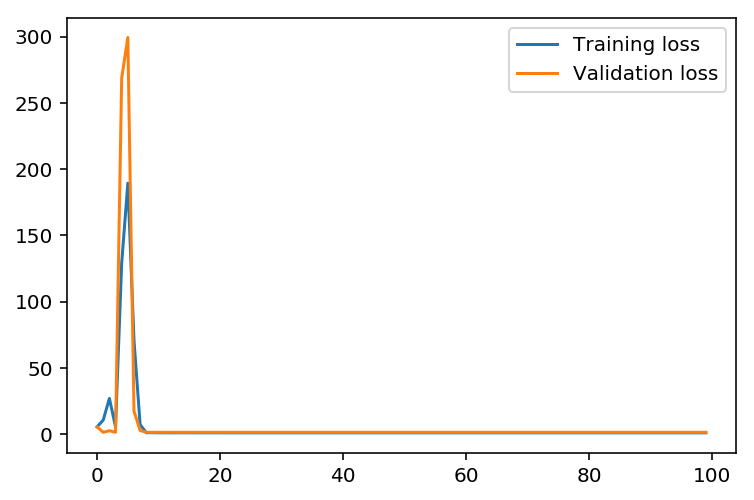

In [35]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

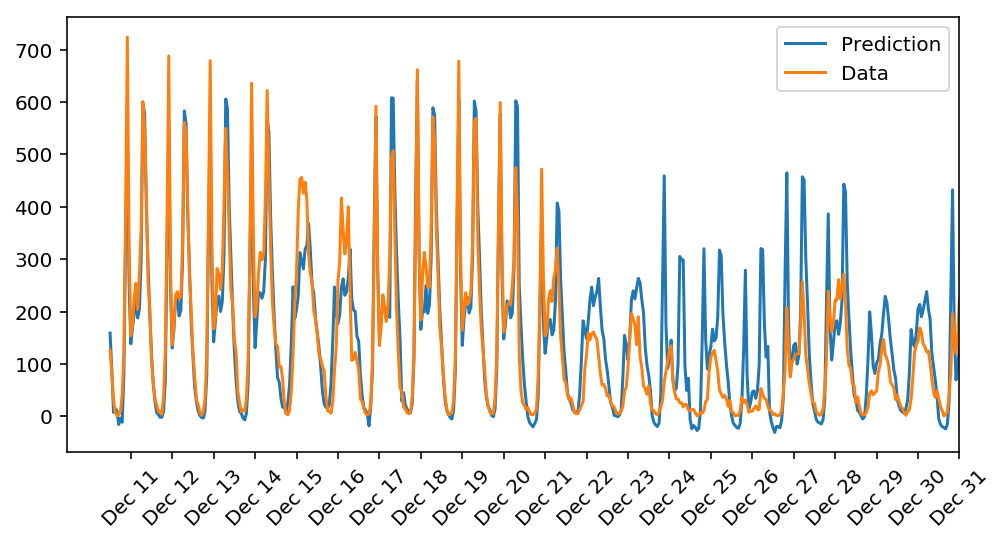

In [41]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below